In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import subprocess

In [2]:
# this is used to set limits on the y-axis for each device separately
y_limit_dictionary = {
    'Tesla-P100' : [0, 100], 
    'Tesla-V100' : [0, 140], 
    'Tesla-A100' : [0, 230], 
    'AMD-EPYC-64' : [0, 175], 
    'AMD-EPYC-24' : [0, 110], 
    'ARM-NEON' : [0, 190], 
    'INTEL-XEON' : [0, 50], 
    'INTEL-ICY' : [0, 70], 
    'IBM-POWER9' : [0, 55], 
    'Alveo-U280' : [0, 30], 
}

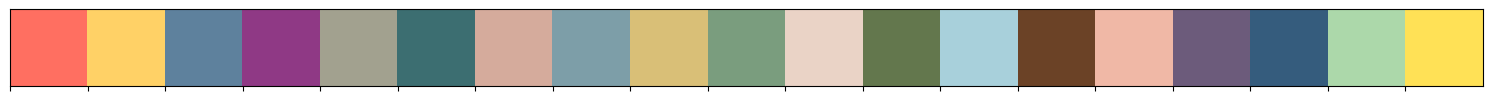

In [3]:
palette = ['#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F','#3C6E71','#D5AB9C','#7D9EA8','#D9BF77','#7A9D7E','#EAD3C6','#63774D','#A8D0DB','#6B4226','#F0B8A6','#6C5B7B','#355C7D','#ACD8AA','#FFE156']
sns.palplot(palette)
plt.show()

In [4]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()


# all devices that will be used
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(1.0, 0.43529411764705883, 0.3803921568627451),
 (1.0, 0.8196078431372549, 0.4),
 (0.3686274509803922, 0.5058823529411764, 0.615686274509804),
 (0.5607843137254902, 0.2235294117647059, 0.5215686274509804),
 (0.6352941176470588, 0.6313725490196078, 0.5607843137254902),
 (0.23529411764705882, 0.43137254901960786, 0.44313725490196076),
 (0.8352941176470589, 0.6705882352941176, 0.611764705882353),
 (0.49019607843137253, 0.6196078431372549, 0.6588235294117647),
 (0.8509803921568627, 0.7490196078431373, 0.4666666666666667),
 (0.47843137254901963, 0.615686274509804, 0.49411764705882355)]

In [5]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [6]:
# "dodge" argument explained here -> https://stackoverflow.com/questions/49078697/seaborn-boxplots-shifted-incorrectly-along-x-axis 
def harry_plotter(type, plot_df, plot_x_axis_list, plot_y_axis_list, select_str, plot_id, 
                  boxplot_width = 0.8, rotation = 30, adj_left = .1, adj_bottom = .2, adj_right = .99, adj_top = .88, 
                  no_sort=False, hue_hue = 'None', hue_hue_order = [], dodge=True, no_legend=False, no_title=True,
                  show_size=False, systemaki='',
                  no_x_axis=False, no_x_axis_title=False, add_separators = False,
                  secondary_axis=False, plot_secondary_y_itter = '', secondary_data = [], secondary_annot = [],
                 ):
    for plot_x_itter in plot_x_axis_list:
        if no_sort:
            plot_df_sorted = plot_df
        else:
            dataTypeX = plot_df[plot_x_itter].dtype
            if dataTypeX == np.float64 or dataTypeX == np.int64 or dataTypeX == float or dataTypeX == int:
                plot_df_sorted = plot_df.sort_values(plot_x_itter)
            else:
                plot_df_sorted = plot_df
                if plot_x_itter == 'mem_range':
                    cat_it = CategoricalDtype(ranges_memr, ordered=True)
                if plot_x_itter == 'regularity':
                    cat_it = CategoricalDtype(ranges_regularity, ordered=True)
                if plot_x_itter == 'impl_arch':
                    cat_it = CategoricalDtype(ranges_impl_arch, ordered=True)
                if plot_x_itter == 'System':
                    cat_it = CategoricalDtype(ranges_dev, ordered=True)
                if plot_x_itter == 'anr_categ':
                    cat_it = CategoricalDtype(ranges_anr, ordered=True)
                if plot_x_itter == 'skew_categ':
                    cat_it = CategoricalDtype(ranges_skew, ordered=True)

                plot_df_sorted[plot_x_itter] = plot_df_sorted[plot_x_itter].astype(cat_it)
                plot_df_sorted = plot_df_sorted.sort_values(plot_x_itter)

        for plot_y_itter in plot_y_axis_list:
            fig, axs = plt.subplots()
            if hue_hue == 'None':
                if(type == 'violin'):
                    sns_plot = sns.violiplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
                if(type == 'scatter'):
                    sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs)
                if(type == 'box'):
                    sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
            else:
                if(hue_hue_order != []):
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                else:
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)

            if(hue_hue_order != []):               
                # reordering the labels
                handles, labels = plt.gca().get_legend_handles_labels()
                order = [labels.index(i) for i in hue_hue_order]
                plt.legend([handles[i] for i in order], [labels[i] for i in order], 
                           title = hue_hue.replace('_categ',''), fancybox=True, frameon=False)

            if(no_legend==True):
                axs.get_legend().remove()
            else:
                #remove title from Legend
                handles, labels = axs.get_legend_handles_labels()
                axs.legend(handles=handles[0:], labels=labels[0:])
                # axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
                axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(ranges_dev), frameon=False)

            if(plot_x_itter == 'impl_arch'):
                if(add_separators  == True):
                    add_where = []
                    xtick_items = axs.get_xticklabels()
                    prev_platf = xtick_items[0].get_text().split('\n')[0] # initializae previous platform
                    for item in xtick_items:
                        platf = item.get_text().split('\n')[0]
                        if(platf!=prev_platf):
                            # when changing which platform is shown, add a separator right before
                            # to make it distinct from previous
                            add_where.append(item.get_position()[0]-0.5)
                        prev_platf = platf
                            
                    for pos in add_where:
                        plt.axvline(x=pos, color='gray', linewidth=0.15)
                
                # remove "arch" from "impl_arch"
                labels = [item.get_text().split("\n")[1] for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels)
                axs.set_xlabel('Implementation')

            if(plot_y_itter == 'energy_efficiency'):
                axs.set_ylabel("GFLOPs/W")
                # I set this limit as some outliers ( from Vectorized CSR ) caused it to reach 2.5
                # and compared to other devices, offered nothing more
                axs.set_ylim(bottom = 0, top=1.4)
            if(plot_y_itter == 'GFLOPs^2-per-W'):
                axs.set_ylabel("GFLOPs^2/W")
            if(plot_y_itter == 'gflops'):
                axs.set_ylabel("GFLOPs")
            if(plot_x_itter == 'anr_categ'):
                axs.set_xlabel('avg_nz_row')
            if(plot_x_itter == 'skew_categ'):
                axs.set_xlabel('skew_coefficient')
            if(plot_x_itter == 'regularity'):
                axs.set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )')

            if(no_title==False):
                # axs.set_title('Select: %s' %(select_str))
                axs.set_title('%s' %(select_str))

            if(show_size==True):
                if(plot_x_itter=='System' or plot_x_itter=='mem_range' or plot_x_itter=='regularity' or plot_x_itter=='anr_categ' or plot_x_itter=='skew_categ'):
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==item.get_text()].shape[0])  +')' for item in axs.get_xticklabels()]
                else:
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==float(item.get_text())].shape[0])  +')' for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels_new, fontsize = font)
                plt.xticks(rotation=45)#rotation)

            # if(plot_y_itter == 'gflops'):
            #     plt.ylim(bottom = y_limit_dictionary[system][0], top = y_limit_dictionary[system][1] )
            #     if('Tesla-P100' in select_str):
            #         plt.ylim(bottom=0, top=80) 
            #     if('Tesla-V100' in select_str):
            #         plt.ylim(bottom=0, top=140) 
            #     if('Tesla-A100' in select_str):
            #         plt.ylim(bottom=0, top=230)
            #     if('AMD-EPYC-64' in select_str):
            #         plt.ylim(bottom=0, top=175) 
            #     if('AMD-EPYC-24' in select_str):
            #         plt.ylim(bottom=0, top=110) 
            #     if('ARM-NEON' in select_str):
            #         plt.ylim(bottom=0, top=190) 
            #     if('INTEL-XEON' in select_str):
            #         plt.ylim(bottom=0, top=50) 
            #     if('INTEL-ICY' in select_str):
            #         plt.ylim(bottom=0, top=70) 
            #     if('IBM-POWER9' in select_str):
            #         plt.ylim(bottom=0, top=55) 
            #     if('Alveo-U280' in select_str):
            #         plt.ylim(bottom=0, top=30) 

            if(no_x_axis_title==True):
                axs.set_xlabel("")
            if(no_x_axis==True):
                axs.set_xticklabels([])
                axs.set_xlabel("")
                axs.set_xticks([], minor=False)#, major=False)
                
            if(secondary_axis==True):
                axs2 = axs.twinx()
                axs2.bar(range(0, len(secondary_data)), height=secondary_data,align='center', width = 0.6, alpha=0.19)
                
                if(plot_secondary_y_itter == 'mem_bw'):
                    axs2.set_ylabel("Memory Bandwidth (GB/s)")
                if(plot_secondary_y_itter == 'wins'):
                    axs2.set_ylabel("Wins percentage (%)")
                
                if(secondary_annot != []):
                    items = axs.get_xticklabels()
                    labels = [items[i].get_text() + '\n' + '(' + str(secondary_annot[i]) + '% peak performance)'  for i in range(len(items))]
                    axs.set_xticklabels(labels)

            if(systemaki != ''):
                axs.text( 0.02, 0.9, systemaki, fontsize=font, transform = axs.transAxes, )

            fig.subplots_adjust(left=adj_left, bottom=adj_bottom, right=adj_right, top=adj_top)

            plt.xticks(rotation=rotation)
            plt.setp( axs.xaxis.get_majorticklabels(), rotation=rotation )

            plt.tight_layout()

            select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')            
            if('-performance_' in select_str_id):
                select_str_id = select_str_id.split('-performance_')[0]
            else:
                select_str_id = select_str_id.split('__')[0]

            fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_itter, plot_y_itter)
            fig.savefig(fig_name)            
            plt.close()
            subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
            subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


---
# Some general use functions and variables

In [7]:
header_names = ['mtx_name','distribution','placement','seed',
                'm','n','nz','density','A_mem_footprint','mem_range',
                'avg_nz_row','std_nz_row',
                'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                'skew_coeff','avg_num_neighbours','cross_row_similarity',
                'implementation','time','gflops','W_avg','J_estimated', 'System', 'Arch']

# precision = 'f'
precision = 'd' # for double-precision arithmetic

def remove_formats(df, formats_to_discard):
    for ftd in formats_to_discard:
        df = df[df['implementation'] != ftd]
    return df

def print_formats_per_device(df):
    print('------------------------')
    print('Size of dataframe')
    print(df.shape)
    print('Tested formats')
    print(set(df['implementation']))
    print('Tested formats per device:')
    for sys in set(df['System']):
        df_sys = df[df['System'] == sys]
        print(sys, '\t', set(df_sys['implementation']))
    print('------------------------')

---
# Read GPU data

In [8]:
%%time 
inputdata_GPU_V100 = pd.read_csv('../benchmark_results/vulcan-V100/vulcan-V100_dtype-D_run_full_dataset.csv', names = header_names)
inputdata_GPU_V100['System'] = 'Tesla-V100'

inputdata_GPU_P100 = pd.read_csv('../benchmark_results/vulcan-P100/vulcan-P100_dtype-D_run_full_dataset.csv', names = header_names)
inputdata_GPU_P100['System'] = 'Tesla-P100'

inputdata_GPU_A100 = pd.read_csv('../benchmark_results/epyc5-A100/epyc5-A100_dtype-D_run_synthetic_matrices_small_dataset.csv', names = header_names)
inputdata_GPU_A100['System'] = 'Tesla-A100'

inputdata_GPU = pd.concat([inputdata_GPU_V100, inputdata_GPU_P100, inputdata_GPU_A100])
inputdata_GPU['Arch'] = 'GPU'

# nothing to discard here!
formats_to_discard = []
inputdata_GPU = remove_formats(inputdata_GPU, formats_to_discard)

print_formats_per_device(inputdata_GPU)

# inputdata_GPU = inputdata_GPU.round({'nz': -1, 'A_mem_footprint': 3, 'density': 3,
#              'avg_nnz_row': 3, 'std_nnz_row': 3,
#              'avg_bandwidth': -1, 'std_bandwidth': -1, 'avg_bandwidth_scaled': 2, 'std_bandwidth_scaled': 2,
#              'avg_scattering': 2, 'std_scattering': 2, 'avg_scattering_scaled': -1, 'std_scattering_scaled': -1,
#              'skew_coeff': 1,
#              'avg_num_neighbours' : 3, 'cross_row_similarity': 3})

------------------------
Size of dataframe
(411025, 30)
Tested formats
{'CSR5_9', 'cuSPARSE_coo11', 'Merge_11', 'cuSPARSE_hyb9-2', 'SELL-32-1', 'cuSPARSE_csr11'}
Tested formats per device:
Tesla-P100 	 {'cuSPARSE_csr11', 'CSR5_9', 'cuSPARSE_coo11', 'cuSPARSE_hyb9-2'}
Tesla-A100 	 {'cuSPARSE_csr11', 'cuSPARSE_coo11', 'Merge_11', 'SELL-32-1'}
Tesla-V100 	 {'cuSPARSE_csr11', 'CSR5_9', 'cuSPARSE_coo11', 'cuSPARSE_hyb9-2'}
------------------------
CPU times: user 2.25 s, sys: 188 ms, total: 2.44 s
Wall time: 5.72 s


# Read CPU data

In [9]:
def read_device_data(device, System, Arch, threads = 0):
    if(Arch == 'CPU'):
        # it is CPU data that we want to read, have to append number of threads too
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_synthetic_t%d_%s.csv' % (threads, precision), names = header_names)
    else: 
        # it is GPU or FPGA data that we want to read
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_synthetic_%s.csv' % (precision), names = header_names)
    df['System'] = System
    return df

In [10]:
%%time 
Hawk_threads = 64
Epyc_threads = 24
Xeon_threads = 14
Icy_threads  = 16
Arm_threads = 80
Power9_threads = 32

inputdata_CPU_AMD_HAWK    = read_device_data('amd-hawk',    'AMD-EPYC-64', 'CPU', Hawk_threads)
inputdata_CPU_AMD_EPYC1   = read_device_data('amd-epyc1',   'AMD-EPYC-24', 'CPU', Epyc_threads)
inputdata_CPU_INTEL_GOLD2 = read_device_data('intel-gold2', 'INTEL-XEON',  'CPU', Xeon_threads)
inputdata_CPU_INTEL_ICY3  = read_device_data('intel-icy3',  'INTEL-ICY',   'CPU', Icy_threads)
inputdata_CPU_ARM_NEON    = read_device_data('arm',         'ARM-NEON',    'CPU', Arm_threads)
inputdata_CPU_IBM_POWER9  = read_device_data('power9-m100', 'IBM-POWER9',  'CPU', Power9_threads)

# fix some things...
inputdata_CPU_AMD_EPYC1.astype({'avg_bandwidth': 'float64'})
inputdata_CPU_IBM_POWER9['W_avg'] = 200.1 # We could not measure power consumption from IBM Power9

inputdata_CPU = pd.concat([inputdata_CPU_AMD_HAWK, inputdata_CPU_AMD_EPYC1,
                           inputdata_CPU_ARM_NEON,
                           inputdata_CPU_INTEL_GOLD2, inputdata_CPU_INTEL_ICY3,
                           inputdata_CPU_IBM_POWER9])
inputdata_CPU['Arch'] = 'CPU'    

# formats to discard here!
formats_to_discard = ['Custom_CSR_PBV_x86', 'Custom_CSR_PBV']
inputdata_CPU = remove_formats(inputdata_CPU, formats_to_discard)

print_formats_per_device(inputdata_CPU)

# inputdata_CPU = inputdata_CPU.round({'nz': -1, 'A_mem_footprint': 3, 'density': 3,
#              'avg_nnz_row': 3, 'std_nnz_row': 3,
#              'avg_bandwidth': -1, 'std_bandwidth': -1, 'avg_bandwidth_scaled': 2, 'std_bandwidth_scaled': 2,
#              'avg_scattering': 2, 'std_scattering': 2, 'avg_scattering_scaled': -1, 'std_scattering_scaled': -1,
#              'skew_coeff': 1,
#              'avg_num_neighbours' : 3, 'cross_row_similarity': 3})

------------------------
Size of dataframe
(1719381, 30)
Tested formats
{'ARMPL', 'SELL-32-1', 'CSR5', 'MKL_IE', nan, 'Naive_CSR_CPU', 'SparseX', 'Custom_CSR_B', 'Custom_CSR_BV_x86', 'MERGE', 'Custom_CSR_BV', 'AOCL_OPTMV'}
Tested formats per device:
AMD-EPYC-64 	 {'Naive_CSR_CPU', 'CSR5', 'MKL_IE'}
ARM-NEON 	 {'ARMPL', 'SparseX', 'Naive_CSR_CPU', 'MERGE', 'SELL-32-1'}
INTEL-ICY 	 {'CSR5', 'MKL_IE', 'Naive_CSR_CPU', 'SparseX', 'MERGE', 'SELL-32-1', 'Custom_CSR_BV'}
IBM-POWER9 	 {nan, 'Naive_CSR_CPU', 'Custom_CSR_B', 'SparseX', 'MERGE', 'Custom_CSR_BV'}
AMD-EPYC-24 	 {'SELL-32-1', 'CSR5', 'MKL_IE', 'Naive_CSR_CPU', 'SparseX', 'MERGE', 'Custom_CSR_BV_x86', 'AOCL_OPTMV'}
INTEL-XEON 	 {'SELL-32-1', 'CSR5', 'MKL_IE', 'Naive_CSR_CPU', 'SparseX', 'MERGE', 'Custom_CSR_BV_x86'}
------------------------
CPU times: user 9.41 s, sys: 5.2 s, total: 14.6 s
Wall time: 26.4 s


# Read FPGA data

In [11]:
# Will use this when data from FPGA regarding Vitis Library have been cleaned up
# inputdata_FPGA_ALVEO_U280 = read_device_data('alveo-u280', 'Alveo-U280', 'FPGA')

inputdata_FPGA_ALVEO_U280 = pd.read_csv('../benchmark_results/alveo-u280/PADDED-alveo-u280_spmv_4-2048_dtype-D.csv', names = header_names)
inputdata_FPGA_ALVEO_U280['System'] = 'Alveo-U280'

inputdata_FPGA = pd.concat([inputdata_FPGA_ALVEO_U280])
inputdata_FPGA['Arch'] = 'FPGA'
print(inputdata_FPGA.shape)
print(set(inputdata_FPGA['implementation']))

(51955, 30)
{'Xilinx_SpMV'}


---
# Concatenate all data

In [12]:
%%time
# Merge the results
inputdata = pd.concat([inputdata_GPU,inputdata_CPU,inputdata_FPGA])
print(inputdata.shape)

# Keep mean of benchmarks, store in "groupreps", take mean
# groupreps = inputdata.groupby(['mtx_name','distribution','placement','seed',
#                                'm','n','nz','density','A_mem_footprint','mem_range',
#                                'avg_nz_row','std_nz_row',
#                                'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
#                                'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
#                                'skew_coeff','avg_num_neighbours','cross_row_similarity',
#                                'implementation','System', 'Arch']).mean().reset_index().reindex(columns=header_names)

# These 4 columns are the ones that we want the new dataframe to be averaged (different measurements collected for the same matrix)
group_by_header = [x for x in header_names if x not in  ['time','gflops','W_avg','J_estimated']]
groupreps = inputdata.groupby(group_by_header).mean().reset_index().reindex(columns=header_names)
print(groupreps.shape)


(2182361, 30)
(688140, 30)
CPU times: user 2.72 s, sys: 2.48 s, total: 5.2 s
Wall time: 5.24 s


In [13]:
groupreps.loc[(groupreps['implementation'] == 'cuSPARSE_coo11'), 'implementation']     = 'cu-COO'
groupreps.loc[(groupreps['implementation'] == 'cuSPARSE_csr11'), 'implementation']     = 'cu-CSR'
groupreps.loc[(groupreps['implementation'] == 'cuSPARSE_hyb9-2'), 'implementation']    = 'cu-HYB'
groupreps.loc[(groupreps['implementation'] == 'CSR5_9'), 'implementation']             = 'CSR5'
groupreps.loc[(groupreps['implementation'] == 'Merge_11'), 'implementation']           = 'Merge'
groupreps.loc[(groupreps['implementation'] == 'Naive_CSR_CPU'), 'implementation']      = 'Naive-CSR'
groupreps.loc[(groupreps['implementation'] == 'Custom_CSR_BV_x86'), 'implementation']  = 'Vec-CSR'    
groupreps.loc[(groupreps['implementation'] == 'Custom_CSR_PBV_x86'), 'implementation'] = 'Vec-Bal-CSR'
groupreps.loc[(groupreps['implementation'] == 'Custom_CSR_BV'), 'implementation']      = 'Vec-CSR'
groupreps.loc[(groupreps['implementation'] == 'Custom_CSR_PBV'), 'implementation']     = 'Vec-Bal-CSR'
groupreps.loc[(groupreps['implementation'] == 'Custom_CSR_B'), 'implementation']       = 'Bal-CSR'    
groupreps.loc[(groupreps['implementation'] == 'MKL_IE_no_hint'), 'implementation']     = 'MKL-IE-no-hint'
groupreps.loc[(groupreps['implementation'] == 'MKL_IE'), 'implementation']             = 'MKL-IE'
groupreps.loc[(groupreps['implementation'] == 'AOCL_OPTMV'), 'implementation']         = 'AOCL'
groupreps.loc[(groupreps['implementation'] == 'SparseX'), 'implementation']            = 'SparseX'
groupreps.loc[(groupreps['implementation'] == 'SELL-32-1'), 'implementation']          = 'SELL-C-s'
groupreps.loc[(groupreps['implementation'] == 'MERGE'), 'implementation']              = 'Merge-CSR'
groupreps.loc[(groupreps['implementation'] == 'ARMPL'), 'implementation']              = 'ARM-lib'
groupreps.loc[(groupreps['implementation'] == 'Xilinx_SpMV'), 'implementation']        = 'Xilinx-lib'

# Group by "best-of" implementation for each device
# skip this step if you want to plot every measurement collected

In [15]:
%%time
# Group per system, take best (it was over "inputdata", but "groupreps" is better choice I think)
# fixed this after reordering groupreps columns according to header_names
# before this, columns and data were mixed and it was a complete shitstorm
# group_system = groupreps.groupby(['mtx_name','distribution','placement','seed',
#                                   'm','n','nz','density','A_mem_footprint','mem_range',
#                                   'avg_nz_row','std_nz_row',
#                                   'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
#                                   'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
#                                   'skew_coeff','avg_num_neighbours','cross_row_similarity',
#                                   'System','Arch'], as_index = False)
group_by_header = [x for x in header_names if x not in  ['implementation', 'time','gflops','W_avg','J_estimated']]
group_system = groupreps.groupby(group_by_header, as_index = False)

reslist = []
for desc, experiment in group_system:
    best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['implementation'] == best_format]
    # if(len(outrow)>1):
    #     print(len(outrow), outrow)
    reslist.append(outrow.values.tolist()[0])             

group_system_best = pd.DataFrame(reslist, columns = header_names)
print(group_system_best.shape)

(139937, 30)
CPU times: user 2min 13s, sys: 1.62 s, total: 2min 14s
Wall time: 2min 14s


---
# some general use functions before moving on...

In [14]:
def set_category(x, cat_list, cat_size, ranges_size_flag=False):
    for index in range(len(cat_list)):
        cat = cat_list[index]
        cat_min = float(cat.strip('[').strip(']').split('-')[0])
        cat_max = float(cat.strip('[').strip(']').split('-')[1])
        # print(cat_min, cat_max,'->\t->', x)
        if(x>cat_min and x<=cat_max):
            if(ranges_size_flag==True):
                return cat_size[index]
            else:
                return cat_list[index]
            
def set_category2(x, cat_list, cat_size, ranges_size_flag=False):
    for index in range(len(cat_list)):
        cat = cat_list[index]
        if(x==cat):
            return cat_size[index]

# write all available devices here
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

ranges_arch = ['GPU', 'GPU', 'GPU', 
               'CPU', 'CPU', 
               'CPU', 'CPU', 
               'CPU', 
               'CPU', 
               'FPGA']


# in this list, we append
ranges_impl_arch = ['( Tesla-P100 )\ncu-COO', '( Tesla-P100 )\ncu-CSR', '( Tesla-P100 )\ncu-HYB', 
                    '( Tesla-P100 )\nCSR5',

                    '( Tesla-V100 )\ncu-COO', '( Tesla-V100 )\ncu-CSR', '( Tesla-V100 )\ncu-HYB', 
                    '( Tesla-V100 )\nCSR5',

                    '( Tesla-A100 )\ncu-COO', '( Tesla-A100 )\ncu-CSR', 
                    '( Tesla-A100 )\nMerge-CSR', '( Tesla-A100 )\nSELL-C-s',

                    '( AMD-EPYC-24 )\nNaive-CSR',  '( AMD-EPYC-24 )\nVec-CSR',  # '( AMD-EPYC-24 )\nVec-Bal-CSR',  
                    '( AMD-EPYC-24 )\nAOCL', '( AMD-EPYC-24 )\nMKL-IE', 
                    '( AMD-EPYC-24 )\nCSR5', '( AMD-EPYC-24 )\nSparseX', '( AMD-EPYC-24 )\nMerge-CSR', '( AMD-EPYC-24 )\nSELL-C-s', 
                    
                    '( AMD-EPYC-64 )\nNaive-CSR',
                    '( AMD-EPYC-64 )\nMKL-IE',  '( AMD-EPYC-64 )\nCSR5', 

                    '( ARM-NEON )\nNaive-CSR',
                    '( ARM-NEON )\nARM-lib', 
                    '( ARM-NEON )\nSparseX', '( ARM-NEON )\nMerge-CSR', '( ARM-NEON )\nSELL-C-s', 

                    '( INTEL-XEON )\nNaive-CSR',  '( INTEL-XEON )\nVec-CSR',  
                    '( INTEL-XEON )\nMKL-IE',
                    '( INTEL-XEON )\nCSR5', '( INTEL-XEON )\nSparseX', '( INTEL-XEON )\nMerge-CSR', '( INTEL-XEON )\nSELL-C-s',                    

                    '( INTEL-ICY )\nNaive-CSR',  '( INTEL-ICY )\nVec-CSR',
                    '( INTEL-ICY )\nMKL-IE', 
                    '( INTEL-ICY )\nCSR5', '( INTEL-ICY )\nSparseX', '( INTEL-ICY )\nMerge-CSR', '( INTEL-ICY )\nSELL-C-s', 

                    '( IBM-POWER9 )\nNaive-CSR', '( IBM-POWER9 )\nBal-CSR', 
                    '( IBM-POWER9 )\nVec-CSR',
                    '( IBM-POWER9 )\nSparseX', '( IBM-POWER9 )\nMerge-CSR',
                    
                    '( Alveo-U280 )\nXilinx-lib']

ranges_impl_arch_backup = ranges_impl_arch


# These ranges_* lists here define the ranges for each feature, that will be used to plot later...
ranges_memr = ['[4-8]','[8-16]','[16-32]','[32-64]','[64-128]','[128-256]','[256-512]','[512-1024]','[1024-2048]'] # A_mem_footprint

ranges_anr = ['[0-20]', '[20-75]','[75-150]', '[150-510]'] # avg_nz_row
ranges_anr = ['[0-15]', '[15-40]', '[40-75]','[75-150]', '[150-510]'] # avg_nz_row

# ranges_skew = ['[0-100]', '[100-500]', '[500-2000]', '[2000-180000]'] # skew_coeff
ranges_skew = ['[0-1.5]', '[1.5-50]', '[50-250]', '[250-3000]', '[3000-10000]'] # skew_coeff

ranges_ann = ['[0-0.6]', '[0.6-1.4]', '[1.4-2]'] # avg_num_neighbours
ranges_crs = ['[0-0.3]', '[0.3-0.7]', '[0.7-1]'] # cross_row_similarity

ranges_size = ['S', 'M', 'L']
ranges_regularity = ['SS', 'SM', 'SL', 'MS', 'MM', 'ML', 'LS', 'LM', 'LL']

cat_list = ['A_mem_footprint',
            'avg_nz_row',
            'skew_coeff','avg_num_neighbours','cross_row_similarity']
ranges_list = [ranges_memr,
               ranges_anr, 
               ranges_skew, 
               ranges_ann, ranges_crs]


# add some extra columns to dataframes "groupreps" and "group_system_best"

In [16]:
def add_extra_columns(df, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew):
    df = df[df['W_avg']>=0]

    # this has to be to discard some anomalies from AMD-HAWK measurements
    df1 = df[df['System'] != 'AMD-EPYC-64']
    df2 = df[df['System'] == 'AMD-EPYC-64'] 
    df2 = df2[df2['W_avg']>30]
    df = pd.concat([df1, df2])
    # df = df[df['W_avg']>32.9]

    df['impl_arch'] = "( " + df['System'] + " " ")\n" + df['implementation']
    df['energy_efficiency'] = df['gflops'] / df['W_avg'] 
    df['GFLOPs^2-per-W'] = df['gflops'] * df['gflops'] / df['W_avg']

    df['crs_categ'] = df.apply(lambda row: set_category(row['cross_row_similarity'], ranges_crs, ranges_size, ranges_size_flag=True), axis=1)
    df['ann_categ'] = df.apply(lambda row: set_category(row['avg_num_neighbours'], ranges_ann, ranges_size, ranges_size_flag=True), axis=1)
    df['regularity'] = df['crs_categ'] + df['ann_categ']

    df['anr_categ'] = df.apply(lambda row: set_category(row['avg_nz_row'], ranges_anr, [], ranges_size_flag=False), axis=1)
    df['skew_categ'] = df.apply(lambda row: set_category(row['skew_coeff'], ranges_skew, [], ranges_size_flag=False), axis=1)
    
    return df

In [17]:
%%time
groupreps = add_extra_columns(groupreps, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew)
group_system_best = add_extra_columns(group_system_best, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew)

# this will be used sometime in the future...
extra_header_names = ['impl_arch', 'energy_efficiency', 'GFLOPs^2-per-W', 
                      'crs_categ', 'ann_categ', 'regularity', 'anr_categ', 'skew_categ']


CPU times: user 23.8 s, sys: 2.22 s, total: 26 s
Wall time: 26.1 s


---
# wins per format per device (percentage of each format that shows best performance for the matrices in the synthetic dataset)

In [18]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

for system in ranges_dev:
    print('---', system, '---')
    group_sys = group_system_best[group_system_best['System']==system]
    print(group_sys.shape)
    implementations = set(group_sys['implementation'])
    sys_shape = group_sys.shape[0]
    for impl in implementations:
        group_sys_impl = group_sys[group_sys['implementation']==impl]
        sys_impl_shape = group_sys_impl.shape[0]
        print(np.round(sys_impl_shape/sys_shape*100,2), '%', '\t', impl)
    print('---')

--- Tesla-P100 ---
(9918, 38)
20.45 % 	 cu-CSR
24.22 % 	 cu-COO
35.61 % 	 cu-HYB
19.72 % 	 CSR5
---
--- Tesla-V100 ---
(12692, 38)
26.0 % 	 cu-CSR
11.0 % 	 cu-COO
33.75 % 	 cu-HYB
29.25 % 	 CSR5
---
--- Tesla-A100 ---
(15362, 38)
55.44 % 	 cu-CSR
39.49 % 	 cu-COO
3.03 % 	 Merge
2.04 % 	 SELL-C-s
---
--- AMD-EPYC-24 ---
(15263, 38)
7.86 % 	 SELL-C-s
5.58 % 	 AOCL
0.5 % 	 CSR5
31.21 % 	 Vec-CSR
5.16 % 	 Merge-CSR
18.42 % 	 MKL-IE
30.73 % 	 SparseX
0.54 % 	 Naive-CSR
---
--- AMD-EPYC-64 ---
(13839, 38)
66.36 % 	 MKL-IE
22.62 % 	 CSR5
11.03 % 	 Naive-CSR
---
--- ARM-NEON ---
(15263, 38)
5.44 % 	 SELL-C-s
23.63 % 	 ARM-lib
14.53 % 	 Merge-CSR
41.75 % 	 SparseX
14.64 % 	 Naive-CSR
---
--- INTEL-XEON ---
(15263, 38)
22.94 % 	 SELL-C-s
27.21 % 	 Vec-CSR
0.01 % 	 CSR5
11.53 % 	 Merge-CSR
24.53 % 	 MKL-IE
12.53 % 	 SparseX
1.25 % 	 Naive-CSR
---
--- INTEL-ICY ---
(15249, 38)
19.46 % 	 SELL-C-s
0.14 % 	 CSR5
8.61 % 	 Vec-CSR
13.05 % 	 Merge-CSR
32.66 % 	 MKL-IE
25.32 % 	 SparseX
0.75 % 	 Naive-CS

---
# Begin plotting

# GPU only comparison (one boxplot per device)
### Also, plot memory bandwidth of each device
### and on x-axis, show percentage of median performance vs max GPU perf


In [19]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'GPU_ONLY_Comparison of SpMV Devices-(Performance)'

plot_x_axis = ['System']
plot_y_axis = ['gflops']

groupdata = group_system_best

ranges_impl_arch = [
    x for x in ranges_impl_arch_backup if 
    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
     (x.split("\n")[1] in set(groupdata[groupdata['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

groupdata_GPU = groupdata[groupdata['Arch']=='GPU']

medians = []
maxs = []
bandwidths = [550 ,760, 1555]
gemms = [4700, 7000, 9700]
for sys in ranges_dev:
    groupdata_GPU_sys = groupdata_GPU[groupdata_GPU['System']==sys]
    print(sys, '\tmedian', round(groupdata_GPU_sys['gflops'].median(),0), '\tmax', round(groupdata_GPU_sys['gflops'].max(),0))
    medians.append(groupdata_GPU_sys['gflops'].median())
    maxs.append(groupdata_GPU_sys['gflops'].max())
rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
for i in range(len(ranges_dev)):
    print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(1.5 * width,height))
harry_plotter('box', groupdata_GPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
              no_x_axis_title=True, rotation=0, boxplot_width = 0.4,
              secondary_axis = True, plot_secondary_y_itter = 'mem_bw', secondary_data = bandwidths, secondary_annot = rel_perf)


Tesla-P100 	median 44.0 	max 71.0
Tesla-V100 	median 81.0 	max 130.0
Tesla-A100 	median 132.0 	max 220.0
Tesla-P100 	 0.94 % of peak performance
Tesla-V100 	 1.16 % of peak performance
Tesla-A100 	 1.37 % of peak performance


# Total System Comparison (best of each System)
# one boxplot per format


# First, CPU only comparison of formats

In [20]:
ranges_dev = ['AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'CPU_ONLY_Comparison of SpMV Implementations-Formats-(Performance)'

plot_x_axis = ['impl_arch']
plot_y_axis = ['gflops']

groupdata = group_system_best

ranges_impl_arch = [
    x for x in ranges_impl_arch_backup if 
    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
     (x.split("\n")[1] in set(groupdata[groupdata['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

# harry_plotter('violin', group_system_best_select, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
groupdata_CPU = groupdata[groupdata['Arch']=='CPU']

wins = []
for sys in ranges_dev:
    # print('---\n',sys)
    groupdata_CPU_sys = groupdata_CPU[groupdata_CPU['System']==sys]
    sys_shape = groupdata_CPU_sys.shape[0]
    for impl_arch_curr in ranges_impl_arch:
        if(sys in impl_arch_curr):
            impl = impl_arch_curr.split('\n')[1]
            group_sys_impl = groupdata_CPU_sys[groupdata_CPU_sys['implementation']==impl]
            sys_impl_shape = group_sys_impl.shape[0]
            # print(impl, '\t', np.round(sys_impl_shape/sys_shape*100,2), '%')
            wins.append(np.round(sys_impl_shape/sys_shape*100,2))

plt.rc('figure', figsize=(2.5 * width,1 * height))
harry_plotter('box', groupdata_CPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=60, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)


# Now all

In [21]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = [
    x for x in ranges_impl_arch_backup if 
    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
     (x.split("\n")[1] in set(group_system_best[group_system_best['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Implementations-Formats-(Performance)'

plot_x_axis = ['impl_arch']
plot_y_axis = ['gflops']

groupdata = group_system_best

wins = []
for sys in ranges_dev:
    # print('---\n',sys)
    groupdata_sys = groupdata[groupdata['System']==sys]
    sys_shape = groupdata_sys.shape[0]
    for impl_arch_curr in ranges_impl_arch:
        if(sys in impl_arch_curr):
            impl = impl_arch_curr.split('\n')[1]
            group_sys_impl = groupdata_sys[groupdata_sys['implementation']==impl]
            sys_impl_shape = group_sys_impl.shape[0]
            perc = np.round(sys_impl_shape/sys_shape*100,2)
            # print(impl, '\t', perc, '%')
            if(perc==100):
                perc = 0
            wins.append(perc)

plt.rc('figure', figsize=(3 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=90, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)

# select_str = 'Comparison of SpMV Implementations-Formats-(Energy Efficiency)'

# plot_x_axis = ['impl_arch']
# plot_y_axis = ['energy_efficiency']

# # harry_plotter('violin', group_system_best, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # plt.rc('figure', figsize=(width,height*par))
# plt.rc('figure', figsize=(width*par2,height*par))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, 
#               hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, rotation=60)


# one boxplot per device

In [22]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = [x for x in ranges_impl_arch_backup if 
                    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
                     (x.split("\n")[1] in set(group_system_best[group_system_best['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]


system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Devices-(Performance)'
plot_x_axis = ['System']
plot_y_axis = ['gflops']

# groupdata = groupreps
groupdata = group_system_best

# medians = []
# maxs = []
# bandwidths = [550 ,760, 1935]

# gemms = [7000, 9700, 2100, 818, 970, 500, 150] # 2100 for AMD-HAWK is estimation. 500 for power9 too
# for sys in ranges_dev:
#     groupdata_sys = groupdata[groupdata['System']==sys]
#     print(sys, '\tmedian', round(groupdata_sys['gflops'].median(),0), '\tmax', round(groupdata_sys['gflops'].max(),0))
#     medians.append(groupdata_sys['gflops'].median())
#     maxs.append(groupdata_sys['gflops'].max())
# rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
# for i in range(len(ranges_dev)):
#     print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(1.5 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True, 
              boxplot_width = 0.4, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)


select_str = 'Comparison of SpMV Devices-(Energy Efficiency)'
plot_x_axis = ['System']
plot_y_axis = ['energy_efficiency']

plt.rc('figure', figsize=(1.5 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
              boxplot_width = 0.4, rotation=30)#, add_inside=add_inside)
              # no_x_axis_title=True, no_x_axis=True)
              # rotation=0, no_x_axis_title=True)

# select_str = 'Comparison of SpMV Devices-(inverse EDP)'

# plot_x_axis = ['System']
# plot_y_axis = ['GFLOPs^2-per-W']
# # harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # par=0.75
# par=1
# plt.rc('figure', figsize=(width*par3,height*par*par2))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
#              )
#               # rotation=0, no_x_axis_title=True)

/home/pmpakos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [23]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
groupdata = group_system_best
print('Max performance per System')
for system in ranges_dev:
    tmp = groupdata[groupdata['System']==system]
    print(system, '\t', round(tmp['gflops'].max()))

Max performance per System
Tesla-P100 	 71
Tesla-V100 	 130
Tesla-A100 	 220
AMD-EPYC-24 	 103
AMD-EPYC-64 	 168
ARM-NEON 	 144
INTEL-XEON 	 40
INTEL-ICY 	 64
IBM-POWER9 	 50
Alveo-U280 	 30


---
---
---

In [24]:
def select_region(system, feature, pcg, what, group_data, group_metadata=[]):
    # plot synthetic dataset only # used to be 'friends' != True here... but no point in it. move on with sth basic
    select_criterion = (group_data['Arch'] != '')
    if(system!=''):
        select_criterion = select_criterion & (group_data['System']==system)
    select_str = ''

    # features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
    features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'regularity']
    for feat in features:
        if(feat=='regularity'):
            if(feat!=feature):
                irr_val_list = ['SS', 'SM', 'SL', 'MS', 'MM', 'ML', 'LS', 'LM', 'LL']

                select_str = select_str + feat + '=['+ ','.join(irr_val_list) +']' + '  '
                for irr_val in irr_val_list:
                    if(irr_val == irr_val_list[0]):
                        select_criterion_irr = (group_data[feat] == irr_val)
                    else:
                        select_criterion_irr = select_criterion_irr | (group_data[feat] == irr_val)
                select_criterion = select_criterion & select_criterion_irr
        else:
            if(group_metadata!=[]):
                feat_range = list(group_metadata[feat])[0].strip('[ ]').split(' - ')
                min_feat, max_feat = float(feat_range[0]), float(feat_range[1])
            else:
                if(feat!=feature):
                    if(feat == 'A_mem_footprint'):
                        min_feat, max_feat = 0, 2048
                    if(feat == 'avg_nz_row'):
                        min_feat, max_feat = 0, 510
                    if(feat == 'skew_coeff'):
                        prmin_feat, max_feat = 0, 180000
                    select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
                    select_criterion = select_criterion & (group_data[feat] >= min_feat) & (group_data[feat] <= max_feat)
    return select_criterion, select_str


# plot impact of each feature together for all platforms

In [25]:
font = 15
def plot_dev_perf(feature, pcg, what, group_data, group_metadata=[]):
    system2 = 'Feature Impact'
    plot_x_axis = feature
    if(feature=='A_mem_footprint'):
        plot_x_axis = 'mem_range'
    elif(feature=='avg_nz_row'):
        plot_x_axis = 'anr_categ'
    elif(feature=='skew_coeff'):
        plot_x_axis = 'skew_categ'

    plot_y_axis = 'gflops'

    plot_id = system2
    select_str = feature

    ctr = 0
    fig, axs = plt.subplots(len(ranges_dev))
    fig.subplots_adjust(left=.15, bottom=.17*(2/6)*(4/3), right=.99, top=.99)
    for system in ranges_dev:
        select_criterion_tmp, select_str_tmp = select_region(system, feature, pcg, what, group_data, group_metadata=[])
        group_system_select_tmp = group_data[select_criterion_tmp]
        
        group_system_select_tmp_sorted = group_system_select_tmp
        if plot_x_axis == 'mem_range':
            cat_it = CategoricalDtype(ranges_memr, ordered=True)
        if plot_x_axis == 'regularity':
            cat_it = CategoricalDtype(ranges_regularity, ordered=True)
        if plot_x_axis == 'anr_categ':
            cat_it = CategoricalDtype(ranges_anr, ordered=True)
        if plot_x_axis == 'skew_categ':
            cat_it = CategoricalDtype(ranges_skew, ordered=True)

        pd.options.mode.chained_assignment = None # https://stackoverflow.com/a/49729413
        group_system_select_tmp_sorted[plot_x_axis] = group_system_select_tmp_sorted[plot_x_axis].astype(cat_it)
        group_system_select_tmp_sorted = group_system_select_tmp_sorted.sort_values(plot_x_axis)
        
        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=0.4, data=group_system_select_tmp, x=plot_x_axis, y=plot_y_axis, 
                               hue='System', hue_order=ranges_dev, ax=axs[ctr], dodge=False)

        axs[ctr].tick_params(axis='both', which='major', labelsize=font)
        axs[ctr].tick_params(axis='both', which='minor', labelsize=font)
        axs[ctr].set_ylabel('')

        if(plot_y_axis == 'gflops'):
            axs[ctr].set_ylim(y_limit_dictionary[system])
            # if('Tesla-P100' in select_str):
            #     axs[ctr].set_ylim([0, 80]) 
            # if('Tesla-V100' in select_str):
            #     axs[ctr].set_ylim([0, 140]) 
            # if('Tesla-A100' in select_str):
            #     axs[ctr].set_ylim([0, 230]) 
            # if('AMD-EPYC-64' in select_str):
            #     axs[ctr].set_ylim([0, 175]) 
            # if('AMD-EPYC-24' in select_str):
            #     axs[ctr].set_ylim([0, 110]) 
            # if('ARM-NEON' in select_str):
            #     axs[ctr].set_ylim([0, 190]) 
            # if('INTEL-XEON' in select_str):
            #     axs[ctr].set_ylim([0, 50]) 
            # if('INTEL-ICY' in select_str):
            #     axs[ctr].set_ylim([0, 70]) 
            # if('IBM-POWER9' in select_str):
            #     axs[ctr].set_ylim([0, 55]) 
            # if('Alveo-U280' in select_str):
            #     axs[ctr].set_ylim([0, 30]) 

        if(system == ranges_dev[-1]):  # only for last platform
            if(plot_x_axis == 'mem_range'):
                axs[ctr].set_xlabel('memory range (MB)', fontsize = font)
            if(plot_x_axis == 'anr_categ'):
                axs[ctr].set_xlabel('average number of nonzeros per row', fontsize = font)
            if(plot_x_axis == 'skew_categ'):
                axs[ctr].set_xlabel('skew coefficient', fontsize = font)
            if(plot_x_axis == 'regularity'):
                axs[ctr].set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )', fontsize = font)
        else:
            axs[ctr].set_xlabel('')

        if(system != ranges_dev[-1]): # for all except last platform
            axs[ctr].set_xticks([])
            axs[ctr].set_xticklabels([])

        # axs[ctr].text( 0.02, 0.9, system, fontsize=font, transform = axs[ctr].transAxes, )

        plt.xticks(rotation=90)#rotation
        # no_legend = True
        # if(no_legend==True):
        #     axs[ctr].get_legend().remove()

        # whichever system is first in ranges_dev
        if(system == ranges_dev[0]):
            axs[ctr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
            handles, labels = axs[ctr].get_legend_handles_labels()
        else:
            axs[ctr].get_legend().remove()

        plt.xticks(rotation=45)#rotation)
        ctr+=1

    select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')
    if('-performance_' in select_str_id):
        select_str_id = select_str_id.split('-performance_')[0]
    else:
        select_str_id = select_str_id.split('__')[0]

    # fig.set_size_inches(width*1.2, height*1.7)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.text(0.00, 0.5, 'GFLOPs', va='center', rotation='vertical', fontsize=font)
    fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_axis, plot_y_axis)
    fig.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

    return handles, labels # to be used in later plots

#####################################################################################################################
#####################################################################################################################

group_data = group_system_best

features = ['A_mem_footprint', 'avg_nz_row', 'skew_coeff', 'regularity']

ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
plt.rc('figure', figsize=(3*width,len(ranges_dev)*0.5*height))

change_colors(ranges_dev, color_dictionary)

handles, labels = [], []
for feature in features:
    # if(system=='Tesla-V100'): # if(system=='AMD-EPYC'): # if(system=='ARM-NEON'): # if(system=='Alveo-U280'):
    handles, labels = plot_dev_perf(feature, 10, 'all', group_data)


---
# Plot histograms of performance on each device separately.
# View range of performance for each format tested

In [6]:
def plot_histogram_performance_device(data, which, System):
    data_sys = data[data['System'] == System]
    sns.histplot(data=data_sys, x='gflops', hue='implementation', element='step')
    plt.title('Histogram of performance (per format) (%s) for %s' % (which, System))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-%s-%s.pdf' % (System, which)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


def plot_histogram_performance_device_more_specific(data, which, System, feature, feature_values):
    data_sys = data[data['System'] == System]
    data_sys = data_sys[data_sys[feature].isin(feature_values) ]
    sns.histplot(data=data_sys, x='gflops', hue='implementation', element='step')
    plt.title('Histogram of performance (per format) (%s) for %s for %s = %s' % (which, System, feature, feature_values))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-specific-%s-%s.pdf' % (System, which)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


In [ ]:
plt.rc('figure', figsize=(2*width,2*height))
    
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
for System in ranges_dev:
    plot_histogram_performance_device(group_system_best, 'bestof', System)
    plot_histogram_performance_device(groupreps, 'all', System)

feature = 'mem_range'
feature_values = ['[256-512]', '[512-1024]', '[1024-2048]']
for System in ranges_dev:
    plot_histogram_performance_device_more_specific(group_system_best, 'bestof', System, feature, feature_values)
    plot_histogram_performance_device_more_specific(groupreps, 'all', System, feature, feature_values)


In [27]:
def plot_per_feature_below(data, thresholds, feature, bins, System, verbose=False):
    # sns.histplot(data=data, x=feature, hue='implementation', bins=bins)
    sns.histplot(data=data, x=feature, bins=bins)

    if(verbose):
        # Access the patches (bars) in the histogram
        patches = plt.gca().patches
        # Add xtick values and bar heights as labels
        for patch in patches:
            height = patch.get_height()
            if(height>0):
                x = patch.get_x() + patch.get_width() / 2
                plt.text(x, height+1, f'{x:.2f} ({height})', ha='center', va='bottom', rotation=45)

    plt.title('Variation of %s for %s GFLOPs performance on %s' % (feature, thresholds, System))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-%s-%s-%s.pdf' % (System, thresholds, feature)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


def filter_data_performance(data, System, features, features_values, perf_thresholds):
    print('Filter applied to data on device %s: ' % (System))
    filter_data = data
    filter_data = filter_data[filter_data['System'] == System]
    for i in range(len(features)):
        print(features[i], features_values[i])
        filter_data = filter_data[filter_data[feature].isin(feature_values)]
    print()
    print('Performance range of', System, 'for these matrices:', round(filter_data['gflops'].min(),2), '-', round(filter_data['gflops'].max(),2))
    features = ['avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
    bins = [20, 100, 20, 20]
    rounding = [0, -1, 1, 1]

    filter_data_thres = filter_data[(filter_data['gflops'] >= perf_thresholds[0]) & (filter_data['gflops'] <= perf_thresholds[1])]
    print(filter_data_thres.shape[0],'/', filter_data.shape[0], 'matrices achieve performance of', perf_thresholds, 'GFLOPs')  
    print('Implementations of performance in range ', perf_thresholds, set(filter_data_thres['implementation']))
    for i in range(len(features)):
        plot_per_feature_below(filter_data_thres, perf_thresholds, features[i], bins[i], System, verbose=True)
        print(perf_thresholds, '->', features[i], sorted(set([round(x,rounding[i]) for x in list(filter_data_thres[features[i]])])))
    print()


In [28]:
features = ['mem_range']
features_values = [['[1024-2048]']]
filter_data_performance(group_system_best, 'Tesla-A100', features, features_values, [100,150])

Filter applied to data on device Tesla-A100: 
mem_range ['[1024-2048]']

Performance range of Tesla-A100 for these matrices: 27.61 - 220.43
2567 / 7619 matrices achieve performance of [100, 150] GFLOPs
Implementations of performance in range  [100, 150] {'cu-CSR', 'cu-COO', 'SELL-C-s', 'Merge'}
[100, 150] -> avg_nz_row [5.0, 10.0, 20.0, 50.0, 51.0, 100.0, 101.0, 499.0, 500.0, 501.0]
[100, 150] -> skew_coeff [0.0, 100.0, 110.0, 140.0, 180.0, 280.0, 390.0, 500.0, 610.0, 1000.0, 2760.0, 3590.0, 4410.0, 7060.0, 9710.0, 9820.0, 9860.0, 9890.0, 9920.0, 9930.0, 9940.0, 9950.0, 9960.0, 9970.0, 9980.0, 9990.0, 10000.0]
[100, 150] -> avg_num_neighbours [0.0, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
[100, 150] -> cross_row_similarity [0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]



In [29]:
features = ['mem_range']
# features_values = [['[256-512]','[512-1024]','[1024-2048]']]
features_values = [['[1024-2048]']]
filter_data_performance(group_system_best, 'Tesla-A100', features, features_values, [0,50])

Filter applied to data on device Tesla-A100: 
mem_range ['[1024-2048]']

Performance range of Tesla-A100 for these matrices: 27.61 - 220.43
182 / 7619 matrices achieve performance of [0, 50] GFLOPs
Implementations of performance in range  [0, 50] {'cu-CSR', 'SELL-C-s'}
[0, 50] -> avg_nz_row [5.0, 10.0]
[0, 50] -> skew_coeff [0.0, 100.0, 1000.0, 9980.0, 9990.0, 10000.0]
[0, 50] -> avg_num_neighbours [0.0, 0.4, 0.5, 0.7, 0.8, 0.9, 1.1]
[0, 50] -> cross_row_similarity [0.0, 0.1, 0.4, 0.5]



In [30]:
features = ['mem_range']
# features_values = [['[256-512]','[512-1024]','[1024-2048]']]
features_values = [['[1024-2048]']]
filter_data_performance(group_system_best, 'Tesla-A100', features, features_values, [0,75])

Filter applied to data on device Tesla-A100: 
mem_range ['[1024-2048]']

Performance range of Tesla-A100 for these matrices: 27.61 - 220.43
507 / 7619 matrices achieve performance of [0, 75] GFLOPs
Implementations of performance in range  [0, 75] {'cu-CSR', 'SELL-C-s'}
[0, 75] -> avg_nz_row [5.0, 10.0, 20.0]
[0, 75] -> skew_coeff [0.0, 100.0, 1000.0, 9980.0, 9990.0, 10000.0]
[0, 75] -> avg_num_neighbours [0.0, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5]
[0, 75] -> cross_row_similarity [0.0, 0.1, 0.2, 0.4, 0.5]



---

In [31]:
def select_region2(system, what, group_data):
    # plot synthetic dataset only # used to be 'friends' != True here... but no point in it. move on with sth basic
    select_criterion = (group_data['Arch'] != '')
    if(system!=''):
        select_criterion = select_criterion & (group_data['System']==system)
    select_str = ''

    # features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
    features = ['avg_nz_row', 'skew_coeff', 'regularity']
    for feat in features:
        if(feat=='regularity'):
            if(what == 'good'):
                irr_val_list = ['LL']
                if(system=='Alveo-U280'):
                    irr_val_list = ['LS']
            # elif(what == 'bad'):
            #     irr_val_list = ['SS']
            #     if(system=='Alveo-U280'):
            #         irr_val_list = ['SL']
            elif(what == 'all'):
                irr_val_list = ['SS', 'SM', 'SL', 'MS', 'MM', 'ML', 'LS', 'LM', 'LL']

            select_str = select_str + feat + '=['+ ','.join(irr_val_list) +']' + '  '
            for irr_val in irr_val_list:
                if(irr_val == irr_val_list[0]):
                    select_criterion_irr = (group_data[feat] == irr_val)
                else:
                    select_criterion_irr = select_criterion_irr | (group_data[feat] == irr_val)
            select_criterion = select_criterion & select_criterion_irr
        else:
            if(what == 'good'):
                if(feat == 'avg_nz_row'):
                    min_feat, max_feat = 45, 510                        
                if(feat == 'skew_coeff'):
                    min_feat, max_feat = 0, 50
            if(what == 'all'):
                if(feat == 'avg_nz_row'):
                    min_feat, max_feat = 0, 510
                if(feat == 'skew_coeff'):
                    prmin_feat, max_feat = 0, 180000
            select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
            select_criterion = select_criterion & (group_data[feat] >= min_feat) & (group_data[feat] <= max_feat)
    return select_criterion, select_str


def select_region3(system, what, group_data, fpga_thres = 64):
    # plot synthetic dataset only # used to be 'friends' != True here... but no point in it. move on with sth basic
    select_criterion = (group_data['Arch'] != '')
    if(system!=''):
        select_criterion = select_criterion & (group_data['System']==system)
    select_str = ''

    feat = 'A_mem_footprint'
    if(what == 'big'):
        if(system=='Tesla-P100'):
            min_feat, max_feat = 64, 2048
        if(system=='Tesla-V100'):
            min_feat, max_feat = 64, 2048
        if(system=='Tesla-A100'):
            min_feat, max_feat = 64, 2048
        if(system=='AMD-EPYC-64'):
            min_feat, max_feat = 256, 2048
        if(system=='AMD-EPYC-24'):
            min_feat, max_feat = 128, 2048
        if(system=='ARM-NEON'):
            min_feat, max_feat = 64, 2048
        if(system=='INTEL-XEON'):
            min_feat, max_feat = 32, 2048
        if(system=='INTEL-ICY'):
            min_feat, max_feat = 64, 2048
        if(system=='IBM-POWER9'):
            min_feat, max_feat = 64, 2048
        if(system=='Alveo-U280'):
            min_feat, max_feat = fpga_thres, 2048
    if(what == 'small'):
        if(system=='Tesla-P100'):
            min_feat, max_feat = 8, 64
        if(system=='Tesla-V100'):
            min_feat, max_feat = 8, 64
        if(system=='Tesla-A100'):
            min_feat, max_feat = 8, 64
        if(system=='AMD-EPYC-64'):
            min_feat, max_feat = 8, 256
        if(system=='AMD-EPYC-24'):
            min_feat, max_feat = 8, 128
        if(system=='ARM-NEON'):
            min_feat, max_feat = 8, 64
        if(system=='INTEL-XEON'):
            min_feat, max_feat = 8, 32
        if(system=='INTEL-ICY'):
            min_feat, max_feat = 8, 32
        if(system=='IBM-POWER9'):
            min_feat, max_feat = 8, 64
        if(system=='Alveo-U280'):
            min_feat, max_feat = 8, fpga_thres
    if(what == 'all'):
        min_feat, max_feat = 0, 2048

    select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
    select_criterion = select_criterion & (group_data[feat] >= min_feat) & (group_data[feat] <= max_feat)

    return select_criterion, select_str


###################################################################################################################
###################################################################################################################
def lighten_color(color, amount=1.6):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def plot_dev_perf(feature, pcg, what, group_data, group_metadata=[]):
    if(feature == 'A_mem_footprint'):
        system2 = 'Feature Impact-all_and_good_together'
    else:
        system2 = 'Feature Impact-small_and_big_together'

    plot_x_axis = feature
    if(feature=='A_mem_footprint'):
        plot_x_axis = 'mem_range'
    if(feature=='avg_nz_row'):
        plot_x_axis = 'anr_categ'
    if(feature=='skew_coeff'):
        plot_x_axis = 'skew_categ'

    plot_y_axis = 'gflops'

    plot_id = system2
    select_str = feature

    ctr = 0
    fig, axs = plt.subplots(len(ranges_dev))
    fig.subplots_adjust(left=.15, bottom=.17*(2/6)*(4/3), right=.99, top=.99)
    for system in ranges_dev:
        select_criterion_tmp, select_str_tmp = select_region(system, feature, pcg, what, group_data, group_metadata=[])
        group_system_select_tmp = group_data[select_criterion_tmp]

        group_system_select_tmp_sorted = group_system_select_tmp
        if plot_x_axis == 'mem_range':
            cat_it = CategoricalDtype(ranges_memr, ordered=True)
        if plot_x_axis == 'regularity':
            cat_it = CategoricalDtype(ranges_regularity, ordered=True)
        if plot_x_axis == 'anr_categ':
            cat_it = CategoricalDtype(ranges_anr, ordered=True)
        if plot_x_axis == 'skew_categ':
            cat_it = CategoricalDtype(ranges_skew, ordered=True)

        pd.options.mode.chained_assignment = None # https://stackoverflow.com/a/49729413
        group_system_select_tmp_sorted[plot_x_axis] = group_system_select_tmp_sorted[plot_x_axis].astype(cat_it)
        group_system_select_tmp_sorted = group_system_select_tmp_sorted.sort_values(plot_x_axis)

        # for "all" vs "good", we do not want to change colours
        # for "small" vs "large", we want to change them (make "small" a bit lighter, by "var")
        # make "small" vs "large"
        if('small' in what_list):
            var = 0.6
        else:
            var = 0.9

        # if len==3, in case we want to plot "all" vs "small" vs "big"
        color_sys = color_dictionary[system]
        if(len(what_list)==2):
            col_palette = list(map(lambda x: sns.desaturate(x,0.9),
                                   [lighten_color(color_sys, var), lighten_color(color_sys, 1.3)]))
        else:
            col_palette = list(map(lambda x: sns.desaturate(x,0.9),
                                   [color_sys, lighten_color(color_sys, 0.5), lighten_color(color_sys, 1.8)]))
        sns.set_palette(col_palette)
        sns.color_palette()

        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=0.7, data=group_system_select_tmp, x=plot_x_axis, y=plot_y_axis, 
                               hue='mark_perf', hue_order=what_list, ax=axs[ctr])
                               #hue='System', hue_order=ranges_dev, ax=axs[ctr], dodge=False)

        axs[ctr].tick_params(axis='both', which='major', labelsize=font)
        axs[ctr].tick_params(axis='both', which='minor', labelsize=font)
        axs[ctr].set_ylabel('')

        if(plot_y_axis == 'gflops'):
            axs[ctr].set_ylim(y_limit_dictionary[system])

        # set x label only for last platform
        if(system == ranges_dev[-1]):  
            if(plot_x_axis == 'mem_range'):
                axs[ctr].set_xlabel('memory range (MB)', fontsize = font)
            if(plot_x_axis == 'anr_categ'):
                axs[ctr].set_xlabel('average number of nonzeros per row', fontsize = font)
            if(plot_x_axis == 'skew_categ'):
                axs[ctr].set_xlabel('skew coefficient', fontsize = font)
            if(plot_x_axis == 'regularity'):
                axs[ctr].set_xlabel('regularity ( cross row similarity | average number of neighbors )', fontsize = font)
        else:
            axs[ctr].set_xlabel('')
        
        # remove x ticks for all platforms except for last
        if(system != ranges_dev[-1]):
            axs[ctr].set_xticks([])
            axs[ctr].set_xticklabels([])

        # set legend that was used in previous plot....because here it would show "all" vs "good"
        if(system == ranges_dev[0]):
            axs[ctr].legend([i for i in handles], [i for i in labels], loc='upper center', bbox_to_anchor=(0.5, 1.43), ncol=len(ranges_dev), frameon=False)
        else:
            axs[ctr].get_legend().remove()

        plt.xticks(rotation=0)
        if(plot_x_axis == 'mem_range'):
            plt.xticks(rotation=17.5)

        ctr+=1

    select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')
    if('-performance_' in select_str_id):
        select_str_id = select_str_id.split('-performance_')[0]
    else:
        select_str_id = select_str_id.split('__')[0]
    
    # because I needed to rotate the x-axis labels a little bit for new font size, need to increase height slightly
    if(plot_x_axis == 'mem_range'):
        fig.set_size_inches(3 * width, 0.6*len(ranges_dev) * height)
        fig.text(0.00, 0.55, 'GFLOPs', va='center', rotation='vertical', fontsize=font)
    else:
        fig.set_size_inches(3 * width, 0.6*len(ranges_dev) * height)
        fig.text(0.00, 0.53, 'GFLOPs', va='center', rotation='vertical', fontsize=font)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_name = './Plots/%s_Select-%s_x-%s_y-%s-NEW.pdf' % (plot_id, select_str_id, plot_x_axis, plot_y_axis)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

###################################################################################################################
###################################################################################################################

group_data = group_system_best
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'INTEL-XEON', 'INTEL-ICY', 'ARM-NEON', 'IBM-POWER9', 'Alveo-U280']

change_colors(ranges_dev, color_dictionary)

what_list = ['all', 'good']
########################    
group_data_system_list=[]
for system in ranges_dev:
    select_str_all, tmp = select_region2(system, 'all', group_data)
    select_str_good, tmp = select_region2(system, 'good', group_data)
    group_data_all_system = group_data[select_str_all]
    group_data_all_system['mark_perf'] = 'all'
    group_data_good_system = group_data[select_str_good]
    group_data_good_system['mark_perf'] = 'good'
    group_data_system = pd.concat([group_data_all_system, group_data_good_system])
    # plot_dev_perf3(group_data_system, system)
    group_data_system_list.append(group_data_system)    
group_data_system_list = pd.concat(group_data_system_list)
plot_dev_perf('A_mem_footprint', 10, 'all', group_data_system_list)

########################

# what_list = ['all', 'small', 'big']
what_list = ['small', 'big']

# fpga_thres = 64 # fpga_thres = 128 # fpga_thres = 256 # fpga_thres = 512
fpga_thres = 256

group_data_system_list=[]
for system in ranges_dev:
    select_str_small, tmp = select_region3(system, 'small', group_data, fpga_thres = fpga_thres )
    select_str_big, tmp = select_region3(system, 'big', group_data, fpga_thres = fpga_thres )
    select_str_all, tmp = select_region3(system, 'all', group_data, fpga_thres = fpga_thres )
    group_data_small_system = group_data[select_str_small]
    group_data_small_system['mark_perf'] = 'small'
    group_data_big_system = group_data[select_str_big]
    group_data_big_system['mark_perf'] = 'big'
    group_data_all_system = group_data[select_str_all]
    group_data_all_system['mark_perf'] = 'all'

    if(len(what_list)==2):
        group_data_system = pd.concat([group_data_small_system, group_data_big_system])
    else:
        group_data_system = pd.concat([group_data_small_system, group_data_big_system, group_data_all_system])

    # plot_dev_perf3(group_data_system, system)
    group_data_system_list.append(group_data_system)    
group_data_system_list = pd.concat(group_data_system_list)

features = ['avg_nz_row', 'skew_coeff', 'regularity']
# features = ['avg_nz_row'] # features = ['skew_coeff'] # features = [ 'regularity']

for feat in features:
    plot_dev_perf(feat, 10, 'all', group_data_system_list)


---
# print distribution of each feature for each device

In [32]:
group_data = group_system_best
# ranges_dev = ['Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'IBM-POWER9', 'Alveo-U280']
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

what_list = ['all', 'good']
########################    
group_data_system_list=[]
for system in ranges_dev:
    # print('SYSTEM : ', system)
    select_str_all, tmp = select_region2(system, 'all', group_data)
    select_str_good, tmp = select_region2(system, 'good', group_data)
    group_data_all_system = group_data[select_str_all]
    group_data_all_system['mark_perf'] = 'all'
    group_data_good_system = group_data[select_str_good]
    group_data_good_system['mark_perf'] = 'good'
    group_data_system = pd.concat([group_data_all_system, group_data_good_system])
    # plot_dev_perf3(group_data_system, system)
    group_data_system_list.append(group_data_system)    
group_data_system_list = pd.concat(group_data_system_list)
########################

def print_distribution(feature, feat_categ, ranges_feature, group_system_best):
    total = group_system_best.shape[0]
    print(feature + ' distribution in dataset')
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feat_categ]==val]
        cnt = group_system_best_feat.shape[0]
        print(val, '\t', cnt,'/', total,'\t',np.round(100*cnt/total,2), '%\t', np.round(group_system_best_feat['gflops'].median(),2),'GFLOPs')

print_distribution('mem_range', 'mem_range', ranges_memr, group_system_best)
print_distribution('avg_nz_row', 'anr_categ', ranges_anr, group_system_best)
print_distribution('skew_coeff', 'skew_categ', ranges_skew, group_system_best)
print_distribution('regularity(cross_row_similarity / avg_num_neighbours)', 'regularity', ranges_regularity, group_system_best)

print('---------------')
for mem_range in ranges_memr:
    group_systemaki = group_data_good_system[group_data_good_system['mem_range']==mem_range]
    print('good', mem_range, round(group_systemaki['gflops'].median(),2))
    group_systemaki = group_data_all_system[group_data_all_system['mem_range']==mem_range]
    print('all ', mem_range, round(group_systemaki['gflops'].median(),2))
    print('-')


mem_range distribution in dataset
[4-8] 	 5052 / 138503 	 3.65 %	 34.99 GFLOPs
[8-16] 	 17403 / 138503 	 12.57 %	 47.84 GFLOPs
[16-32] 	 20476 / 138503 	 14.78 %	 51.0 GFLOPs
[32-64] 	 6711 / 138503 	 4.85 %	 46.51 GFLOPs
[64-128] 	 2568 / 138503 	 1.85 %	 25.13 GFLOPs
[128-256] 	 17791 / 138503 	 12.85 %	 20.8 GFLOPs
[256-512] 	 20541 / 138503 	 14.83 %	 14.85 GFLOPs
[512-1024] 	 18044 / 138503 	 13.03 %	 14.82 GFLOPs
[1024-2048] 	 27178 / 138503 	 19.62 %	 13.98 GFLOPs
avg_nz_row distribution in dataset
[0-15] 	 45463 / 138503 	 32.82 %	 16.25 GFLOPs
[15-40] 	 22318 / 138503 	 16.11 %	 22.94 GFLOPs
[40-75] 	 24008 / 138503 	 17.33 %	 28.11 GFLOPs
[75-150] 	 23778 / 138503 	 17.17 %	 30.44 GFLOPs
[150-510] 	 22936 / 138503 	 16.56 %	 32.7 GFLOPs
skew_coeff distribution in dataset
[0-1.5] 	 12842 / 138503 	 9.27 %	 45.02 GFLOPs
[1.5-50] 	 30520 / 138503 	 22.04 %	 21.44 GFLOPs
[50-250] 	 39195 / 138503 	 28.3 %	 26.2 GFLOPs
[250-3000] 	 33707 / 138503 	 24.34 %	 22.58 GFLOPs
[3000-1000

---
# Compare wins of GPU over CPU for "favorable" memory footprint (depending on cache size of examined CPU)

In [33]:
def compare_GPU_vs_CPU(system1, system2, mem_ranges):
    group_system_best_iso = group_system_best[(group_system_best['System'] == system1) \
                                             |(group_system_best['System'] == system2)]
    
    mask = np.logical_or.reduce([(group_system_best_iso['mem_range'] == mem_range) for mem_range in mem_ranges])
    group_system_best_iso = group_system_best_iso[mask]
    
    # group_system_best_iso = group_system_best_iso[(group_system_best_iso['mem_range'] == '[32-64]') | \
    #                                              (group_system_best_iso['mem_range'] == '[64-128]')]
    print(group_system_best_iso.shape)
    # print(group_system_best_iso.columns)

    group_system_best_iso = group_system_best_iso.round({"A_mem_footprint":2})
    group_system_best_iso = group_system_best_iso.round({"avg_nz_row":2})
    group_system_best_iso = group_system_best_iso.round({"skew_coeff":2})

    group_system_best_iso2 = group_system_best_iso.groupby(['A_mem_footprint', 'avg_nz_row', 'skew_coeff', 'regularity'], as_index = False)
    reslist_gflops, reslist_energy_efficiency = [], []
    reslist_gflops2, reslist_energy_efficiency2 = [], []
    cnt2, cnt3 = 0, 0
    for desc, experiment in group_system_best_iso2:
        # there is a problem that some matrices have different feature values between Systems
        # have to omit those that 
        if(len(set(experiment['System']))>1):
            # print(desc, experiment)
            best_device_gflops = experiment['System'].iloc[experiment['gflops'].argmax()]
            best_device_energy_efficiency = experiment['System'].iloc[experiment['energy_efficiency'].argmax()]
            # print(best_device_gflops) # print(best_device_energy_efficiency)
            outrow_gflops = experiment[experiment['System'] == best_device_gflops]
            outrow_energy_efficiency = experiment[experiment['System'] == best_device_energy_efficiency]
            # print(outrow_gflops) # print(outrow_energy_efficiency)
            # break
            reslist_gflops.append(outrow_gflops.values.tolist()[0])
            reslist_energy_efficiency.append(outrow_energy_efficiency.values.tolist()[0])
        # else:
        #     cnt2+=1
    # print(cnt2, 'could not be included (Alveo shit)')
    # print()

    group_system_best_gflops = pd.DataFrame(reslist_gflops)#, columns = header_names)
    group_system_best_energy_efficiency = pd.DataFrame(reslist_energy_efficiency)#, columns = header_names)
    print('gflops wins %')
    shape_wins = group_system_best_gflops.shape[0]
    print(system1, round(group_system_best_gflops[group_system_best_gflops[28]==system1].shape[0]/shape_wins*100,2))
    print(system2, round(group_system_best_gflops[group_system_best_gflops[28]==system2].shape[0]/shape_wins*100,2))
    print('---')
    print('energy efficiency wins %')
    print(system1, round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]==system1].shape[0]/shape_wins*100,2))
    print(system2, round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]==system2].shape[0]/shape_wins*100,2))
    # print('Alveo-U280', round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]=='Alveo-U280'].shape[0]/shape_wins*100,2))


# wins of AMD-EPYC-64 over Tesla-V100 for [64-256] MB matrices

In [34]:
system1 = 'Tesla-V100'
system2 = 'AMD-EPYC-64'
mem_ranges = ['[64-128]', '[128-256]']
compare_GPU_vs_CPU(system1, system2, mem_ranges)

(3971, 38)
gflops wins %
Tesla-V100 35.67
AMD-EPYC-64 64.33
---
energy efficiency wins %
Tesla-V100 99.42
AMD-EPYC-64 0.58


# wins of AMD-EPYC-64 over Tesla-A100 for [64-256] MB matrices

In [35]:
system1 = 'Tesla-A100'
system2 = 'AMD-EPYC-64'
mem_ranges = ['[64-128]', '[128-256]']
compare_GPU_vs_CPU(system1, system2, mem_ranges)

(4311, 38)
gflops wins %
Tesla-A100 100.0
AMD-EPYC-64 0.0
---
energy efficiency wins %
Tesla-A100 100.0
AMD-EPYC-64 0.0


# wins of AMD-EPYC-24 over Tesla-V100 for [32-128] MB matrices

In [36]:
system1 = 'Tesla-V100'
system2 = 'AMD-EPYC-24'
mem_ranges = ['[32-64]', '[64-128]']
compare_GPU_vs_CPU(system1, system2, mem_ranges)

(1801, 38)
gflops wins %
Tesla-V100 58.28
AMD-EPYC-24 41.72
---
energy efficiency wins %
Tesla-V100 98.01
AMD-EPYC-24 1.99


# wins of ARM-NEON over Tesla-V100 for [32-128] MB matrices

In [37]:
system1='Tesla-V100'
system2='ARM-NEON'
mem_ranges = ['[32-64]', '[64-128]']
compare_GPU_vs_CPU(system1, system2, mem_ranges)

(1801, 38)
gflops wins %
Tesla-V100 29.8
ARM-NEON 70.2
---
energy efficiency wins %
Tesla-V100 26.49
ARM-NEON 73.51


# wins of A100 over everyone

In [38]:
# group_system_best_iso = group_system_best[(group_system_best['System'] == 'Tesla-A100') \
#                                          |(group_system_best['System'] == 'Tesla-V100') \
#                                          |(group_system_best['System'] == 'AMD-EPYC') \
#                                          |(group_system_best['System'] == 'ARM-NEON')]

# group_system_best_iso = group_system_best_iso[(group_system_best_iso['mem_range'] == '[32-64]') | \
#                                              (group_system_best_iso['mem_range'] == '[64-128]') | \
#                                              (group_system_best_iso['mem_range'] == '[128-256]')]
# print(group_system_best_iso.shape)
# # print(group_system_best_iso.columns)

# group_system_best_iso = group_system_best_iso.round({"A_mem_footprint":2})
# group_system_best_iso = group_system_best_iso.round({"avg_nz_row":2})
# group_system_best_iso = group_system_best_iso.round({"skew_coeff":2})

# group_system_best_iso2 = group_system_best_iso.groupby(['A_mem_footprint', 'avg_nz_row', 'skew_coeff', 'regularity'], as_index = False)
# reslist_gflops, reslist_energy_efficiency = [], []
# reslist_gflops2, reslist_energy_efficiency2 = [], []
# cnt2, cnt3 = 0, 0
# for desc, experiment in group_system_best_iso2:
#     # there is a problem that some matrices have different feature values between Systems
#     # have to omit those that 
#     if(len(set(experiment['System']))>1):
#         # print(desc, experiment)
#         best_device_gflops = experiment['System'].iloc[experiment['gflops'].argmax()]
#         best_device_energy_efficiency = experiment['System'].iloc[experiment['energy_efficiency'].argmax()]
#         # print(best_device_gflops) # print(best_device_energy_efficiency)
#         outrow_gflops = experiment[experiment['System'] == best_device_gflops]
#         outrow_energy_efficiency = experiment[experiment['System'] == best_device_energy_efficiency]
#         # print(outrow_gflops) # print(outrow_energy_efficiency)
#         # break
#         reslist_gflops.append(outrow_gflops.values.tolist()[0])
#         reslist_energy_efficiency.append(outrow_energy_efficiency.values.tolist()[0])
#     else:
#         cnt2+=1
# print(cnt2, 'could not be included (Alveo shit)')
# print()

# group_system_best_gflops = pd.DataFrame(reslist_gflops)#, columns = header_names)
# group_system_best_energy_efficiency = pd.DataFrame(reslist_energy_efficiency)#, columns = header_names)
# print('gflops wins %')
# shape_wins = group_system_best_gflops.shape[0]
# print('Tesla-A100', round(group_system_best_gflops[group_system_best_gflops[28]=='Tesla-A100'].shape[0]/shape_wins*100,2))
# print('Tesla-V100', round(group_system_best_gflops[group_system_best_gflops[28]=='Tesla-V100'].shape[0]/shape_wins*100,2))
# print('AMD-EPYC', round(group_system_best_gflops[group_system_best_gflops[28]=='AMD-EPYC'].shape[0]/shape_wins*100,2))
# print('ARM-NEON', round(group_system_best_gflops[group_system_best_gflops[28]=='ARM-NEON'].shape[0]/shape_wins*100,2))
# # print('---')
# # print('energy efficiency wins %')
# # print('Tesla-V100', round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]=='Tesla-V100'].shape[0]/shape_wins*100,2))
# # print('ARM-NEON', round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]=='ARM-NEON'].shape[0]/shape_wins*100,2))
# # print('Alveo-U280', round(group_system_best_energy_efficiency[group_system_best_energy_efficiency[28]=='Alveo-U280'].shape[0]/shape_wins*100,2))

# Compare ARM and AMD-64 vs A100 for specific memory range

In [39]:
a = group_system_best[group_system_best['System']=='ARM-NEON']
a = a[(a['mem_range'] == '[32-64]') | (a['mem_range'] == '[64-128]')]
b = group_system_best[group_system_best['System']=='Tesla-A100']
b = b[(b['mem_range'] == '[32-64]') | (b['mem_range'] == '[64-128]')]
print('ARM % of A100 performance in 32-128 range\t->', round(a['gflops'].median()/b['gflops'].median()*100),'%')


a = group_system_best[group_system_best['System']=='AMD-EPYC-64']
a = a[(a['mem_range'] == '[64-128]') | (a['mem_range'] == '[128-256]')]
b = group_system_best[group_system_best['System']=='Tesla-A100']
b = b[(b['mem_range'] == '[64-128]') | (b['mem_range'] == '[128-256]')]
print('AMD-EPYC-64 % of A100 performance in 64-256 range\t->', round(a['gflops'].median()/b['gflops'].median()*100),'%')

ARM % of A100 performance in 32-128 range	-> 73 %
AMD-EPYC-64 % of A100 performance in 64-256 range	-> 61 %


---
# plot median performance per feature range

In [40]:
def print_distribution_col100(feature, feat_categ, ranges_feature, group_system_best, verbose = True, system_name=''):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [system_name]
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feat_categ]==val]
        cnt = group_system_best_feat.shape[0]
        new_string = str(np.round(group_system_best_feat['gflops'].median(),2))# + " GF"
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

group_data = group_system_best
# group_data = groupreps

ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
research_formats = ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5']

research_only = False
# research_only = True

features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]


for cnttt in range(len(features)):
    feat, ranges_feat = features[cnttt], rangess[cnttt]
    print(feat)
    
    new_df_list = []    
    group_data_system_list=[]
    for system in ranges_dev:
        formats = [x.split("\n")[1] for x in ranges_impl_arch_backup if 
                   ((x.split(" )")[0].split("( ")[1] == system) and 
                    (x.split("\n")[1] in set(group_data[group_data['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

        if(research_only):
            formats = [ i if i in research_formats else '' for i in formats]
            while('' in formats):
                formats.remove('')

        group_data_sys = group_data[group_data['System']==system]

        ndf_row = print_distribution_col100(feat, feat, ranges_feat, group_data_sys, verbose=False, system_name=system)
        new_df_list.append(ndf_row)

    new_df = pd.DataFrame(new_df_list, columns = ['System'] + ranges_feat)
    if(new_df.shape[0]>0):
        new_df.set_index('System', inplace=True)
        new_df = new_df.T
        display(new_df)


mem_range


System,Tesla-P100,Tesla-V100,Tesla-A100,AMD-EPYC-24,AMD-EPYC-64,ARM-NEON,INTEL-XEON,INTEL-ICY,IBM-POWER9,Alveo-U280
[4-8],25.61,38.57,40.58,49.24,36.68,36.2,26.03,40.59,23.23,16.9
[8-16],36.32,51.7,85.49,67.6,66.58,74.38,27.05,47.5,25.62,19.57
[16-32],44.38,69.75,114.55,68.27,88.97,101.2,22.09,28.03,26.28,19.6
[32-64],43.92,75.35,122.69,64.72,82.73,107.35,17.23,23.94,25.67,15.6
[64-128],47.54,99.69,145.76,34.73,85.54,22.1,10.43,11.35,14.93,14.9
[128-256],52.13,103.7,155.58,15.56,95.52,20.63,10.39,11.14,15.38,16.2
[256-512],51.43,109.78,158.17,12.59,13.12,17.33,9.42,10.37,13.51,19.3
[512-1024],49.96,108.04,156.09,11.31,16.67,15.01,8.71,9.86,12.36,21.2
[1024-2048],46.43,104.74,154.22,11.15,14.88,13.52,8.12,9.63,11.54,22.8


anr_categ


System,Tesla-P100,Tesla-V100,Tesla-A100,AMD-EPYC-24,AMD-EPYC-64,ARM-NEON,INTEL-XEON,INTEL-ICY,IBM-POWER9,Alveo-U280
[0-15],26.51,50.61,109.28,10.09,35.45,13.67,7.88,9.07,12.55,6.76
[15-40],nan,73.18,129.13,12.41,61.51,17.66,10.05,10.62,17.66,15.9
[40-75],42.64,93.78,143.15,14.76,24.33,20.55,11.2,12.35,20.66,20.0
[75-150],47.67,106.07,159.3,16.27,24.71,22.48,11.85,13.52,22.77,21.5
[150-510],55.14,119.31,177.57,17.82,25.16,26.47,12.97,15.52,25.37,27.0


skew_categ


System,Tesla-P100,Tesla-V100,Tesla-A100,AMD-EPYC-24,AMD-EPYC-64,ARM-NEON,INTEL-XEON,INTEL-ICY,IBM-POWER9,Alveo-U280
[0-1.5],44.46,70.1,105.85,67.73,78.08,78.11,23.59,38.35,28.43,23.02
[1.5-50],41.68,77.46,136.41,14.27,25.31,18.81,9.36,11.12,13.12,18.4
[50-250],47.32,86.93,134.01,16.55,36.09,23.27,11.83,13.7,19.31,20.9
[250-3000],47.15,90.26,134.33,15.19,25.46,20.49,10.98,12.63,17.72,18.1
[3000-10000],39.58,86.33,133.12,12.8,19.02,16.88,8.96,10.12,14.53,9.28


regularity


System,Tesla-P100,Tesla-V100,Tesla-A100,AMD-EPYC-24,AMD-EPYC-64,ARM-NEON,INTEL-XEON,INTEL-ICY,IBM-POWER9,Alveo-U280
SS,35.34,74.25,114.04,14.04,25.42,17.92,9.0,11.46,10.96,20.4
SM,35.08,72.48,125.75,13.94,24.92,18.25,9.0,10.86,12.31,17.2
SL,43.02,74.55,141.88,15.55,24.85,21.08,10.98,12.53,19.54,8.7
MS,40.75,79.79,126.85,14.23,25.51,18.55,9.82,11.73,12.54,20.6
MM,41.32,74.56,132.94,13.84,34.7,18.86,10.04,11.28,15.58,18.09
ML,47.85,81.81,148.84,16.58,36.6,23.05,11.66,13.69,23.33,11.9
LS,49.89,88.45,148.95,16.54,28.75,22.27,11.3,13.37,20.77,20.5
LM,52.27,87.88,144.83,17.83,42.33,26.0,11.95,13.94,22.22,19.23
LL,52.2,85.55,143.29,54.23,64.46,38.11,15.18,20.52,25.6,16.48


---
# plot median performance per format per feature range
# for ALL matrices of dataset per format (not only best execution of matrix)

In [41]:
def print_distribution_col100(feature, feat_categ, ranges_feature, group_system_best, verbose = True, format_name=''):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [format_name]
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feat_categ]==val]
        cnt = group_system_best_feat.shape[0]
        new_string = str(np.round(group_system_best_feat['gflops'].median(),2))# + " GF"
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

# group_data = group_system_best
group_data = groupreps

ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
research_formats = ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5']

research_only = False
# research_only = True

features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]

for cnttt in range(len(features)):
    feat, ranges_feat = features[cnttt], rangess[cnttt]
    print(feat)
    
    group_data_system_list=[]
    for system in ranges_dev:
        print('\n'+system)
        formats = [x.split("\n")[1] for x in ranges_impl_arch_backup if 
                   ((x.split(" )")[0].split("( ")[1] == system) and 
                    (x.split("\n")[1] in set(group_data[group_data['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

        if(research_only):
            formats = [ i if i in research_formats else '' for i in formats]
            while('' in formats):
                formats.remove('')

        group_data_sys = group_data[group_data['System']==system]

        new_df_list = []
        for f in formats:
            group_data_sys_f = group_data_sys[group_data_sys['implementation'] == f]
            # print(system, '\t', f, '\t', group_data_sys_f.shape[0])


            # group_data_sys_f = group_data_sys_f.round({'avg_nz_row':0, 'skew_coeff':-2})
            # print('avg_nz_row', '\t', sorted(set(group_data_sys_f['avg_nz_row'])))
            # print('skew_coeff', '\t', sorted(set(group_data_sys_f['skew_coeff'])))
            # print('regularity', '\t', sorted(set(group_data_sys_f['regularity'])))

            # feat, ranges_feat = features[cnttt], rangess[cnttt]
            ndf_row = print_distribution_col100(feat, feat, ranges_feat, group_data_sys_f, verbose=False, format_name = f)
            new_df_list.append(ndf_row)

        new_df = pd.DataFrame(new_df_list, columns = ['Format'] + ranges_feat)
        if(new_df.shape[0]>0):
            new_df.set_index('Format', inplace=True)
            new_df = new_df.T
            display(new_df)


mem_range

Tesla-P100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[4-8],25.61,20.02,10.85,16.16
[8-16],35.74,27.52,18.75,31.39
[16-32],43.25,36.42,24.61,39.27
[32-64],38.18,29.04,37.53,33.3
[64-128],44.12,46.06,31.29,38.85
[128-256],43.76,36.34,42.71,41.12
[256-512],42.15,37.81,42.62,41.15
[512-1024],40.53,33.95,42.18,39.27
[1024-2048],39.9,32.54,38.01,35.96



Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[4-8],38.44,32.8,20.71,27.87
[8-16],48.07,43.88,27.38,47.13
[16-32],63.32,55.14,39.52,66.97
[32-64],68.17,53.27,63.55,68.62
[64-128],85.32,97.63,50.81,96.46
[128-256],86.2,62.57,87.64,97.84
[256-512],87.64,68.93,92.5,99.78
[512-1024],85.04,65.18,103.37,98.64
[1024-2048],78.92,66.09,85.73,85.9



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[4-8],39.82,35.13,4.69
[8-16],85.45,73.35,17.98
[16-32],114.78,108.54,26.59
[32-64],122.69,114.16,13.6
[64-128],136.88,145.36,78.64
[128-256],140.72,155.58,10.35
[256-512],144.64,158.66,27.1
[512-1024],143.21,155.84,33.43
[1024-2048],142.43,152.99,42.94



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],34.03,49.24,25.4,36.07,26.51,8.22,37.36,5.06
[8-16],42.11,66.18,47.17,55.49,39.12,9.43,46.15,15.22
[16-32],44.9,67.63,57.07,62.26,40.96,9.83,49.27,25.94
[32-64],41.36,61.71,57.57,57.29,41.97,9.64,50.19,16.87
[64-128],31.91,34.32,16.79,34.5,25.5,15.0,32.92,7.23
[128-256],12.13,12.32,12.24,12.26,11.94,14.44,12.27,8.15
[256-512],11.07,11.39,10.87,11.28,11.09,12.59,11.36,7.46
[512-1024],10.87,11.0,10.01,10.76,10.71,11.08,10.96,7.39
[1024-2048],10.05,10.14,9.47,10.28,9.95,10.46,10.12,7.27



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[4-8],30.77,36.63,19.9
[8-16],54.52,66.56,38.48
[16-32],71.06,88.89,57.57
[32-64],61.7,82.73,61.01
[64-128],82.15,85.54,50.5
[128-256],68.92,95.81,66.89
[256-512],10.25,11.5,10.89
[512-1024],10.54,12.27,13.53
[1024-2048],13.76,13.54,12.53



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[4-8],33.51,30.93,0.73,30.93,4.41
[8-16],63.95,68.41,2.25,66.39,15.23
[16-32],89.12,95.18,4.44,94.5,29.52
[32-64],72.85,101.58,8.61,106.45,14.84
[64-128],20.14,20.03,21.67,20.04,10.25
[128-256],16.35,17.23,20.12,17.16,10.39
[256-512],14.3,15.01,17.33,14.98,9.42
[512-1024],12.99,13.43,14.96,13.11,9.14
[1024-2048],11.54,11.94,13.22,11.64,8.95



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],14.62,21.98,21.61,14.78,0.76,17.68,5.29
[8-16],15.06,25.26,24.88,16.87,1.21,16.71,10.77
[16-32],14.72,21.05,20.24,15.46,2.18,15.43,8.86
[32-64],12.7,16.44,14.85,13.9,2.94,14.17,6.11
[64-128],10.17,10.34,10.3,9.18,5.91,10.11,6.61
[128-256],9.55,10.28,9.73,9.59,6.9,10.16,6.85
[256-512],8.83,9.2,8.75,8.24,7.37,9.07,6.64
[512-1024],7.75,8.05,7.55,7.19,6.64,7.88,6.58
[1024-2048],6.99,7.22,6.94,6.57,6.28,7.1,6.39



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],22.27,36.11,34.03,23.65,15.58,28.11,7.33
[8-16],25.02,44.12,42.39,30.6,14.84,29.14,15.12
[16-32],23.11,26.9,27.17,24.33,14.52,24.0,13.67
[32-64],20.59,22.46,23.94,21.37,13.08,22.62,9.21
[64-128],10.72,10.56,10.88,10.51,9.74,10.65,6.86
[128-256],10.11,10.21,10.34,10.11,10.55,10.28,8.04
[256-512],9.64,9.62,9.76,9.53,9.63,9.73,7.33
[512-1024],9.18,9.1,9.24,9.0,8.67,9.28,7.53
[1024-2048],8.85,8.78,9.08,8.68,8.3,8.98,7.2



IBM-POWER9


Format,Naive-CSR,Bal-CSR,Vec-CSR,SparseX,Merge-CSR
[4-8],18.33,21.64,7.44,11.51,22.39
[8-16],21.69,24.05,7.66,13.08,24.29
[16-32],22.61,24.98,7.77,13.84,25.1
[32-64],19.99,22.17,7.72,13.13,24.61
[64-128],13.58,13.71,7.19,10.95,14.6
[128-256],13.27,13.79,7.45,12.03,14.77
[256-512],12.0,12.27,7.25,10.99,12.97
[512-1024],11.25,11.53,6.81,10.17,11.89
[1024-2048],10.6,10.88,6.3,9.58,11.0



Alveo-U280


Format,Xilinx-lib
[4-8],16.9
[8-16],19.57
[16-32],19.6
[32-64],15.6
[64-128],14.9
[128-256],16.2
[256-512],19.3
[512-1024],21.2
[1024-2048],22.8


anr_categ

Tesla-P100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-15],25.19,22.69,19.89,23.02
[15-40],nan,nan,nan,nan
[40-75],40.85,34.5,35.38,33.85
[75-150],42.97,36.27,36.68,38.35
[150-510],46.68,41.18,39.79,51.05



Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-15],45.0,46.99,36.68,47.38
[15-40],63.13,62.16,56.36,67.22
[40-75],75.27,67.19,65.08,80.96
[75-150],87.36,75.11,72.07,99.5
[150-510],98.44,51.95,73.65,118.22



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[0-15],105.75,102.96,37.77
[15-40],125.43,127.01,40.69
[40-75],140.42,142.72,34.65
[75-150],151.15,159.3,21.65
[150-510],164.44,177.57,2.79



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],9.84,9.95,8.95,9.05,9.73,5.68,9.93,6.7
[15-40],11.11,11.18,10.13,11.21,10.94,10.2,11.16,7.63
[40-75],11.9,11.98,11.95,11.99,11.66,13.12,11.95,8.25
[75-150],12.26,12.34,12.31,12.34,12.02,15.03,12.31,7.74
[150-510],12.64,12.74,12.72,12.73,12.38,17.37,12.69,9.73



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[0-15],27.41,35.52,15.22
[15-40],38.12,63.72,19.25
[40-75],20.34,21.86,20.49
[75-150],18.5,20.95,22.37
[150-510],18.0,16.86,23.24



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[0-15],12.43,12.94,7.25,12.69,8.57
[15-40],14.57,14.93,11.37,14.99,9.26
[40-75],15.64,16.04,15.95,16.09,9.63
[75-150],16.67,17.53,17.71,17.16,9.21
[150-510],18.41,19.58,21.09,18.75,12.42



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],7.01,6.83,6.17,6.08,2.73,7.34,6.0
[15-40],9.37,9.78,8.3,9.01,4.63,9.68,6.7
[40-75],10.24,10.77,10.45,10.24,6.25,10.6,7.12
[75-150],10.72,11.23,11.22,10.77,7.21,10.98,7.51
[150-510],11.31,11.71,11.69,11.25,8.99,11.5,8.56



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],8.41,8.0,7.9,8.03,6.29,8.55,7.33
[15-40],9.81,9.74,9.58,9.64,9.72,9.89,8.57
[40-75],10.66,11.06,10.83,10.85,12.02,11.05,8.34
[75-150],11.56,11.67,11.72,11.23,13.2,11.62,9.69
[150-510],12.08,12.31,12.4,11.88,15.22,12.14,9.65



IBM-POWER9


Format,Naive-CSR,Bal-CSR,Vec-CSR,SparseX,Merge-CSR
[0-15],10.96,11.66,5.93,7.21,12.54
[15-40],14.81,16.02,7.19,10.74,17.55
[40-75],17.1,18.86,7.8,13.49,20.3
[75-150],18.89,19.65,7.88,15.32,21.06
[150-510],24.12,25.08,8.19,20.61,25.11



Alveo-U280


Format,Xilinx-lib
[0-15],6.76
[15-40],15.9
[40-75],20.0
[75-150],21.5
[150-510],27.0


skew_categ

Tesla-P100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-1.5],41.09,43.17,17.33,37.44
[1.5-50],39.81,37.75,22.02,37.22
[50-250],40.82,34.52,40.99,39.0
[250-3000],40.58,29.59,42.2,38.29
[3000-10000],35.44,23.97,36.58,31.62



Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-1.5],59.76,70.09,23.55,60.89
[1.5-50],70.45,58.93,44.93,74.73
[50-250],69.6,59.78,77.93,77.34
[250-3000],71.89,53.85,89.09,78.98
[3000-10000],67.56,43.23,86.01,73.11



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[0-1.5],105.85,94.92,60.05
[1.5-50],131.54,131.75,79.65
[50-250],128.7,131.55,27.51
[250-3000],129.15,132.71,6.72
[3000-10000],126.74,132.05,2.78



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],45.03,67.25,63.41,65.51,38.47,13.42,46.22,27.67
[1.5-50],12.26,12.3,12.26,12.3,11.98,11.25,12.28,7.25
[50-250],12.49,12.68,12.57,12.66,12.3,12.26,12.61,10.7
[250-3000],12.2,12.33,12.26,12.32,12.01,10.85,12.29,8.6
[3000-10000],10.89,11.45,10.84,10.17,11.11,8.27,11.37,3.99



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[0-1.5],67.6,78.06,46.72
[1.5-50],22.83,22.35,19.0
[50-250],31.22,37.01,19.88
[250-3000],22.8,27.05,19.39
[3000-10000],14.94,14.88,16.03



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[0-1.5],74.8,73.63,3.11,65.88,37.87
[1.5-50],15.6,15.59,10.93,15.59,9.06
[50-250],17.2,17.34,11.63,17.41,13.23
[250-3000],15.51,15.74,11.91,15.81,9.86
[3000-10000],13.4,14.32,10.93,14.35,4.87



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],15.03,21.66,23.4,14.82,1.62,15.45,14.42
[1.5-50],9.02,8.8,8.66,7.18,4.17,8.98,6.35
[50-250],10.81,11.21,11.22,10.65,4.75,11.06,9.62
[250-3000],10.01,10.56,9.96,9.83,4.88,10.25,7.24
[3000-10000],7.72,8.71,6.61,7.98,4.77,8.68,3.89



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],24.38,35.67,38.12,26.33,15.62,26.66,20.08
[1.5-50],10.39,10.26,10.47,9.73,8.97,10.42,6.85
[50-250],11.81,12.06,12.12,11.62,11.76,11.96,10.81
[250-3000],10.91,10.94,10.89,10.83,10.79,11.02,8.74
[3000-10000],9.36,9.63,8.34,9.51,8.79,9.71,4.74



IBM-POWER9


Format,Naive-CSR,Bal-CSR,Vec-CSR,SparseX,Merge-CSR
[0-1.5],28.1,27.93,7.95,15.06,25.13
[1.5-50],12.4,12.44,6.76,9.79,12.89
[50-250],15.5,15.93,7.51,12.39,17.86
[250-3000],14.46,14.93,7.34,11.54,16.4
[3000-10000],11.39,12.8,6.53,9.31,14.12



Alveo-U280


Format,Xilinx-lib
[0-1.5],23.02
[1.5-50],18.4
[50-250],20.9
[250-3000],18.1
[3000-10000],9.28


regularity

Tesla-P100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
SS,32.01,24.35,29.66,31.97
SM,32.38,25.69,27.17,31.05
SL,41.61,36.56,26.96,32.44
MS,35.81,27.28,33.06,33.76
MM,37.74,29.33,29.35,33.16
ML,44.97,41.21,31.28,40.46
LS,40.92,31.63,48.76,41.25
LM,45.09,38.4,40.51,44.42
LL,46.9,40.84,31.86,48.22



Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
SS,60.01,51.53,57.96,69.04
SM,60.44,52.5,55.27,65.73
SL,67.83,55.67,50.84,68.96
MS,63.29,53.38,61.68,71.46
MM,62.96,54.19,54.87,67.45
ML,73.76,57.59,59.04,75.06
LS,73.67,63.43,75.15,76.95
LM,72.71,64.77,65.57,77.65
LL,73.67,55.98,52.36,78.72



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
SS,112.74,112.12,26.73
SM,122.15,122.93,31.77
SL,129.23,139.62,24.59
MS,125.41,124.19,30.29
MM,125.86,129.8,34.39
ML,135.15,148.85,18.31
LS,132.48,148.89,34.39
LM,134.82,144.83,32.8
LL,136.98,136.46,13.52



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,12.18,12.3,12.19,12.22,11.97,10.8,12.24,7.56
SM,12.19,12.34,12.25,12.21,12.0,8.85,12.31,7.39
SL,12.4,12.49,12.44,12.46,12.12,11.14,12.42,7.58
MS,12.25,12.33,12.28,12.29,12.03,10.62,12.31,7.62
MM,12.29,12.35,12.33,12.3,12.03,8.2,12.33,7.53
ML,12.53,12.68,12.6,12.59,12.31,12.29,12.63,8.07
LS,12.27,12.31,12.28,12.27,11.99,11.83,12.3,8.3
LM,12.48,12.67,12.57,12.59,12.28,12.4,12.59,8.81
LL,33.16,50.67,39.7,36.44,30.29,15.81,34.63,9.84



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
SS,17.89,23.13,18.77
SM,20.27,24.35,17.41
SL,21.81,22.38,20.25
MS,20.21,32.46,19.07
MM,26.98,35.38,17.98
ML,30.27,36.83,21.71
LS,24.48,33.19,19.14
LM,35.46,44.0,20.72
LL,50.92,65.05,36.73



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
SS,15.18,15.58,6.82,15.58,8.8
SM,15.2,15.58,7.61,15.62,8.65
SL,15.82,16.19,9.42,16.15,9.53
MS,15.53,15.8,9.23,15.85,9.22
MM,15.6,15.98,9.93,16.05,9.38
ML,16.76,17.45,11.46,17.16,10.48
LS,15.71,15.92,13.85,15.98,10.48
LM,17.36,18.28,13.87,17.97,11.03
LL,34.03,30.14,11.86,30.15,12.71



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,7.32,7.77,6.96,6.77,3.59,8.0,6.29
SM,7.74,8.15,7.51,7.18,3.48,8.23,6.38
SL,9.88,10.62,10.3,9.73,4.81,10.32,7.01
MS,8.31,8.89,8.0,7.81,3.97,8.89,6.68
MM,8.81,9.46,8.75,8.3,3.44,9.23,6.72
ML,10.58,11.18,10.95,10.56,5.24,11.05,7.8
LS,9.79,10.59,9.95,9.72,5.98,10.22,7.58
LM,10.4,10.97,10.72,10.39,4.84,10.85,7.82
LL,11.47,12.68,12.3,11.46,3.37,11.97,8.66



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,10.36,10.43,9.92,10.07,10.14,10.65,7.62
SM,10.09,10.16,9.92,9.97,8.84,10.32,7.57
SL,11.52,11.67,11.37,11.18,10.93,11.67,8.49
MS,10.69,10.91,10.26,10.49,10.18,11.09,8.23
MM,10.81,10.89,10.43,10.49,8.23,11.07,8.27
ML,11.83,12.11,11.99,11.69,11.29,12.0,9.22
LS,10.53,10.67,10.63,10.41,11.92,10.69,8.79
LM,11.26,11.36,11.08,11.07,12.1,11.48,9.2
LL,13.2,18.58,12.94,16.27,15.35,18.79,10.01



IBM-POWER9


Format,Naive-CSR,Bal-CSR,Vec-CSR,SparseX,Merge-CSR
SS,9.92,10.46,6.51,9.84,10.64
SM,11.38,11.92,6.88,9.15,12.21
SL,15.9,16.5,7.53,12.14,19.41
MS,11.42,11.81,6.95,10.48,12.26
MM,13.51,14.31,7.22,8.63,15.58
ML,18.93,20.17,7.79,12.43,23.17
LS,14.27,15.06,7.3,14.7,16.19
LM,17.73,18.88,7.62,14.32,21.47
LL,24.33,25.48,8.09,18.49,25.22



Alveo-U280


Format,Xilinx-lib
SS,20.4
SM,17.2
SL,8.7
MS,20.6
MM,18.09
ML,11.9
LS,20.5
LM,19.23
LL,16.48


# performance median (and percentage of matrices that format is best per feature range)
# (row100 - good)

In [42]:
def print_distribution_row100(feature, feat_categ, ranges_feature, group_system_best, verbose = True, format_name=''):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [format_name]
    for val in ranges_feature:
        feature_range_total_matrices = group_system_best[group_system_best[feat_categ]==val].shape[0]
        group_data_sys_f = group_system_best[group_system_best['implementation'] == f]
        group_system_best_feat = group_data_sys_f[group_data_sys_f[feat_categ]==val]
        cnt = group_system_best_feat.shape[0]
        perc = np.round(100*cnt/feature_range_total_matrices,2)
        new_string = str(perc) + '% ('+ str(np.round(group_system_best_feat['gflops'].median(),2)) + ' GF)'
        if(verbose):
            if(perc>5):
                print(feature, val, group_system_best_feat.shape[0], 'matrices')
                group_system_best_feat = group_system_best_feat.round({'avg_nz_row':0, 'skew_coeff':-2})
                if(feature!='mem_range'):
                    print('mem_range', set(group_system_best_feat['mem_range']))
                if(feature!='anr_categ'):
                    print('avg_nz_row', sorted(set(group_system_best_feat['avg_nz_row'])))
                if(feature!='skew_categ'):
                    print('skew_coeff', sorted(set(group_system_best_feat['skew_coeff'])))
                if(feature!='regularity'):
                    print('regularity', set(group_system_best_feat['regularity']))
                    print('----------')
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

group_data = group_system_best
# group_data = groupreps

# ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
# need to discard P100 for now...
ranges_dev = ['Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
# ranges_dev = ['AMD-EPYC-24']
research_formats = ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5']

research_only = False

# cnn = 1
features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
# features = [features[cnn]]
rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]
# rangess = [rangess[cnn]]
# cnttt = 0

for cnttt in range(len(features)):
    feat, ranges_feat = features[cnttt], rangess[cnttt]
    print(feat)
    group_data_system_list=[]
    for system in ranges_dev:
        print('\n'+system)
        formats = [x.split("\n")[1] for x in ranges_impl_arch_backup if 
                   ((x.split(" )")[0].split("( ")[1] == system) and 
                    (x.split("\n")[1] in set(group_data[group_data['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]
        
        if(research_only):
            formats = [ i if i in research_formats else '' for i in formats]
            while('' in formats):
                formats.remove('')

        group_data_sys = group_data[group_data['System']==system]

        new_df_list = []
        for f in formats:
            # print(system, '\t', f, '\t', group_data_sys_f.shape[0])
            # feat, ranges_feat = features[cnttt], rangess[cnttt]
            ndf_row = print_distribution_row100(feat, feat, ranges_feat, group_data_sys, verbose=False, format_name = f)
            new_df_list.append(ndf_row)

        new_df = pd.DataFrame(new_df_list, columns = ['Format'] + ranges_feat)
        if(new_df.shape[0]>0):
            new_df.set_index('Format', inplace=True)
            new_df = new_df.T
            display(new_df)


mem_range

Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[4-8],66.67% (38.89 GF),17.03% (40.42 GF),0.0% (nan GF),16.31% (34.08 GF)
[8-16],49.5% (48.94 GF),29.09% (56.99 GF),0.0% (nan GF),21.4% (53.15 GF)
[16-32],10.18% (63.29 GF),34.65% (76.43 GF),8.82% (58.91 GF),46.35% (69.56 GF)
[32-64],6.26% (69.13 GF),4.23% (53.86 GF),31.3% (71.04 GF),58.21% (79.4 GF)
[64-128],1.3% (55.37 GF),46.96% (89.84 GF),0.0% (nan GF),51.74% (106.12 GF)
[128-256],0.19% (60.11 GF),16.73% (85.07 GF),42.08% (98.96 GF),41.01% (110.37 GF)
[256-512],0.79% (57.77 GF),23.1% (67.83 GF),45.24% (108.1 GF),30.87% (119.75 GF)
[512-1024],1.38% (63.1 GF),23.11% (49.39 GF),57.11% (113.98 GF),18.41% (120.84 GF)
[1024-2048],4.04% (56.85 GF),25.48% (46.93 GF),52.67% (111.08 GF),17.81% (121.58 GF)



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[4-8],83.52% (40.15 GF),0.0% (nan GF),0.0% (nan GF)
[8-16],94.37% (86.09 GF),0.0% (nan GF),5.63% (77.29 GF)
[16-32],87.44% (113.82 GF),10.51% (122.6 GF),0.55% (103.08 GF)
[32-64],100.0% (122.69 GF),0.0% (nan GF),0.0% (nan GF)
[64-128],15.93% (125.96 GF),84.07% (150.58 GF),0.0% (nan GF)
[128-256],9.37% (125.33 GF),90.26% (158.49 GF),0.0% (nan GF)
[256-512],8.64% (127.79 GF),88.2% (162.81 GF),0.39% (129.13 GF)
[512-1024],12.13% (131.81 GF),82.51% (161.82 GF),1.5% (141.15 GF)
[1024-2048],10.37% (135.46 GF),80.54% (159.07 GF),3.98% (155.81 GF)



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],4.44% (38.59 GF),82.41% (54.62 GF),0.0% (nan GF),4.81% (41.53 GF),0.0% (nan GF),0.0% (nan GF),8.33% (34.35 GF),0.0% (nan GF)
[8-16],1.19% (38.3 GF),68.34% (76.58 GF),3.95% (40.88 GF),21.16% (48.93 GF),0.0% (nan GF),0.0% (nan GF),5.36% (48.75 GF),0.0% (nan GF)
[16-32],0.05% (36.54 GF),58.43% (80.7 GF),15.1% (43.93 GF),21.2% (52.27 GF),0.0% (nan GF),0.0% (nan GF),5.22% (48.51 GF),0.0% (nan GF)
[32-64],0.0% (nan GF),51.13% (79.96 GF),20.56% (45.98 GF),26.9% (62.86 GF),0.0% (nan GF),0.0% (nan GF),1.41% (43.47 GF),0.0% (nan GF)
[64-128],2.59% (13.58 GF),51.48% (50.97 GF),6.3% (43.39 GF),14.81% (18.3 GF),1.11% (57.3 GF),0.37% (13.8 GF),23.33% (11.07 GF),0.0% (nan GF)
[128-256],0.11% (6.22 GF),24.02% (45.56 GF),5.34% (12.55 GF),23.33% (11.17 GF),1.43% (28.75 GF),36.56% (15.63 GF),4.18% (10.01 GF),5.03% (9.28 GF)
[256-512],0.53% (3.45 GF),7.43% (9.64 GF),2.58% (4.31 GF),18.91% (9.23 GF),0.58% (8.91 GF),56.96% (14.3 GF),5.43% (8.42 GF),7.57% (6.91 GF)
[512-1024],0.34% (2.99 GF),7.63% (8.22 GF),2.17% (5.23 GF),19.18% (8.52 GF),0.43% (10.18 GF),51.4% (14.07 GF),5.22% (6.77 GF),13.62% (6.45 GF)
[1024-2048],0.25% (3.5 GF),6.98% (6.04 GF),2.63% (5.32 GF),13.54% (7.92 GF),0.74% (2.95 GF),51.14% (14.12 GF),4.57% (5.61 GF),20.15% (5.65 GF)



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[4-8],2.41% (36.33 GF),95.56% (36.8 GF),2.04% (19.93 GF)
[8-16],0.87% (56.47 GF),94.81% (67.6 GF),4.33% (37.8 GF)
[16-32],1.29% (60.02 GF),98.57% (89.67 GF),0.14% (51.58 GF)
[32-64],2.68% (56.85 GF),97.04% (83.74 GF),0.28% (60.47 GF)
[64-128],30.74% (60.0 GF),68.89% (110.17 GF),0.37% (13.56 GF)
[128-256],5.69% (57.3 GF),80.06% (109.02 GF),14.25% (24.15 GF)
[256-512],3.33% (12.4 GF),54.4% (12.43 GF),42.26% (14.99 GF)
[512-1024],26.75% (15.75 GF),10.28% (6.17 GF),62.97% (17.27 GF)
[1024-2048],32.29% (13.98 GF),34.01% (13.62 GF),33.7% (18.76 GF)



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[4-8],37.96% (35.59 GF),31.11% (37.82 GF),0.0% (nan GF),30.93% (36.33 GF),0.0% (nan GF)
[8-16],40.48% (73.17 GF),34.63% (79.07 GF),0.0% (nan GF),24.89% (69.06 GF),0.0% (nan GF)
[16-32],43.51% (110.09 GF),26.19% (102.3 GF),0.0% (nan GF),30.3% (90.68 GF),0.0% (nan GF)
[32-64],6.48% (67.48 GF),30.28% (109.06 GF),0.0% (nan GF),62.96% (107.68 GF),0.28% (24.67 GF)
[64-128],8.52% (13.72 GF),38.52% (17.27 GF),45.19% (28.84 GF),7.78% (16.67 GF),0.0% (nan GF)
[128-256],0.85% (10.47 GF),23.17% (13.09 GF),65.34% (24.7 GF),8.57% (16.31 GF),2.06% (11.85 GF)
[256-512],0.93% (9.83 GF),18.78% (10.07 GF),70.58% (19.45 GF),3.83% (13.07 GF),5.87% (8.81 GF)
[512-1024],0.72% (9.55 GF),18.79% (8.24 GF),67.83% (17.69 GF),3.82% (8.64 GF),8.84% (8.29 GF)
[1024-2048],0.8% (7.12 GF),18.36% (7.35 GF),62.61% (17.26 GF),3.58% (8.18 GF),14.65% (8.34 GF)



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],0.0% (nan GF),47.59% (26.26 GF),51.85% (25.92 GF),0.0% (nan GF),0.0% (nan GF),0.56% (19.13 GF),0.0% (nan GF)
[8-16],0.92% (8.73 GF),39.18% (31.57 GF),47.73% (26.14 GF),0.0% (nan GF),0.0% (nan GF),4.82% (13.16 GF),7.36% (13.81 GF)
[16-32],4.06% (10.6 GF),40.46% (26.22 GF),35.8% (22.74 GF),0.0% (nan GF),0.0% (nan GF),15.01% (11.05 GF),4.67% (11.25 GF)
[32-64],2.54% (8.19 GF),41.27% (19.88 GF),30.14% (19.06 GF),0.0% (nan GF),0.0% (nan GF),16.2% (8.49 GF),9.86% (11.32 GF)
[64-128],4.81% (9.11 GF),14.44% (10.46 GF),38.15% (12.47 GF),0.0% (nan GF),0.0% (nan GF),40.74% (7.36 GF),1.85% (4.73 GF)
[128-256],0.63% (8.18 GF),25.5% (10.75 GF),32.38% (12.08 GF),0.05% (9.94 GF),4.18% (12.4 GF),16.77% (7.31 GF),20.48% (7.77 GF)
[256-512],1.16% (8.43 GF),25.23% (10.25 GF),12.37% (11.26 GF),0.0% (nan GF),21.18% (12.32 GF),16.64% (6.58 GF),23.41% (7.55 GF)
[512-1024],0.43% (7.92 GF),17.92% (9.31 GF),8.89% (10.54 GF),0.0% (nan GF),24.73% (12.27 GF),11.4% (6.1 GF),36.62% (7.45 GF)
[1024-2048],0.25% (6.64 GF),16.63% (8.87 GF),5.56% (6.38 GF),0.0% (nan GF),26.11% (11.6 GF),5.9% (5.85 GF),45.55% (6.48 GF)



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[4-8],0.0% (nan GF),44.81% (37.43 GF),47.78% (44.83 GF),0.0% (nan GF),0.0% (nan GF),7.41% (36.22 GF),0.0% (nan GF)
[8-16],0.22% (16.49 GF),21.59% (42.8 GF),69.41% (53.18 GF),0.05% (33.55 GF),0.0% (nan GF),6.71% (32.58 GF),2.02% (25.73 GF)
[16-32],0.51% (20.57 GF),15.2% (28.92 GF),61.76% (32.29 GF),0.55% (23.43 GF),0.0% (nan GF),21.48% (21.4 GF),0.51% (28.21 GF)
[32-64],0.42% (11.02 GF),13.24% (23.43 GF),56.48% (26.33 GF),0.42% (21.47 GF),0.0% (nan GF),22.96% (14.34 GF),6.48% (15.94 GF)
[64-128],7.41% (7.84 GF),4.81% (12.46 GF),21.85% (10.55 GF),0.0% (nan GF),35.19% (13.95 GF),30.74% (8.08 GF),0.0% (nan GF)
[128-256],1.32% (7.82 GF),2.06% (11.98 GF),13.44% (11.13 GF),0.26% (10.47 GF),45.87% (13.85 GF),15.19% (8.57 GF),21.85% (9.13 GF)
[256-512],1.42% (8.21 GF),1.11% (11.78 GF),17.71% (9.64 GF),0.04% (10.56 GF),42.28% (13.07 GF),14.15% (8.13 GF),23.28% (9.16 GF)
[512-1024],0.53% (7.82 GF),1.16% (11.39 GF),15.8% (9.11 GF),0.0% (nan GF),37.29% (12.91 GF),12.85% (8.02 GF),32.37% (8.73 GF)
[1024-2048],0.28% (6.62 GF),1.3% (4.88 GF),15.33% (8.98 GF),0.0% (nan GF),36.37% (12.64 GF),7.57% (7.75 GF),39.15% (7.61 GF)



IBM-POWER9


Format,Naive-CSR,Bal-CSR,SparseX,Merge-CSR
[4-8],12.96% (30.96 GF),36.85% (29.0 GF),0.0% (nan GF),50.19% (20.1 GF)
[8-16],14.23% (33.42 GF),38.8% (32.56 GF),0.0% (nan GF),46.97% (20.93 GF)
[16-32],13.86% (34.25 GF),39.86% (33.32 GF),0.0% (nan GF),46.28% (20.74 GF)
[32-64],2.82% (36.71 GF),41.55% (31.87 GF),0.0% (nan GF),55.63% (21.08 GF)
[64-128],3.7% (30.98 GF),11.85% (33.12 GF),13.7% (16.16 GF),70.74% (13.15 GF)
[128-256],0.37% (30.82 GF),10.69% (26.67 GF),15.56% (15.64 GF),73.39% (14.25 GF)
[256-512],1.2% (3.75 GF),7.3% (23.87 GF),16.64% (13.44 GF),74.86% (13.29 GF)
[512-1024],1.93% (3.7 GF),8.21% (15.11 GF),16.14% (16.22 GF),73.72% (12.11 GF)
[1024-2048],3.8% (4.35 GF),10.63% (12.1 GF),19.13% (15.68 GF),66.44% (10.58 GF)



Alveo-U280


Format,Xilinx-lib
[4-8],100.0% (16.9 GF)
[8-16],100.0% (19.57 GF)
[16-32],100.0% (19.6 GF)
[32-64],100.0% (15.6 GF)
[64-128],100.0% (14.9 GF)
[128-256],100.0% (16.2 GF)
[256-512],100.0% (19.3 GF)
[512-1024],100.0% (21.2 GF)
[1024-2048],100.0% (22.8 GF)


anr_categ

Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-15],5.35% (40.77 GF),43.49% (41.91 GF),34.5% (78.03 GF),16.67% (52.85 GF)
[15-40],12.36% (45.72 GF),29.35% (68.79 GF),39.84% (100.85 GF),18.45% (68.89 GF)
[40-75],17.57% (53.47 GF),21.54% (84.89 GF),40.47% (112.17 GF),20.42% (84.22 GF)
[75-150],13.0% (55.17 GF),23.09% (80.67 GF),39.84% (117.1 GF),24.07% (104.85 GF)
[150-510],6.96% (50.75 GF),9.33% (70.79 GF),12.25% (125.74 GF),71.45% (119.97 GF)



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[0-15],39.41% (101.81 GF),51.3% (127.2 GF),5.27% (104.4 GF)
[15-40],46.82% (110.65 GF),50.81% (156.53 GF),0.87% (126.62 GF)
[40-75],48.65% (119.39 GF),44.61% (171.74 GF),0.0% (nan GF)
[75-150],30.49% (108.43 GF),69.47% (177.14 GF),0.0% (nan GF)
[150-510],30.92% (134.95 GF),67.48% (187.39 GF),0.0% (nan GF)



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],1.5% (34.74 GF),18.52% (43.09 GF),13.02% (38.65 GF),33.61% (10.31 GF),1.13% (8.75 GF),1.07% (9.56 GF),12.54% (10.06 GF),18.61% (6.1 GF)
[15-40],0.08% (24.25 GF),39.7% (57.66 GF),3.47% (47.52 GF),24.93% (11.28 GF),0.0% (nan GF),22.0% (11.28 GF),3.24% (11.17 GF),6.59% (6.45 GF)
[40-75],0.0% (nan GF),40.36% (70.86 GF),1.45% (26.45 GF),8.89% (37.58 GF),0.0% (nan GF),47.56% (13.15 GF),0.97% (11.82 GF),0.77% (7.23 GF)
[75-150],0.0% (nan GF),38.02% (79.39 GF),0.41% (52.32 GF),2.3% (73.67 GF),0.0% (nan GF),59.26% (14.22 GF),0.0% (nan GF),0.0% (nan GF)
[150-510],0.0% (nan GF),34.13% (89.63 GF),0.48% (90.28 GF),2.56% (99.03 GF),0.65% (55.93 GF),62.18% (16.23 GF),0.0% (nan GF),0.0% (nan GF)



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[0-15],12.09% (8.27 GF),73.46% (48.53 GF),14.45% (13.5 GF)
[15-40],11.19% (16.64 GF),63.17% (73.41 GF),25.65% (14.1 GF)
[40-75],9.94% (15.58 GF),63.84% (75.31 GF),26.22% (17.98 GF)
[75-150],8.31% (16.5 GF),61.44% (87.26 GF),30.25% (17.56 GF)
[150-510],12.8% (15.59 GF),62.99% (95.59 GF),24.21% (22.22 GF)



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[0-15],12.96% (60.02 GF),36.31% (11.09 GF),20.06% (12.99 GF),21.24% (56.56 GF),9.43% (7.96 GF)
[15-40],12.96% (81.95 GF),26.7% (32.63 GF),35.82% (16.25 GF),16.95% (73.68 GF),7.57% (9.21 GF)
[40-75],13.9% (91.37 GF),15.43% (79.86 GF),53.17% (18.12 GF),13.13% (97.0 GF),4.36% (9.58 GF)
[75-150],14.16% (81.57 GF),13.37% (83.12 GF),61.36% (19.65 GF),10.62% (97.0 GF),0.49% (10.41 GF)
[150-510],21.84% (110.81 GF),9.99% (79.38 GF),66.52% (22.69 GF),1.65% (95.37 GF),0.0% (nan GF)



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],2.81% (8.49 GF),5.83% (19.82 GF),21.56% (18.52 GF),0.02% (9.94 GF),0.0% (nan GF),26.7% (7.09 GF),43.07% (6.57 GF)
[15-40],1.32% (11.06 GF),36.2% (11.94 GF),23.01% (19.78 GF),0.0% (nan GF),3.58% (9.18 GF),11.07% (9.41 GF),24.82% (8.4 GF)
[40-75],0.12% (10.85 GF),43.72% (10.82 GF),25.41% (25.74 GF),0.0% (nan GF),16.24% (11.21 GF),0.81% (10.46 GF),13.7% (9.13 GF)
[75-150],0.0% (nan GF),43.87% (11.64 GF),26.38% (12.5 GF),0.0% (nan GF),23.58% (11.78 GF),0.12% (10.7 GF),6.05% (9.0 GF)
[150-510],0.04% (11.83 GF),31.65% (28.65 GF),30.35% (12.2 GF),0.0% (nan GF),36.56% (13.07 GF),0.04% (11.05 GF),1.35% (10.14 GF)



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-15],1.54% (7.76 GF),7.8% (31.43 GF),27.0% (21.75 GF),0.15% (22.2 GF),0.35% (10.57 GF),26.35% (8.71 GF),36.81% (7.73 GF)
[15-40],0.75% (10.74 GF),16.27% (40.68 GF),33.48% (22.21 GF),0.45% (23.31 GF),12.32% (10.8 GF),13.3% (9.65 GF),23.43% (9.81 GF)
[40-75],0.16% (10.66 GF),6.67% (29.02 GF),37.41% (37.44 GF),0.04% (11.69 GF),38.79% (12.07 GF),6.3% (9.75 GF),10.63% (10.46 GF)
[75-150],0.21% (11.55 GF),5.06% (32.04 GF),38.35% (47.18 GF),0.0% (nan GF),50.66% (12.97 GF),2.18% (26.93 GF),3.54% (10.69 GF)
[150-510],0.13% (11.83 GF),7.51% (48.95 GF),33.86% (34.62 GF),0.04% (31.51 GF),57.84% (14.8 GF),0.22% (11.62 GF),0.39% (11.14 GF)



IBM-POWER9


Format,Naive-CSR,Bal-CSR,SparseX,Merge-CSR
[0-15],2.63% (4.23 GF),2.48% (10.07 GF),0.0% (nan GF),94.89% (12.69 GF)
[15-40],6.29% (21.62 GF),17.78% (27.54 GF),0.0% (nan GF),75.93% (15.22 GF)
[40-75],7.03% (28.56 GF),36.32% (29.35 GF),11.8% (12.97 GF),44.85% (14.85 GF)
[75-150],9.09% (32.32 GF),33.95% (31.25 GF),25.6% (14.17 GF),31.36% (17.69 GF)
[150-510],12.59% (42.87 GF),33.43% (38.34 GF),32.31% (16.35 GF),21.67% (21.15 GF)



Alveo-U280


Format,Xilinx-lib
[0-15],100.0% (6.76 GF)
[15-40],100.0% (15.9 GF)
[40-75],100.0% (20.0 GF)
[75-150],100.0% (21.5 GF)
[150-510],100.0% (27.0 GF)


skew_categ

Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
[0-1.5],5.54% (51.18 GF),78.8% (67.53 GF),0.0% (nan GF),15.66% (118.97 GF)
[1.5-50],7.81% (50.06 GF),45.95% (58.53 GF),2.06% (44.97 GF),44.18% (100.99 GF)
[50-250],16.71% (47.4 GF),11.37% (52.83 GF),39.37% (104.79 GF),32.54% (115.88 GF)
[250-3000],12.37% (46.98 GF),12.4% (47.95 GF),53.47% (106.93 GF),21.76% (80.28 GF)
[3000-10000],6.18% (64.83 GF),11.94% (38.57 GF),59.98% (103.22 GF),21.9% (65.69 GF)



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
[0-1.5],75.59% (99.08 GF),17.36% (176.75 GF),4.93% (64.71 GF)
[1.5-50],36.59% (118.33 GF),57.21% (153.04 GF),2.38% (83.81 GF)
[50-250],36.6% (104.94 GF),56.38% (165.9 GF),3.87% (149.44 GF)
[250-3000],37.44% (107.0 GF),59.71% (160.32 GF),0.0% (nan GF)
[3000-10000],32.67% (110.82 GF),64.8% (151.99 GF),0.0% (nan GF)



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],0.0% (nan GF),76.42% (75.39 GF),0.68% (67.09 GF),12.51% (57.76 GF),0.23% (57.3 GF),10.16% (16.19 GF),0.0% (nan GF),0.0% (nan GF)
[1.5-50],1.07% (3.63 GF),28.5% (61.54 GF),11.43% (41.79 GF),13.77% (11.21 GF),1.18% (10.21 GF),29.0% (14.0 GF),13.77% (7.15 GF),1.27% (2.41 GF)
[50-250],0.94% (39.02 GF),25.21% (76.45 GF),3.07% (46.38 GF),19.29% (27.62 GF),0.12% (1.8 GF),35.74% (15.05 GF),1.57% (50.03 GF),14.07% (7.35 GF)
[250-3000],0.19% (34.74 GF),27.07% (63.04 GF),3.97% (40.74 GF),18.68% (11.16 GF),0.05% (1.77 GF),34.12% (14.5 GF),3.27% (48.97 GF),12.65% (6.23 GF)
[3000-10000],0.0% (nan GF),27.52% (43.74 GF),6.94% (5.56 GF),25.77% (9.28 GF),1.01% (3.78 GF),30.33% (13.38 GF),5.19% (31.39 GF),3.24% (4.29 GF)



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
[0-1.5],1.82% (36.93 GF),95.91% (80.06 GF),2.27% (18.47 GF)
[1.5-50],15.84% (15.71 GF),61.77% (67.31 GF),22.38% (17.36 GF)
[50-250],9.72% (15.72 GF),66.87% (69.45 GF),23.4% (17.35 GF)
[250-3000],11.75% (14.69 GF),64.75% (64.11 GF),23.5% (17.26 GF)
[3000-10000],11.19% (13.12 GF),56.48% (43.78 GF),32.34% (16.97 GF)



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
[0-1.5],67.25% (94.83 GF),16.3% (74.73 GF),11.9% (27.04 GF),4.55% (65.09 GF),0.0% (nan GF)
[1.5-50],24.53% (78.12 GF),29.18% (10.71 GF),40.17% (18.18 GF),6.13% (11.22 GF),0.0% (nan GF)
[50-250],10.86% (62.97 GF),21.04% (53.8 GF),45.44% (20.14 GF),14.44% (86.24 GF),8.22% (9.02 GF)
[250-3000],1.37% (35.01 GF),20.99% (58.97 GF),46.5% (18.8 GF),19.7% (76.16 GF),11.44% (8.26 GF)
[3000-10000],0.19% (5.24 GF),28.27% (10.45 GF),46.16% (16.88 GF),23.35% (59.65 GF),2.03% (6.71 GF)



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],0.15% (14.98 GF),30.55% (29.14 GF),60.5% (22.75 GF),0.0% (nan GF),3.34% (12.64 GF),1.52% (18.03 GF),3.94% (15.39 GF)
[1.5-50],5.04% (8.62 GF),28.5% (10.58 GF),20.65% (12.36 GF),0.0% (nan GF),8.03% (11.58 GF),28.17% (7.0 GF),9.63% (4.84 GF)
[50-250],0.02% (11.95 GF),14.16% (25.33 GF),31.18% (22.38 GF),0.0% (nan GF),15.52% (12.61 GF),1.19% (9.81 GF),37.92% (8.63 GF)
[250-3000],0.24% (9.3 GF),32.03% (19.81 GF),14.88% (15.35 GF),0.0% (nan GF),15.81% (12.11 GF),7.37% (9.96 GF),29.67% (7.35 GF)
[3000-10000],0.35% (6.49 GF),38.52% (10.47 GF),14.11% (11.61 GF),0.04% (9.94 GF),13.41% (11.12 GF),18.05% (7.11 GF),15.52% (4.73 GF)



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
[0-1.5],0.08% (26.73 GF),17.59% (44.76 GF),67.4% (45.05 GF),0.08% (31.51 GF),8.87% (14.84 GF),5.91% (26.79 GF),0.08% (28.54 GF)
[1.5-50],2.02% (10.37 GF),4.13% (19.27 GF),38.43% (10.2 GF),0.0% (nan GF),24.12% (12.69 GF),29.12% (8.47 GF),2.17% (3.14 GF)
[50-250],0.0% (nan GF),2.6% (38.48 GF),34.15% (36.59 GF),0.0% (nan GF),27.2% (13.84 GF),2.48% (33.27 GF),33.57% (9.53 GF)
[250-3000],0.29% (10.85 GF),11.79% (39.63 GF),22.54% (25.61 GF),0.03% (33.55 GF),29.83% (13.17 GF),5.52% (23.26 GF),29.99% (8.64 GF)
[3000-10000],1.36% (7.76 GF),15.24% (25.55 GF),19.45% (9.83 GF),0.78% (22.4 GF),25.65% (11.9 GF),24.21% (8.96 GF),13.29% (5.57 GF)



IBM-POWER9


Format,Naive-CSR,Bal-CSR,SparseX,Merge-CSR
[0-1.5],35.03% (30.33 GF),43.97% (32.29 GF),4.17% (15.52 GF),16.83% (18.33 GF)
[1.5-50],10.87% (36.08 GF),13.3% (36.76 GF),9.42% (13.2 GF),66.41% (12.28 GF)
[50-250],2.06% (28.05 GF),25.96% (29.36 GF),13.55% (16.34 GF),58.43% (15.63 GF)
[250-3000],1.63% (4.3 GF),20.1% (27.82 GF),13.48% (16.24 GF),64.78% (15.7 GF)
[3000-10000],0.62% (3.93 GF),8.27% (19.81 GF),7.91% (16.74 GF),83.2% (14.27 GF)



Alveo-U280


Format,Xilinx-lib
[0-1.5],100.0% (23.02 GF)
[1.5-50],100.0% (18.4 GF)
[50-250],100.0% (20.9 GF)
[250-3000],100.0% (18.1 GF)
[3000-10000],100.0% (9.28 GF)


regularity

Tesla-V100


Format,cu-COO,cu-CSR,cu-HYB,CSR5
SS,6.37% (44.37 GF),16.93% (43.57 GF),43.29% (94.14 GF),33.4% (83.84 GF)
SM,9.29% (44.31 GF),39.28% (49.12 GF),28.01% (103.53 GF),23.43% (83.24 GF)
SL,13.66% (57.15 GF),37.29% (63.82 GF),12.21% (101.8 GF),36.84% (111.06 GF)
MS,8.75% (44.61 GF),20.56% (54.24 GF),43.17% (104.63 GF),27.52% (97.83 GF)
MM,9.63% (48.07 GF),37.34% (53.27 GF),29.18% (110.67 GF),23.85% (85.05 GF)
ML,10.66% (49.19 GF),29.96% (74.82 GF),20.36% (109.49 GF),39.02% (111.38 GF)
LS,10.29% (47.16 GF),20.58% (58.5 GF),44.57% (106.52 GF),24.56% (104.02 GF)
LM,12.84% (48.9 GF),18.43% (68.52 GF),39.08% (106.94 GF),29.66% (98.38 GF)
LL,19.16% (50.64 GF),20.34% (70.95 GF),27.93% (110.59 GF),32.57% (87.14 GF)



Tesla-A100


Format,cu-COO,cu-CSR,SELL-C-s
SS,52.93% (105.44 GF),42.33% (123.5 GF),3.19% (86.27 GF)
SM,42.52% (107.17 GF),51.82% (146.2 GF),1.63% (125.28 GF)
SL,30.02% (107.9 GF),62.55% (170.33 GF),0.65% (75.18 GF)
MS,48.25% (111.25 GF),47.21% (140.47 GF),3.04% (77.7 GF)
MM,34.81% (107.63 GF),57.52% (154.62 GF),1.59% (80.83 GF)
ML,32.89% (110.75 GF),65.24% (177.43 GF),0.36% (120.35 GF)
LS,29.86% (108.09 GF),65.24% (166.4 GF),2.3% (105.25 GF)
LM,35.09% (110.75 GF),59.55% (172.59 GF),2.5% (139.82 GF)
LL,44.98% (111.79 GF),52.78% (180.13 GF),1.59% (152.69 GF)



AMD-EPYC-24


Format,Naive-CSR,Vec-CSR,AOCL,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,0.96% (31.09 GF),28.24% (55.17 GF),5.68% (31.67 GF),22.62% (11.18 GF),1.07% (1.89 GF),27.06% (14.0 GF),6.22% (11.83 GF),8.15% (4.36 GF)
SM,1.64% (3.63 GF),35.03% (45.74 GF),7.4% (29.43 GF),13.82% (39.39 GF),0.05% (60.14 GF),24.18% (13.86 GF),6.52% (11.25 GF),11.35% (4.51 GF)
SL,0.75% (38.22 GF),30.19% (57.28 GF),7.01% (14.35 GF),11.21% (47.65 GF),0.0% (nan GF),38.6% (14.8 GF),1.87% (22.06 GF),10.37% (5.89 GF)
MS,0.67% (37.15 GF),25.18% (60.8 GF),4.78% (38.85 GF),29.8% (11.12 GF),0.62% (51.89 GF),27.73% (13.99 GF),5.24% (10.2 GF),5.97% (5.33 GF)
MM,0.45% (39.68 GF),31.41% (60.5 GF),6.42% (36.39 GF),23.23% (11.47 GF),0.4% (3.74 GF),21.53% (13.72 GF),7.33% (8.69 GF),9.23% (5.56 GF)
ML,0.27% (40.34 GF),31.63% (75.34 GF),4.85% (14.99 GF),12.94% (45.26 GF),0.0% (nan GF),38.27% (14.65 GF),1.89% (34.65 GF),10.15% (6.76 GF)
LS,0.1% (45.19 GF),24.23% (72.2 GF),6.17% (42.31 GF),18.93% (9.41 GF),1.39% (10.21 GF),39.35% (15.29 GF),6.02% (7.15 GF),3.81% (9.03 GF)
LM,0.0% (nan GF),34.34% (79.11 GF),5.08% (44.77 GF),13.0% (10.73 GF),0.37% (10.03 GF),34.2% (15.17 GF),5.78% (9.21 GF),7.22% (8.56 GF)
LL,0.0% (nan GF),43.66% (82.59 GF),2.39% (54.57 GF),13.76% (60.32 GF),0.0% (nan GF),32.15% (15.7 GF),1.67% (49.99 GF),6.37% (8.83 GF)



AMD-EPYC-64


Format,Naive-CSR,MKL-IE,CSR5
SS,9.47% (14.08 GF),64.03% (53.39 GF),26.5% (17.09 GF)
SM,13.72% (15.1 GF),68.0% (54.49 GF),18.28% (16.7 GF)
SL,16.6% (15.75 GF),55.08% (63.25 GF),28.32% (19.13 GF)
MS,8.06% (14.12 GF),66.28% (58.86 GF),25.66% (17.22 GF)
MM,12.5% (14.64 GF),71.26% (61.04 GF),16.24% (16.93 GF)
ML,14.44% (16.37 GF),60.02% (76.01 GF),25.54% (18.76 GF)
LS,7.64% (13.94 GF),65.97% (70.85 GF),26.39% (16.66 GF)
LM,11.59% (14.43 GF),71.54% (77.84 GF),16.87% (16.34 GF)
LL,8.57% (18.22 GF),66.72% (88.13 GF),24.71% (17.75 GF)



ARM-NEON


Format,Naive-CSR,ARM-lib,SparseX,Merge-CSR,SELL-C-s
SS,10.4% (66.24 GF),31.78% (12.16 GF),30.01% (17.84 GF),15.38% (62.5 GF),12.43% (7.08 GF)
SM,11.4% (66.16 GF),28.34% (11.45 GF),28.56% (18.07 GF),23.68% (48.25 GF),8.0% (7.83 GF)
SL,13.36% (64.35 GF),21.03% (35.06 GF),42.24% (19.91 GF),15.98% (70.67 GF),7.38% (9.74 GF)
MS,11.11% (69.39 GF),29.6% (12.73 GF),32.61% (18.32 GF),16.72% (69.66 GF),9.97% (8.98 GF)
MM,14.5% (73.89 GF),28.3% (12.71 GF),32.61% (18.19 GF),17.21% (70.96 GF),7.38% (9.28 GF)
ML,15.81% (94.02 GF),20.66% (44.01 GF),48.88% (19.48 GF),11.59% (84.8 GF),3.05% (10.61 GF)
LS,12.71% (69.61 GF),16.2% (72.26 GF),59.93% (19.15 GF),11.16% (91.86 GF),0.0% (nan GF)
LM,17.89% (90.16 GF),16.64% (88.58 GF),55.92% (19.29 GF),9.55% (84.25 GF),0.0% (nan GF)
LL,27.52% (94.81 GF),17.09% (93.51 GF),47.28% (20.36 GF),8.11% (82.07 GF),0.0% (nan GF)



INTEL-XEON


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,1.13% (9.05 GF),14.36% (19.22 GF),18.76% (20.14 GF),0.0% (nan GF),20.69% (12.08 GF),9.32% (7.12 GF),35.74% (6.21 GF)
SM,1.04% (8.54 GF),27.19% (10.67 GF),23.52% (17.9 GF),0.0% (nan GF),3.29% (11.61 GF),12.34% (6.57 GF),32.62% (7.12 GF)
SL,1.12% (8.06 GF),28.69% (11.34 GF),28.22% (12.6 GF),0.0% (nan GF),10.84% (12.0 GF),9.81% (7.77 GF),21.31% (7.07 GF)
MS,1.3% (8.84 GF),25.08% (11.06 GF),23.1% (18.99 GF),0.0% (nan GF),8.62% (11.85 GF),11.79% (6.71 GF),30.11% (7.55 GF)
MM,1.25% (8.62 GF),32.97% (10.87 GF),24.03% (18.33 GF),0.0% (nan GF),0.4% (13.69 GF),14.35% (7.27 GF),26.99% (7.87 GF)
ML,0.99% (8.62 GF),35.04% (14.62 GF),27.13% (12.78 GF),0.0% (nan GF),10.69% (12.27 GF),8.54% (8.81 GF),17.61% (7.19 GF)
LS,1.95% (8.39 GF),25.05% (11.69 GF),19.24% (20.99 GF),0.0% (nan GF),20.11% (11.93 GF),16.98% (7.63 GF),16.67% (8.55 GF)
LM,1.54% (8.59 GF),29.54% (21.8 GF),25.12% (18.07 GF),0.0% (nan GF),17.05% (11.91 GF),13.19% (8.27 GF),13.56% (8.34 GF)
LL,0.51% (10.04 GF),31.21% (29.11 GF),37.94% (20.77 GF),0.07% (9.94 GF),21.72% (12.77 GF),2.53% (9.25 GF),6.01% (8.08 GF)



INTEL-ICY


Format,Naive-CSR,Vec-CSR,MKL-IE,CSR5,SparseX,Merge-CSR,SELL-C-s
SS,1.45% (7.21 GF),7.72% (31.82 GF),22.24% (30.53 GF),0.05% (22.72 GF),28.67% (12.72 GF),15.11% (8.17 GF),24.76% (8.33 GF)
SM,0.99% (7.38 GF),8.83% (29.0 GF),36.13% (18.15 GF),0.16% (21.47 GF),12.17% (12.79 GF),16.17% (9.38 GF),25.55% (8.53 GF)
SL,0.56% (7.66 GF),8.04% (31.56 GF),31.31% (25.77 GF),0.28% (21.91 GF),29.72% (12.94 GF),11.21% (9.57 GF),18.88% (7.82 GF)
MS,0.83% (10.59 GF),7.06% (33.81 GF),26.27% (27.86 GF),0.26% (10.56 GF),25.44% (12.68 GF),15.63% (9.02 GF),24.51% (8.93 GF)
MM,0.95% (10.85 GF),9.08% (29.35 GF),41.7% (18.81 GF),0.2% (22.89 GF),7.23% (12.55 GF),16.71% (9.53 GF),24.13% (8.94 GF)
ML,0.36% (8.44 GF),7.73% (32.79 GF),36.84% (27.93 GF),0.18% (16.25 GF),29.2% (13.32 GF),8.54% (9.62 GF),17.16% (8.1 GF)
LS,0.72% (8.91 GF),7.61% (35.27 GF),23.15% (32.66 GF),0.1% (24.55 GF),36.27% (13.19 GF),14.87% (8.77 GF),17.28% (8.92 GF)
LM,0.38% (8.43 GF),8.35% (35.07 GF),34.74% (32.44 GF),0.05% (25.19 GF),31.18% (13.24 GF),11.02% (9.48 GF),14.3% (8.8 GF)
LL,0.22% (10.16 GF),13.99% (48.69 GF),45.87% (42.34 GF),0.07% (31.51 GF),33.12% (14.64 GF),2.9% (22.88 GF),3.84% (9.1 GF)



IBM-POWER9


Format,Naive-CSR,Bal-CSR,SparseX,Merge-CSR
SS,5.52% (4.23 GF),11.52% (23.29 GF),27.38% (11.47 GF),55.57% (9.52 GF)
SM,5.98% (20.21 GF),16.01% (26.18 GF),5.48% (13.06 GF),72.53% (11.61 GF)
SL,4.86% (30.49 GF),18.13% (32.98 GF),0.0% (nan GF),77.01% (16.53 GF)
MS,6.02% (10.97 GF),17.91% (25.6 GF),16.25% (12.29 GF),59.81% (12.39 GF)
MM,5.07% (29.75 GF),17.61% (30.59 GF),0.45% (13.26 GF),76.87% (14.27 GF)
ML,6.56% (39.22 GF),24.08% (35.59 GF),0.0% (nan GF),69.36% (18.19 GF)
LS,4.06% (28.1 GF),14.35% (29.52 GF),24.43% (21.97 GF),57.15% (16.02 GF)
LM,7.46% (35.52 GF),23.64% (34.54 GF),10.07% (22.32 GF),58.83% (17.98 GF)
LL,14.54% (42.79 GF),46.96% (35.9 GF),2.46% (19.72 GF),36.03% (19.74 GF)



Alveo-U280


Format,Xilinx-lib
SS,100.0% (20.4 GF)
SM,100.0% (17.2 GF)
SL,100.0% (8.7 GF)
MS,100.0% (20.6 GF)
MM,100.0% (18.09 GF)
ML,100.0% (11.9 GF)
LS,100.0% (20.5 GF)
LM,100.0% (19.23 GF)
LL,100.0% (16.48 GF)


# performance median (and percentage of matrices per format) per feature range
# (col100 - bad)

In [43]:
def print_distribution_col100(feature, feat_categ, ranges_feature, data, verbose = True, format_name=''):
    total = data.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [format_name + '('+str(total)+')']
    for val in ranges_feature:
        data_feat = data[data[feat_categ]==val]
        cnt = data_feat.shape[0]
        new_string = str(np.round(100*cnt/total,2)) + '% ('+ str(np.round(data_feat['gflops'].median(),2)) + ' GF)'
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

group_data = group_system_best
# group_data = groupreps

# ranges_dev = ['Tesla-A100', 'Tesla-V100', 'AMD-EPYC', 'ARM-NEON', 'Alveo-U280']
# ranges_dev = ['Tesla-A100', 'AMD-EPYC1', 'INTEL-GOLD2', 'ARM-NEON', 'Alveo-U280']
ranges_dev = ['Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
research_formats = ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5']

research_only = False
# research_only = True

features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]
cnttt = 0
        
group_data_system_list=[]
for system in ranges_dev:
    print('---------------------')
    print(system)
    # formats = set(group_data[(group_data['System']==system)]['implementation'])
    formats = [x.split("\n")[1] for x in ranges_impl_arch_backup if 
               ((x.split(" )")[0].split("( ")[1] == system) and 
                (x.split("\n")[1] in set(group_data[group_data['System']==x.split(" )")[0].split("( ")[1]]['implementation'])))]

    if(research_only):
        formats = [ i if i in research_formats else '' for i in formats]
        while('' in formats):
            formats.remove('')

    group_data_sys = group_data[group_data['System']==system]

    new_df_list = []
    for f in formats:
        group_data_sys_f = group_data_sys[group_data_sys['implementation'] == f]
        # print(system, '\t', f, '\t', group_data_sys_f.shape[0])
        feat, ranges_feat = features[cnttt], rangess[cnttt]
        ndf_row = print_distribution_col100(feat, feat, ranges_feat, group_data_sys_f, verbose=False, format_name = f)
        new_df_list.append(ndf_row)

    new_df = pd.DataFrame(new_df_list, columns = ['Format'] + ranges_feat)
    new_df.set_index('Format', inplace=True)
    new_df = new_df.T
    display(new_df)


---------------------
Tesla-V100


Format,cu-COO(1396),cu-CSR(3300),cu-HYB(4284),CSR5(3712)
[4-8],19.91% (38.89 GF),2.15% (40.42 GF),0.0% (nan GF),1.83% (34.08 GF)
[8-16],53.51% (48.94 GF),13.3% (56.99 GF),0.0% (nan GF),8.7% (53.15 GF)
[16-32],12.89% (63.29 GF),18.58% (76.43 GF),3.64% (58.91 GF),22.09% (69.56 GF)
[32-64],2.65% (69.13 GF),0.76% (53.86 GF),4.32% (71.04 GF),9.27% (79.4 GF)
[64-128],0.21% (55.37 GF),3.27% (89.84 GF),0.0% (nan GF),3.21% (106.12 GF)
[128-256],0.21% (60.11 GF),8.06% (85.07 GF),15.62% (98.96 GF),17.56% (110.37 GF)
[256-512],1.07% (57.77 GF),13.24% (67.83 GF),19.98% (108.1 GF),15.73% (119.75 GF)
[512-1024],1.72% (63.1 GF),12.21% (49.39 GF),23.25% (113.98 GF),8.65% (120.84 GF)
[1024-2048],7.81% (56.85 GF),20.85% (46.93 GF),33.19% (111.08 GF),12.96% (121.58 GF)


---------------------
Tesla-A100


Format,cu-COO(6067),cu-CSR(8516),SELL-C-s(313)
[4-8],7.43% (40.15 GF),0.0% (nan GF),0.0% (nan GF)
[8-16],28.75% (86.09 GF),0.0% (nan GF),33.23% (77.29 GF)
[16-32],31.68% (113.82 GF),2.71% (122.6 GF),3.83% (103.08 GF)
[32-64],11.7% (122.69 GF),0.0% (nan GF),0.0% (nan GF)
[64-128],0.71% (125.96 GF),2.67% (150.58 GF),0.0% (nan GF)
[128-256],2.92% (125.33 GF),20.03% (158.49 GF),0.0% (nan GF)
[256-512],3.25% (127.79 GF),23.61% (162.81 GF),2.88% (129.13 GF)
[512-1024],4.14% (131.81 GF),20.06% (161.82 GF),9.9% (141.15 GF)
[1024-2048],5.59% (135.46 GF),30.92% (159.07 GF),41.53% (155.81 GF)


---------------------
AMD-EPYC-24


Format,Naive-CSR(83),Vec-CSR(4763),AOCL(852),MKL-IE(2812),CSR5(76),SparseX(4691),Merge-CSR(787),SELL-C-s(1199)
[4-8],28.92% (38.59 GF),9.34% (54.62 GF),0.0% (nan GF),0.92% (41.53 GF),0.0% (nan GF),0.0% (nan GF),5.72% (34.35 GF),0.0% (nan GF)
[8-16],26.51% (38.3 GF),26.52% (76.58 GF),8.57% (40.88 GF),13.9% (48.93 GF),0.0% (nan GF),0.0% (nan GF),12.58% (48.75 GF),0.0% (nan GF)
[16-32],1.2% (36.54 GF),26.56% (80.7 GF),38.38% (43.93 GF),16.32% (52.27 GF),0.0% (nan GF),0.0% (nan GF),14.36% (48.51 GF),0.0% (nan GF)
[32-64],0.0% (nan GF),7.62% (79.96 GF),17.14% (45.98 GF),6.79% (62.86 GF),0.0% (nan GF),0.0% (nan GF),1.27% (43.47 GF),0.0% (nan GF)
[64-128],8.43% (13.58 GF),2.92% (50.97 GF),2.0% (43.39 GF),1.42% (18.3 GF),3.95% (57.3 GF),0.02% (13.8 GF),8.01% (11.07 GF),0.0% (nan GF)
[128-256],2.41% (6.22 GF),9.53% (45.56 GF),11.85% (12.55 GF),15.68% (11.17 GF),35.53% (28.75 GF),14.73% (15.63 GF),10.04% (10.01 GF),7.92% (9.28 GF)
[256-512],14.46% (3.45 GF),3.51% (9.64 GF),6.81% (4.31 GF),15.11% (9.23 GF),17.11% (8.91 GF),27.29% (14.3 GF),15.5% (8.42 GF),14.18% (6.91 GF)
[512-1024],8.43% (2.99 GF),3.32% (8.22 GF),5.28% (5.23 GF),14.12% (8.52 GF),11.84% (10.18 GF),22.68% (14.07 GF),13.72% (6.77 GF),23.52% (6.45 GF)
[1024-2048],9.64% (3.5 GF),4.74% (6.04 GF),9.98% (5.32 GF),15.58% (7.92 GF),31.58% (2.95 GF),35.28% (14.12 GF),18.81% (5.61 GF),54.38% (5.65 GF)


---------------------
AMD-EPYC-64


Format,Naive-CSR(1526),MKL-IE(9183),CSR5(3130)
[4-8],0.85% (36.33 GF),5.62% (36.8 GF),0.35% (19.93 GF)
[8-16],1.05% (56.47 GF),19.08% (67.6 GF),2.56% (37.8 GF)
[16-32],1.83% (60.02 GF),23.27% (89.67 GF),0.1% (51.58 GF)
[32-64],1.25% (56.85 GF),7.5% (83.74 GF),0.06% (60.47 GF)
[64-128],5.44% (60.0 GF),2.03% (110.17 GF),0.03% (13.56 GF)
[128-256],7.01% (57.3 GF),16.4% (109.02 GF),8.56% (24.15 GF)
[256-512],4.78% (12.4 GF),12.98% (12.43 GF),29.58% (14.99 GF)
[512-1024],30.54% (15.75 GF),1.95% (6.17 GF),35.05% (17.27 GF)
[1024-2048],46.59% (13.98 GF),8.16% (13.62 GF),23.71% (18.76 GF)


---------------------
ARM-NEON


Format,Naive-CSR(2235),ARM-lib(3607),SparseX(6373),Merge-CSR(2218),SELL-C-s(830)
[4-8],9.17% (35.59 GF),4.66% (37.82 GF),0.0% (nan GF),7.53% (36.33 GF),0.0% (nan GF)
[8-16],33.47% (73.17 GF),17.74% (79.07 GF),0.0% (nan GF),20.74% (69.06 GF),0.0% (nan GF)
[16-32],42.15% (110.09 GF),15.72% (102.3 GF),0.0% (nan GF),29.58% (90.68 GF),0.0% (nan GF)
[32-64],2.06% (67.48 GF),5.96% (109.06 GF),0.0% (nan GF),20.15% (107.68 GF),0.24% (24.67 GF)
[64-128],1.03% (13.72 GF),2.88% (17.27 GF),1.91% (28.84 GF),0.95% (16.67 GF),0.0% (nan GF)
[128-256],0.72% (10.47 GF),12.14% (13.09 GF),19.38% (24.7 GF),7.3% (16.31 GF),4.7% (11.85 GF)
[256-512],0.94% (9.83 GF),11.7% (10.07 GF),24.89% (19.45 GF),3.88% (13.07 GF),15.9% (8.81 GF)
[512-1024],0.67% (9.55 GF),10.78% (8.24 GF),22.03% (17.69 GF),3.56% (8.64 GF),22.05% (8.29 GF)
[1024-2048],1.16% (7.12 GF),16.47% (7.35 GF),31.79% (17.26 GF),5.23% (8.18 GF),57.11% (8.34 GF)


---------------------
INTEL-XEON


Format,Naive-CSR(191),Vec-CSR(4153),MKL-IE(3744),CSR5(1),SparseX(1912),Merge-CSR(1760),SELL-C-s(3502)
[4-8],0.0% (nan GF),6.19% (26.26 GF),7.48% (25.92 GF),0.0% (nan GF),0.0% (nan GF),0.17% (19.13 GF),0.0% (nan GF)
[8-16],8.9% (8.73 GF),17.43% (31.57 GF),23.56% (26.14 GF),0.0% (nan GF),0.0% (nan GF),5.06% (13.16 GF),3.88% (13.81 GF)
[16-32],46.07% (10.6 GF),21.09% (26.22 GF),20.7% (22.74 GF),0.0% (nan GF),0.0% (nan GF),18.47% (11.05 GF),2.88% (11.25 GF)
[32-64],9.42% (8.19 GF),7.06% (19.88 GF),5.72% (19.06 GF),0.0% (nan GF),0.0% (nan GF),6.53% (8.49 GF),2.0% (11.32 GF)
[64-128],6.81% (9.11 GF),0.94% (10.46 GF),2.75% (12.47 GF),0.0% (nan GF),0.0% (nan GF),6.25% (7.36 GF),0.14% (4.73 GF)
[128-256],6.28% (8.18 GF),11.61% (10.75 GF),16.35% (12.08 GF),100.0% (9.94 GF),4.13% (12.4 GF),18.01% (7.31 GF),11.05% (7.77 GF)
[256-512],13.61% (8.43 GF),13.65% (10.25 GF),7.43% (11.26 GF),0.0% (nan GF),24.9% (12.32 GF),21.25% (6.58 GF),15.02% (7.55 GF)
[512-1024],4.71% (7.92 GF),8.93% (9.31 GF),4.91% (10.54 GF),0.0% (nan GF),26.78% (12.27 GF),13.41% (6.1 GF),21.64% (7.45 GF)
[1024-2048],4.19% (6.64 GF),12.95% (8.87 GF),4.81% (6.38 GF),0.0% (nan GF),44.19% (11.6 GF),10.85% (5.85 GF),42.09% (6.48 GF)


---------------------
INTEL-ICY


Format,Naive-CSR(115),Vec-CSR(1313),MKL-IE(4980),CSR5(22),SparseX(3861),Merge-CSR(1990),SELL-C-s(2968)
[4-8],0.0% (nan GF),18.43% (37.43 GF),5.18% (44.83 GF),0.0% (nan GF),0.0% (nan GF),2.01% (36.22 GF),0.0% (nan GF)
[8-16],3.48% (16.49 GF),30.16% (42.8 GF),25.56% (53.18 GF),4.55% (33.55 GF),0.0% (nan GF),6.18% (32.58 GF),1.25% (25.73 GF)
[16-32],9.57% (20.57 GF),25.06% (28.92 GF),26.85% (32.29 GF),54.55% (23.43 GF),0.0% (nan GF),23.37% (21.4 GF),0.37% (28.21 GF)
[32-64],2.61% (11.02 GF),7.16% (23.43 GF),8.05% (26.33 GF),13.64% (21.47 GF),0.0% (nan GF),8.19% (14.34 GF),1.55% (15.94 GF)
[64-128],17.39% (7.84 GF),0.99% (12.46 GF),1.18% (10.55 GF),0.0% (nan GF),2.46% (13.95 GF),4.17% (8.08 GF),0.0% (nan GF)
[128-256],21.74% (7.82 GF),2.97% (11.98 GF),5.1% (11.13 GF),22.73% (10.47 GF),22.46% (13.85 GF),14.42% (8.57 GF),13.92% (9.13 GF)
[256-512],27.83% (8.21 GF),1.9% (11.78 GF),7.99% (9.64 GF),4.55% (10.56 GF),24.61% (13.07 GF),15.98% (8.13 GF),17.62% (9.16 GF)
[512-1024],9.57% (7.82 GF),1.83% (11.39 GF),6.57% (9.11 GF),0.0% (nan GF),19.99% (12.91 GF),13.37% (8.02 GF),22.57% (8.73 GF)
[1024-2048],7.83% (6.62 GF),3.2% (4.88 GF),9.96% (8.98 GF),0.0% (nan GF),30.48% (12.64 GF),12.31% (7.75 GF),42.69% (7.61 GF)


---------------------
IBM-POWER9


Format,Naive-CSR(994),Bal-CSR(3100),SparseX(1658),Merge-CSR(9511)
[4-8],7.04% (30.96 GF),6.42% (29.0 GF),0.0% (nan GF),2.85% (20.1 GF)
[8-16],26.46% (33.42 GF),23.13% (32.56 GF),0.0% (nan GF),9.13% (20.93 GF)
[16-32],30.18% (34.25 GF),27.84% (33.32 GF),0.0% (nan GF),10.54% (20.74 GF)
[32-64],2.01% (36.71 GF),9.52% (31.87 GF),0.0% (nan GF),4.15% (21.08 GF)
[64-128],1.01% (30.98 GF),1.03% (33.12 GF),2.23% (16.16 GF),2.01% (13.15 GF)
[128-256],0.7% (30.82 GF),6.52% (26.67 GF),17.73% (15.64 GF),14.58% (14.25 GF)
[256-512],2.72% (3.75 GF),5.29% (23.87 GF),22.56% (13.44 GF),17.68% (13.29 GF)
[512-1024],4.02% (3.7 GF),5.48% (15.11 GF),20.14% (16.22 GF),16.04% (12.11 GF)
[1024-2048],12.37% (4.35 GF),11.1% (12.1 GF),37.33% (15.68 GF),22.61% (10.58 GF)


---------------------
Alveo-U280


Format,Xilinx-lib(10391)
[4-8],5.2% (16.9 GF)
[8-16],17.75% (19.57 GF)
[16-32],20.77% (19.6 GF)
[32-64],6.83% (15.6 GF)
[64-128],2.58% (14.9 GF)
[128-256],16.55% (16.2 GF)
[256-512],13.6% (19.3 GF)
[512-1024],7.58% (21.2 GF)
[1024-2048],6.42% (22.8 GF)


---
# distribution of each feature range for each device

In [44]:
group_data = group_system_best

# what_list = ['all', 'small', 'big']
what_list = ['small', 'big']

# fpga_thres = 64 # fpga_thres = 128 # fpga_thres = 256 # fpga_thres = 512
fpga_thres = 256
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]
cnttt = 0

group_data_system_list=[]
for system in ranges_dev:
    print('-------------------------------------------------------------')
    print('---', system, '---')
    print(group_data[group_data['System']==system].shape[0], 'matrices')
    select_str_small, tmp = select_region3(system, 'small', group_data, fpga_thres = fpga_thres )
    select_str_big, tmp = select_region3(system, 'big', group_data, fpga_thres = fpga_thres )
    select_str_all, tmp = select_region3(system, 'all', group_data, fpga_thres = fpga_thres )
    group_data_small_system = group_data[select_str_small]
    group_data_small_system['mark_perf'] = 'small'
    group_data_big_system = group_data[select_str_big]
    group_data_big_system['mark_perf'] = 'big'
    # group_data_all_system = group_data[select_str_all]
    # group_data_all_system['mark_perf'] = 'all'
    if(len(what_list)==2):
        group_data_system = pd.concat([group_data_small_system, group_data_big_system])
    else:
        group_data_system = pd.concat([group_data_small_system, group_data_big_system, group_data_all_system])

    group_data_good_system_custom_small = group_data_small_system[group_data_small_system['System']==system]
    print('small :', group_data_small_system.shape[0], '\tbig :',group_data_big_system.shape[0],'\n')
    group_data_good_system_custom_big = group_data_big_system[group_data_big_system['System']==system]

    feat = features[cnttt]
    print(feat)
    ranges_feat = rangess[cnttt]
    for feat_val in ranges_feat:
        group_systemaki = group_data_good_system_custom_small[group_data_good_system_custom_small[feat]==feat_val]
        if(group_systemaki.shape[0]>0):
            print('small', feat_val, '\t', round(group_systemaki['gflops'].median(),2),'GFLOPs\t', '(', group_systemaki.shape[0],' matrices)')
    print()
    for feat_val in ranges_feat:
        group_systemaki = group_data_good_system_custom_big[group_data_good_system_custom_big[feat]==feat_val]
        if(group_systemaki.shape[0]>0):
            print('big  ', feat_val, '\t', round(group_systemaki['gflops'].median(),2),'GFLOPs\t', '(', group_systemaki.shape[0],' matrices)')


    # plot_dev_perf3(group_data_system, system)
    group_data_system_list.append(group_data_system) 
group_data_system_list = pd.concat(group_data_system_list)

# features = ['avg_nz_row', 'skew_coeff', 'regularity']
# features = ['avg_nz_row'] # features = ['skew_coeff'] # features = [ 'regularity']
# for feat in features:
#     plot_dev_perf(feat, 10, 'all', group_data_system_list)

-------------------------------------------------------------
--- Tesla-P100 ---
9918 matrices
small : 2926 	big : 6480 

mem_range
small [8-16] 	 36.32 GFLOPs	 ( 1128  matrices)
small [16-32] 	 44.38 GFLOPs	 ( 1358  matrices)
small [32-64] 	 43.92 GFLOPs	 ( 440  matrices)

big   [64-128] 	 47.54 GFLOPs	 ( 180  matrices)
big   [128-256] 	 52.13 GFLOPs	 ( 1260  matrices)
big   [256-512] 	 51.43 GFLOPs	 ( 1530  matrices)
big   [512-1024] 	 49.96 GFLOPs	 ( 1350  matrices)
big   [1024-2048] 	 46.43 GFLOPs	 ( 2160  matrices)
-------------------------------------------------------------
--- Tesla-V100 ---
12692 matrices
small : 3869 	big : 8156 

mem_range
small [8-16] 	 51.7 GFLOPs	 ( 1509  matrices)
small [16-32] 	 69.75 GFLOPs	 ( 1769  matrices)
small [32-64] 	 75.35 GFLOPs	 ( 591  matrices)

big   [64-128] 	 99.69 GFLOPs	 ( 230  matrices)
big   [128-256] 	 103.7 GFLOPs	 ( 1590  matrices)
big   [256-512] 	 109.78 GFLOPs	 ( 1892  matrices)
big   [512-1024] 	 108.04 GFLOPs	 ( 1744  matrices

---
# plot ANGELS vs DEVILS

In [45]:
def select_region2(system, what, group_data):
    # plot synthetic dataset only
    select_criterion = (group_data['Arch'] != '')
    if(system!=''):
        select_criterion = select_criterion & (group_data['System']==system)
    select_str = ''

    # features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
    features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'regularity']
    for feat in features:
        if(feat=='regularity'):
            if(what == 'good'):
                irr_val_list = ['LL']
                if(system=='Tesla-V100'):
                    irr_val_list = ['LL']
                if(system=='Tesla-A100'):
                    irr_val_list = ['LL']
                if(system=='AMD-EPYC-64'):
                    irr_val_list = ['LM','LL']
                if(system=='AMD-EPYC-24'):
                    irr_val_list = ['LM','LL']
                if(system=='ARM-NEON'):
                    irr_val_list = ['LL']
                if(system=='INTEL-XEON'):
                    irr_val_list = ['LM','LL']
                if(system=='IBM-POWER9'):
                    irr_val_list = ['LL']
                if(system=='Alveo-U280'):
                    irr_val_list = ['SS', 'MS', 'LS']
            elif(what == 'bad'):
                irr_val_list = ['SS']
                if(system=='Tesla-V100'):
                    irr_val_list = ['SS', 'SM']
                if(system=='Tesla-A100'):
                    irr_val_list = ['SS']
                if(system=='AMD-EPYC-64'):
                    irr_val_list = ['SS', 'SM', 'MS']
                if(system=='AMD-EPYC-24'):
                    irr_val_list = ['SS', 'SM', 'MS']
                if(system=='ARM-NEON'):
                    irr_val_list = ['SS', 'SM', 'SL', 'MS', 'LS']
                if(system=='INTEL-XEON'):
                    irr_val_list = ['SS', 'SM', 'MS']
                if(system=='IBM-POWER9'):
                    irr_val_list = ['SS', 'SM', 'SL', 'MS', 'LS']
                if(system=='Alveo-U280'):
                    irr_val_list = ['SL','ML','LL']
            elif(what == 'all'):
                irr_val_list = ['SS', 'SM', 'SL', 'MS', 'MM', 'ML', 'LS', 'LM', 'LL']

            select_str = select_str + feat + '=['+ ','.join(irr_val_list) +']' + '  '
            for irr_val in irr_val_list:
                if(irr_val == irr_val_list[0]):
                    select_criterion_irr = (group_data[feat] == irr_val)
                else:
                    select_criterion_irr = select_criterion_irr | (group_data[feat] == irr_val)
            select_criterion = select_criterion & select_criterion_irr
        else:
            if(what == 'good'):
                if(feat == 'A_mem_footprint'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 256, 1024
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 256, 1024
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 64, 256
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 32, 128
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 4, 64
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 4, 32
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 4, 64
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 4, 256
                if(feat == 'avg_nz_row'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 50, 510
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 50, 510
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 100, 510
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 100, 510
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 10, 510
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 100, 510
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 10, 510
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 100, 510
                if(feat == 'skew_coeff'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 0, 1000
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 0, 1000
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 0, 100
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 0, 100
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 10, 15
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 0, 100
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 10, 15
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 0, 100

            if(what == 'bad'):
                if(feat == 'A_mem_footprint'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 1024, 2048
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 1024, 2048
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 256, 2048
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 128, 2048
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 64, 2048
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 32, 2048
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 64, 2048
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 256, 2048
                if(feat == 'avg_nz_row'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 0, 10
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 0, 6
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 0, 20
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 0, 20
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 0, 10
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 0, 20
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 0, 10
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 0, 10
                if(feat == 'skew_coeff'):
                    if(system=='Tesla-V100'):
                        min_feat, max_feat = 1000, 180000
                    if(system=='Tesla-A100'):
                        min_feat, max_feat = 1000, 180000
                    if(system=='AMD-EPYC-64'):
                        min_feat, max_feat = 1000, 180000
                    if(system=='AMD-EPYC-24'):
                        min_feat, max_feat = 1000, 180000
                    if(system=='ARM-NEON'):
                        min_feat, max_feat = 20, 180000
                    if(system=='INTEL-XEON'):
                        min_feat, max_feat = 1000, 180000
                    if(system=='IBM-POWER9'):
                        min_feat, max_feat = 20, 180000
                    if(system=='Alveo-U280'):
                        min_feat, max_feat = 1000, 180000

            if(what == 'all'):
                if(feat == 'A_mem_footprint'):
                    min_feat, max_feat = 0, 2048
                if(feat == 'avg_nz_row'):
                    min_feat, max_feat = 0, 510
                if(feat == 'skew_coeff'):
                    min_feat, max_feat = 0, 180000
            select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
            select_criterion = select_criterion & (group_data[feat] >= min_feat) & (group_data[feat] <= max_feat)
    return select_criterion, select_str

def plot_dev_perf3(group_data):
    if(len(what_list)==2):
        system2 = 'Feature Impact-ALL_DEVICES_bad_good'
    else:
        system2 = 'Feature Impact-ALL_DEVICES_bad_all_good'
    plot_x_axis = ['System']
    plot_y_axis = ['gflops']#,'energy_efficiency']
    plot_id = system2
    select_criterion = (group_data['Arch'] != '')

    group_system_select = group_data[select_criterion]
    select_str = 'All features intuitively fixed'
    harry_plotter('box', group_system_select, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'mark_perf', hue_hue_order = what_list, no_title=True,
                 rotation=30)#, show_size=True)

In [46]:
###################################################################################################################
###################################################################################################################

# par=0.85
# par2=0.9
# plt.rc('figure', figsize=(1.5*width*par2,1.5*height*par))
plt.rc('figure', figsize=(width,height))

group_data = group_system_best

ranges_dev = ['Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'IBM-POWER9', 'Alveo-U280']

# what_list = ['bad', 'good']
what_list = ['Devils', 'Angels']

# what_list = ['bad', 'all', 'good']

group_data_system_list=[]
for system in ranges_dev:
    # print('--', system, '--')
    select_str_all, tmp1 = select_region2(system, 'all', group_data)
    select_str_bot, tmp2 = select_region2(system, 'bad', group_data)
    select_str_good, tmp3 = select_region2(system, 'good', group_data)

    # print(tmp1)
    # print(tmp2)

    group_data_all_system = group_data[select_str_all]
    group_data_all_system['mark_perf'] = 'all'
    group_data_bot_system = group_data[select_str_bot]
    group_data_bot_system['mark_perf'] = 'Devils'

    if(system=='Tesla-A100'): # !!!!!!
        group_data_bot_system = group_data_bot_system[group_data_bot_system['gflops']<80]
        
    group_data_good_system = group_data[select_str_good]
    group_data_good_system['mark_perf'] = 'Angels'
    
    # group_data_system = pd.concat([group_data_all_system, group_data_bot_system, group_data_good_system])
    group_data_system = pd.concat([group_data_bot_system, group_data_good_system])

    # print(system, '\t', 'bad', group_data_bot_system.shape[0], '\tgood', group_data_good_system.shape[0], )
    # print('bad ', group_data_bot_system['gflops'].min(), group_data_bot_system['gflops'].max())
    # print('good', group_data_good_system['gflops'].min(), group_data_good_system['gflops'].max())
    group_data_system_list.append(group_data_system)
group_data_system_all = pd.concat(group_data_system_list)

cp3_special = [(0.9727323000000001, 0.7353159, 0.5297757000000001), (0.850771241830065, 0.21914033064206087, 0.18984390618992708), (0.23574163783160318, 0.597845444059977, 0.33886505190311433)]
cp2_special = [(0.850771241830065, 0.21914033064206087, 0.18984390618992708), (0.23574163783160318, 0.597845444059977, 0.33886505190311433)]

if(len(what_list)==2):
    sns.set_palette(cp2_special)
else:
    sns.set_palette(cp3_special)
plot_dev_perf3(group_data_system_all)


---
# plot RESEARCH vs VENDOR formats
# Research only (keep best of of Research formats)

In [47]:
%%time
groupreps1 = groupreps
discard_list = ['cuSPARSE-COO', 'cuSPARSE-CSR', 'cuSPARSE-HYB',
                'MKL-IE', 'AOCL', 'ARM-library', 'Xilinx-library',
                'Vectorized-CSR', 'Naive-CSR', 'Balanced-CSR'
               ]
for impl in discard_list:
    groupreps1 = groupreps1[groupreps1.implementation != impl]

group_system1 = groupreps1.groupby(['mtx_name','distribution','placement','seed',
                                  'm','n','nz','density','A_mem_footprint','mem_range',
                                  'avg_nz_row','std_nz_row',
                                  'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                                  'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                                  'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                  'System','Arch'], as_index = False)
reslist = []
for desc, experiment in group_system1:
    best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['implementation'] == best_format]
    # if(len(outrow)>1):
    #     print(len(outrow), outrow)
    reslist.append(outrow.values.tolist()[0])             

group_system_research_best = pd.DataFrame(reslist, columns = header_names+extra_header_names)#+['lib_type'])
print(group_system_research_best.shape)
for sys in set(group_system_research_best['System']):
    print(sys, '\t', group_system_research_best[group_system_research_best['System']==sys].shape[0])

(139937, 38)
AMD-EPYC-64 	 15273
ARM-NEON 	 15263
Alveo-U280 	 10391
INTEL-ICY 	 15249
IBM-POWER9 	 15263
AMD-EPYC-24 	 15263
Tesla-P100 	 9918
Tesla-A100 	 15362
INTEL-XEON 	 15263
Tesla-V100 	 12692
CPU times: user 1min 5s, sys: 3.61 s, total: 1min 9s
Wall time: 1min 9s


# Vendors only (keep best of of Vendors formats)

In [48]:
%%time
groupreps2 = groupreps
discard_list= ['CSR5', 'SELL-32-1', 'SparseX', 'Merge-CSR']
for impl in discard_list:
    groupreps2 = groupreps2[groupreps2.implementation != impl]

group_system2 = groupreps2.groupby(['mtx_name','distribution','placement','seed',
                                  'm','n','nz','density','A_mem_footprint','mem_range',
                                  'avg_nz_row','std_nz_row',
                                  'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                                  'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                                  'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                  'System','Arch'], as_index = False)
reslist = []
for desc, experiment in group_system2:
    best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['implementation'] == best_format]
    # if(len(outrow)>1):
    #     print(len(outrow), outrow)
    reslist.append(outrow.values.tolist()[0])             

group_system_vendors_best = pd.DataFrame(reslist, columns = header_names+extra_header_names)#+['lib_type'])
print(group_system_vendors_best.shape)
for sys in set(group_system_vendors_best['System']):
    print(sys, '\t', group_system_vendors_best[group_system_vendors_best['System']==sys].shape[0])

(138567, 38)
AMD-EPYC-64 	 13903
ARM-NEON 	 15263
Alveo-U280 	 10391
INTEL-ICY 	 15249
IBM-POWER9 	 15263
AMD-EPYC-24 	 15263
Tesla-P100 	 9918
Tesla-A100 	 15362
INTEL-XEON 	 15263
Tesla-V100 	 12692
CPU times: user 1min 4s, sys: 815 ms, total: 1min 5s
Wall time: 1min 5s


In [49]:
# to verify that each boxplot will contain same amount of measurements (slightly different maybe)
for sys in set(group_system_best['System']):
    print(sys, '\t', group_system_best[group_system_best['System']==sys].shape[0])

AMD-EPYC-64 	 13839
ARM-NEON 	 15263
Alveo-U280 	 10391
INTEL-ICY 	 15249
IBM-POWER9 	 15263
AMD-EPYC-24 	 15263
Tesla-P100 	 9918
Tesla-A100 	 15362
INTEL-XEON 	 15263
Tesla-V100 	 12692


# Now plot All vs Research vs Vendors (keep best of for each matrix (only within Research and Vendors though...))

In [69]:
def plot_dev_perf3(group_data):
    system2 = 'Format Impact-ALL_DEVICES_research_vendor'
    plot_x_axis = ['System']
    plot_y_axis = ['gflops']#,'energy_efficiency']
    plot_id = system2

    group_system_select = group_data
    select_str = ''
    print(select_str)
    harry_plotter('box', group_system_select, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'mark_perf', hue_hue_order = what_list, no_title=True)#, show_size=True)

###################################################################################################################
###################################################################################################################

group_data = group_system_best

# group_data['lib_type'] = 'Vendor'     
# for f in set(group_data['implementation']):
#     if f in ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5']: # decide whether Naive-CSR Vectorized-CSR will be included
#     # if f in ['Merge-CSR', 'SparseX', 'SELL-C-s', 'CSR5', 'Naive-CSR', 'Vectorized-CSR']:
#         group_data.loc[group_data['implementation']==f,'lib_type'] = 'Research' 

group_system_research_best['lib_type'] = 'Research'
group_system_vendors_best['lib_type'] = 'Vendor'
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

what_list = ['All', 'Research', 'Vendor']
# what_list = ['All', 'Vendor']
# what_list = ['Vendor', 'All']

group_data_system_list=[]
for system in ranges_dev:
    print('--', system, '--')
    group_data_system = group_data[group_data['System'] == system]

    group_data_all_system = group_data_system
    group_data_all_system['mark_perf'] = 'All'

    # group_data_res_system = group_data_system[group_data_system['lib_type'] == 'Research']
    group_data_res_system = group_system_research_best[group_system_research_best['System'] == system] # group_data_system[group_data_system['lib_type'] == 'Research']
    group_data_res_system['mark_perf'] = 'Research'

    # group_data_ven_system = group_data_system[group_data_system['lib_type'] == 'Vendor']
    group_data_ven_system = group_system_vendors_best[group_system_vendors_best['System'] == system] # group_data_system[group_data_system['lib_type'] == 'Vendor']
    group_data_ven_system['mark_perf'] = 'Vendor'

    # group_data_system = pd.concat([group_data_res_system, group_data_ven_system])
    group_data_system = pd.concat([group_data_all_system, group_data_res_system, group_data_ven_system])

    print(system, '\t', 'All', group_data_all_system.shape[0], 'Research', group_data_res_system.shape[0], '\tVendor', group_data_ven_system.shape[0], )
    print('All ', round(group_data_all_system['gflops'].min(),2), '-', round(group_data_all_system['gflops'].max(),2))
    print('Research ', round(group_data_res_system['gflops'].min(),2), '-', round(group_data_res_system['gflops'].max(),2))
    print('Vendor   ', round(group_data_ven_system['gflops'].min(),2), '-', round(group_data_ven_system['gflops'].max(),2))
    group_data_system_list.append(group_data_system)

group_data_system_all = pd.concat(group_data_system_list)

if(len(what_list)==2):
    sns.set_palette(cp2_special)
else:
    sns.set_palette(cp3_special)

plt.rc('figure', figsize=(width,height))
plot_dev_perf3(group_data_system_all)


-- Tesla-P100 --
Tesla-P100 	 All 9918 Research 9918 	Vendor 9918
All  6.46 - 70.89
Research  6.46 - 70.89
Vendor    6.46 - 70.89
-- Tesla-V100 --
Tesla-V100 	 All 12692 Research 12692 	Vendor 12692
All  10.79 - 129.68
Research  10.79 - 129.68
Vendor    10.79 - 129.68
-- Tesla-A100 --
Tesla-A100 	 All 15362 Research 15362 	Vendor 15362
All  27.61 - 220.43
Research  27.61 - 220.43
Vendor    27.61 - 220.43
-- AMD-EPYC-24 --
AMD-EPYC-24 	 All 15263 Research 15263 	Vendor 15263
All  1.51 - 102.98
Research  1.51 - 100.36
Vendor    1.51 - 102.98
-- AMD-EPYC-64 --
AMD-EPYC-64 	 All 13839 Research 15273 	Vendor 13903
All  1.72 - 168.4
Research  0.81 - 133.59
Vendor    1.72 - 168.4
-- ARM-NEON --
ARM-NEON 	 All 15263 Research 15263 	Vendor 15263
All  2.91 - 143.64
Research  2.91 - 142.81
Vendor    2.91 - 143.64
-- INTEL-XEON --
INTEL-XEON 	 All 15263 Research 15263 	Vendor 15263
All  1.61 - 39.74
Research  1.61 - 37.37
Vendor    1.61 - 39.74
-- INTEL-ICY --
INTEL-ICY 	 All 15249 Research 15249 

---
---
# find which matrices of large size (256-2048 MB) perform bad on GPU
### keep only those under 50 GFLOPs
### It's only 1% of the dataset, and its features are
    rows : 5M - 28.5M
    avg nnz/row : 5, 10
    regularity : MS, SM, SS (small regularity)

In [51]:
def find_bad_features_system(system, thres):
    group_data = group_system_best[group_system_best['System']==system]
    group_data = group_data[(group_data['mem_range'] == '[256-512]') | 
                            (group_data['mem_range'] == '[512-1024]') | 
                            (group_data['mem_range'] == '[1024-2048]')]
    group_data = group_data[group_data['gflops'] < thres]

    print(group_data.shape)

    group_data = group_data.round({'avg_nz_row':0, 'skew_coeff': -1})
    print('rows : ', group_data['m'].min().round(-4), '-', group_data['m'].max().round(-4))
    print('avg_nz_row : ', set(group_data['avg_nz_row']))
    print('skew_coeff : ', set(group_data['skew_coeff']))
    print('regularity : ', set(group_data['regularity']))

    width_hist = 10
    height_hist = 5

    feature = 'm'
    hist = group_data.hist(column=feature, bins=20, figsize=(width_hist, height_hist))

    feature = 'avg_nz_row'
    hist = group_data.hist(column=feature, bins=20, figsize=(width_hist, height_hist))

    feature = 'skew_coeff'
    hist = group_data.hist(column=feature, bins=20, figsize=(width_hist, height_hist))

    feature = 'regularity'
    group_data[feature].value_counts().plot(kind='bar', figsize=(width_hist, height_hist))

In [56]:
# find_bad_features_system('Tesla-V100', 50)

In [55]:
# find_bad_features_system('Tesla-A100', 50)

---
# bad performance when small cross row similarity for NVIDIA A100

In [54]:
group_data = group_system_best[group_system_best['System']=='Tesla-A100']
group_data = group_data[group_data['mem_range'].isin(['[128-256]', '[256-512]'])]
group_data = group_data[(group_data['avg_nz_row']<=30) & (group_data['avg_nz_row']>=10)]
group_data = group_data[(group_data['avg_num_neighbours'] <= 0.05)]
print(np.round(sorted(set(group_data['avg_num_neighbours'])), 5))
print(group_data.shape[0], 'matrices',
      '// mean:', round(group_data['gflops'].mean()), 
      '// min:',  round(group_data['gflops'].min()), 
      '// max:',  round(group_data['gflops'].max()))

[0.03549 0.03574 0.03594 0.04219 0.04237 0.04238 0.04246 0.04246 0.04251
 0.04312 0.04319 0.04321 0.04333 0.04361 0.04398 0.04417 0.04422 0.04423
 0.04425 0.04449 0.04469 0.04486 0.04488 0.04488 0.04489 0.04489 0.0449
 0.0449  0.04491 0.04492 0.04492 0.04493 0.04494 0.04494 0.04495 0.04496
 0.04496 0.04496 0.04496 0.04496 0.04497 0.04498 0.04499 0.04499 0.045
 0.045   0.04503 0.04503 0.04506 0.04507 0.04508 0.04508 0.0451  0.04511
 0.04511 0.04511 0.04511 0.04512 0.04512 0.04512 0.04512 0.04512 0.04512
 0.04514 0.04514 0.04515 0.04515 0.04518 0.04518 0.0452  0.0452  0.04522
 0.04522 0.04522 0.04523 0.04523 0.04524 0.04524 0.04526 0.04529 0.0453
 0.0453  0.04531 0.04531 0.04532 0.04532 0.04532 0.04538 0.04541 0.04542
 0.04542 0.04543 0.04543 0.04549 0.04549 0.04553 0.04554 0.04564 0.04565
 0.04568 0.04573 0.04573 0.0458  0.04583 0.04584 0.04643 0.04647 0.04649
 0.04652 0.04654 0.04654 0.04657 0.04661 0.04667 0.04678 0.04699 0.04709
 0.04715 0.04718 0.04725 0.04726 0.04726 0.04726 0.0472

---
# "Ceteris paribus" analysis

In [59]:
def plot_hued_features_sml(group_sys, system, hue_order_list, hue_order_list_specific, hue_order_list_specific_text, 
                           x_text, hue_text, xlabel, id_text, flag_filter, size_sml4=False):
    if(flag_filter):
        group_sys = group_sys.loc[group_sys[hue_text].isin(hue_order_list_specific)]
    else:
        hue_order_list_specific = hue_order_list
        hue_order_list_specific_text = hue_order_list

    fig, ax = plt.subplots()
    palette_choice = 'coolwarm'
    if(hue_text!='ranges_sml4'):
        sns.scatterplot(data=group_sys,y='gflops',palette=palette_choice, # marker='.', s=50,
            x=x_text,hue=hue_text,hue_order=hue_order_list_specific)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend([i for i in handles], [i for i in hue_order_list_specific_text], loc='upper center', ncol =len(labels)//3)
        
        # ax.legend([(handles[0], handles[1], handles[2]), (handles[3], handles[4], handles[5])], 
        ax.legend([(handles[0], handles[1]), (handles[2], handles[3])], 
                  ['Small memory footprint, medium/large imbalance, small regularity', 
                   'Large memory footprint, balanced, medium/large regularity'], loc='upper left', 
                  handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0, 1.34), fancybox=True, frameon=False)
        plt.xscale("log")
        ax.set_xticks([5, 10, 20, 50, 100, 500])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        
    else:
        if('avg_num_neighbours' in x_text):
            sns.scatterplot(data=group_sys,y='gflops',palette=palette_choice,
                # size=group_sys['cross_row_similarity'],
                x=x_text,hue=hue_text,hue_order=hue_order_list_specific)
            ax.set_xlim([0-.125,2+.125])
        else:
            sns.scatterplot(data=group_sys,y='gflops',palette=palette_choice,
                # size=group_sys['avg_num_neighbours'],
                x=x_text,hue=hue_text,hue_order=hue_order_list_specific)
            ax.set_xlim([0,1])

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        handles, labels = ax.get_legend_handles_labels()
        # print(handles, labels)
        if(size_sml4):
            hue_order_list_specific_text_expanded = hue_order_list_specific_text + labels[len(hue_order_list_specific_text)+1:]
            # ax.legend([i for i in handles[1:]], [i for i in hue_order_list_specific_text_expanded], loc='upper left')#, ncol =len(labels)//2)
            
            # ax.legend([i for i in handles[1:]], [i for i in hue_order_list_specific_text_expanded], loc='upper left')#, ncol =len(labels)//2)
            ax.legend([(handles[1], handles[2]), (handles[3], handles[4])] + [i for i in handles[5:]], 
            ['Large memory footprint, small rows, medium/large imbalance', 
             'Small/Medium memory footprint, large rows, balanced'] + [i for i in labels[5:]], loc='upper left', 
            handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0, 1.5), fancybox=True)
        else:
            # ax.legend([i for i in handles], [i for i in hue_order_list_specific_text], loc='upper left')

            # if we will group two markers of legend for "one text" to rule them all...
            # https://stackoverflow.com/questions/31478077/how-to-make-two-markers-share-the-same-label-in-the-legend-using-matplotlib
            ax.legend([(handles[0], handles[1]), (handles[2], handles[3])], 
                      ['Large memory footprint, small rows, medium/large imbalance', 
                       'Small/Medium memory footprint, large rows, balanced'], loc='upper left',
                      handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0, 1.34), fancybox=True, frameon=False)

    plt.xlabel(xlabel)
    # plt.title(system + ' (all features fixed except one)')
    plt.ylabel('GFLOPs')

    plt.tight_layout()
    if(flag_filter):
        fig_name = './Plots/scatter_'+system+'_'+str(id_text)+'_filtered.pdf'
        plt.savefig(fig_name)
        plt.close()
        subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
        subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])
    else:
        fig_name = './Plots/scatter_'+system+'_'+str(id_text)+'.pdf'
        plt.savefig(fig_name)
        plt.close()
        subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
        subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

#####################################################################

ranges_size2 = [ 'S',  'S',  'M',  'S',  'M',  'L',  'M',  'L',  'L']
# ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint

#####################################################################
# these are good for NVIDIA-A100
# ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint
# ranges_anr2  = ['[0-15]', '[15-150]', '[150-510]'] # avg_nz_row
# ranges_skew2 = ['[0-110]', '[110-1100]', '[1100-100000]'] # skew_coeff
# #####################################################################
# # these are good for AMD-EPYC-24
# ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint
# ranges_anr2  = ['[0-15]', '[15-150]', '[150-510]'] # avg_nz_row
# ranges_skew2 = ['[0-110]', '[110-1100]', '[1100-100000]'] # skew_coeff
# #####################################################################

# avg nz/row, skew coeff, regularity
hue_order_list1 = ['SSS', 
                   'MSS', 'SMS', 'SSM', 
                   'LSS', 'SLS', 'SSL', 

                   'SMM', 'MSM', 'MMS', 
                   'MMM', 
                   'LMM', 'MLM', 'MML',
                   
                   'SML', 'SLM', 'MSL', 
                   'MLS', 'LMS', 'LSM',
                   
                   'SLL', 'LSL', 'LLS', 
                   'MLL', 'LML', 'LLM', 
                   'LLL']

# mem foot, skew coeff, regularity
hue_order_list2 = hue_order_list1

# mem foot, avg nz/row, regularity
hue_order_list3 = hue_order_list1

# mem foot, avg nz/row, skew coeff
hue_order_list4 = hue_order_list1

# ################################################################################
# # ranges_size3 = ['S', 'S', 'S', 'S', 'S', 'S', 'S', 
# #                 'M', 'M', 'M', 'M', 'M',  'M', 'M',  
# #                 'M', 'M', 'M', 'M', 'M', 'M',
# #                 'L', 'L', 'L', 'L', 'L', 'L', 'L']

# # group_system_best['ranges_sml1'] = group_system_best.apply (lambda row: set_category2(row['ranges_sml1'], hue_order_list1, ranges_size3, ranges_size_flag=True), axis=1)
# # group_system_best['ranges_sml2'] = group_system_best.apply (lambda row: set_category2(row['ranges_sml2'], hue_order_list2, ranges_size3, ranges_size_flag=True), axis=1)
# # group_system_best['ranges_sml3'] = group_system_best.apply (lambda row: set_category2(row['ranges_sml3'], hue_order_list3, ranges_size3, ranges_size_flag=True), axis=1)
# # group_system_best['ranges_sml4'] = group_system_best.apply (lambda row: set_category2(row['ranges_sml4'], hue_order_list4, ranges_size3, ranges_size_flag=True), axis=1)

# # hue_order_list1 = ['S', 'M', 'L']
# # hue_order_list2 = ['S', 'M', 'L']
# # hue_order_list3 = ['S', 'M', 'L']
# # hue_order_list4 = ['S', 'M', 'L']
# ################################################################################


In [66]:
# ranges_dev = ['Tesla-A100', 'AMD-EPYC-24', 'Alveo-U280']
system = 'AMD-EPYC-24'

print('---', system, '---')
group_sys = group_system_best[group_system_best['System']==system]
print(group_sys.shape)

#####################################################################
# these are good for AMD-EPYC-24
ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint
ranges_anr2  = ['[0-15]', '[15-150]', '[150-510]'] # avg_nz_row
ranges_skew2 = ['[0-110]', '[110-1100]', '[1100-100000]'] # skew_coeff
#####################################################################

group_sys['memr2']       = group_sys.apply (lambda row: set_category(row['A_mem_footprint'], ranges_memr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['anr_categ2']  = group_sys.apply (lambda row: set_category(row['avg_nz_row'], ranges_anr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['skew_categ2'] = group_sys.apply (lambda row: set_category(row['skew_coeff'], ranges_skew2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['regularity2'] = group_sys.apply (lambda row: set_category2(row['regularity'], ranges_regularity, ranges_size2, ranges_size_flag=True), axis=1)

group_sys['ranges_sml1'] = group_sys['anr_categ2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml2'] = group_sys['memr2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml3'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['regularity2']
group_sys['ranges_sml4'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['skew_categ2']

flag_filter = 1
# flag_filter = 0
hue_order_list_specific1 = ['SLS', 'SLM', 'SMS',   'LMM', 'LML', 'LSL']
hue_order_list_specific_text1 = [
    'SLS ( <15 nnz/row, >1000 skew, Small regularity )', 
    'SLM ( <15 nnz/row, >1000 skew, Medium regularity )', 
    'SMS ( <15 nnz/row, >100 skew, Small regularity )',
    'LMM ( >100 nnz/row, <1000 skew, Medium regularity )', 
    'LML ( >100 nnz/row, <1000 skew, Large regularity )', 
    'LSL ( >100 nnz/row, <10 skew, Large regularity )'
]

hue_order_list_specific2 = ['LLS', 'LLM', 'LMS',   'SSL', 'SMM', 'MSM']
hue_order_list_specific_text2 = [
    'LLS ( >128 MB, >1000 skew, Small regularity )', 
    'LLM ( >128 MB, >1000 skew, Medium regularity )', 
    'LMS ( >128 MB, >100 skew, Small regularity )',
    'SSL ( <32 MB, <10 skew, Large regularity )', 
    'SMM ( <32 MB, <1000 skew, Medium regularity )', 
    'MSM ( <128 MB, <10 skew, Medium regularity )'
]

hue_order_list_specific3 = ['LSS', 'LMS', 'LSM',   'SLM', 'SLL', 'MLM', 'MML', 'MLL']
hue_order_list_specific_text3 = [
    'LSS ( >128 MB, <15 nnz/row, Small regularity )', 
    'LMS ( >128 MB, <150 nnz/row, Small regularity )', 
    'LSM ( >128 MB, <15 nnz/row, Medium regularity )',
    'SLM ( <32 MB, >150 nnz/row, Medium regularity )', 
    'SLL ( <32 MB, >150 nnz/row, Large regularity )', 
    'MMM ( <128 MB, >15 nnz/row, Medium regularity )',
    'MLM ( <128 MB, >150 nnz/row, Medium regularity )',
    'MLL ( <128 MB, >150 nnz/row, Large regularity )'
]

# hue_order_list_specific4 = ['LSL', 'LSM', 'LML',       'SMM', 'SLM', 'MLS']
# hue_order_list_specific4 = ['LSM',   'MLS']
hue_order_list_specific4 = ['LSL', 
                            'LSM',

#                             'SMM', # ONE
#                             'MLS', # ONE

                            'SLS', # TWO
                            'MLS', # TWO

#                             'SMM', # THREE 
#                             'MMM', # THREE 

                           ]
hue_order_list_specific_text4 = [
    'LSL ( >128 MB, <15 nnz/row, >1000 skew )', 
    'LSM ( >128 MB, <15 nnz/row, >100 skew )', 

#     'SMM ( <32 MB, >15 nnz/row, <1000 skew )', # ONE
#     'MLS ( <128 MB, >150 nnz/row, <100 skew )', # ONE

    'SLS ( <32 MB, >150 nnz/row, <100 skew )', # TWO
    'MLS ( <128 MB, >150 nnz/row, <100 skew )', # TWO
    
#     'SMM ( <32 MB, >15 nnz/row, <1000 skew )', # THREE
#     'MMM ( <128 MB, >15 nnz/row, <1000 skew )', # THREE

    
    # 'LML ( >128 MB, <150 nnz/row, >1000 skew )', 
    # 'SLS ( <32 MB, >150 nnz/row, <100 skew )',
    # 'MLS ( <128 MB, >150 nnz/row, <100 skew )'
]

#####################################################################
plot_hued_features_sml(group_sys, system, hue_order_list1, hue_order_list_specific1, hue_order_list_specific_text1, 'A_mem_footprint', 'ranges_sml1', 'memory range (MB)', 1, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list2, hue_order_list_specific2, hue_order_list_specific_text2, 'avg_nz_row', 'ranges_sml2', 'average number of nonzeros per row', 2, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list3, hue_order_list_specific3, hue_order_list_specific_text3, 'skew_coeff', 'ranges_sml3', 'skew coefficient', 3, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'avg_num_neighbours', 'ranges_sml4', 'regularity ( avg_num_neighbours )', 4, flag_filter) #, size_sml4=True)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'cross_row_similarity', 'ranges_sml4', 'regularity ( cross_row_similarity )', 5, flag_filter)    
#####################################################################
rc = subprocess.call('cd ./Plots; bash bash_it.sh '+system+'; pdfcrop scatter_'+system+'_4_filtered.pdf; cd ../', shell=True, stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)


--- AMD-EPYC-24 ---
(15263, 38)


In [67]:
system = 'Tesla-A100'

print('---', system, '---')
group_sys = group_system_best[group_system_best['System']==system]
print(group_sys.shape)

#####################################################################
# these are good for Tesla-A100
ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint
ranges_anr2  = ['[0-15]', '[15-150]', '[150-510]'] # avg_nz_row
ranges_skew2 = ['[0-110]', '[110-1100]', '[1100-100000]'] # skew_coeff
#####################################################################

group_sys['memr2']       = group_sys.apply (lambda row: set_category(row['A_mem_footprint'], ranges_memr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['anr_categ2']  = group_sys.apply (lambda row: set_category(row['avg_nz_row'], ranges_anr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['skew_categ2'] = group_sys.apply (lambda row: set_category(row['skew_coeff'], ranges_skew2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['regularity2'] = group_sys.apply (lambda row: set_category2(row['regularity'], ranges_regularity, ranges_size2, ranges_size_flag=True), axis=1)

group_sys['ranges_sml1'] = group_sys['anr_categ2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml2'] = group_sys['memr2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml3'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['regularity2']
group_sys['ranges_sml4'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['skew_categ2']

flag_filter = 1
hue_order_list_specific1 = ['SLS', 
                            # 'SLM', 
                            'SMS',   
                            # 'LMM', 
                            'LML', 
                            'LSL']
hue_order_list_specific_text1 = [
    'SLS ( <15 nnz/row, >1000 skew, Small regularity )', 
    # 'SLM ( <15 nnz/row, >1000 skew, Medium regularity )', 
    'SMS ( <15 nnz/row, >100 skew, Small regularity )',
    # 'LMM ( >100 nnz/row, <1000 skew, Medium regularity )', 
    'LML ( >100 nnz/row, <1000 skew, Large regularity )', 
    'LSL ( >100 nnz/row, <10 skew, Large regularity )'
]

hue_order_list_specific2 = [
    'SLS',
    'SMS',
#     'MLS', 
#     'LSM',

    'LSL', # ONE
    'LML',# ONE
#     'MSL', # TWO
#     'LSL', # TWO
]
hue_order_list_specific_text2 = [
    'SLS ( <32 MB, >1000 skew, Small regularity )',
    'SMS ( <32 MB, >100 skew, Small regularity )',
#     'MLS ( <128 MB, >1000 skew, Small regularity )',
#     'LSM ( >128 MB, <100 skew, Medium regularity )',

    'LSL ( >128 MB, <100 skew, Large regularity )', # ONE
    'LML ( >128 MB, <1000 skew, Large regularity )', # ONE
#     'MSL ( >32 MB, <100 skew, Large regularity )', # TWO
#     'LSL ( >128 MB, <100 skew, Large regularity )', # TWO
]

hue_order_list_specific3 = ['SSS', 'SMS', 'SSM',    'LML', 'LLM', 'LLL']
hue_order_list_specific_text3 = [
    'SSS ( <32 MB, <15 nnz/row, Small regularity )', 
    'SMS ( <32 MB, <150 nnz/row, Small regularity )', 
    'SSM ( <32 MB, <15 nnz/row, Medium regularity )',

    'LML ( >128 MB, >15 nnz/row, Large regularity )', 
    'LLM ( >128 MB, >150 nnz/row, Medium regularity )', 
    'LLL ( >128 MB, >150 nnz/row, Large regularity )', 
]

# hue_order_list_specific4 = ['SSL', 'SML', 'SSM',   'LMM', 'LLM', 'LLS']
hue_order_list_specific4 = ['SML', 'SSM',   'LLM','LLS']
hue_order_list_specific_text4 = [
    # 'SSL ( <32 MB, <15 nnz/row, >1000 skew )', 
    'SML ( <32 MB, <150 nnz/row, >1000 skew )', 
    'SSM ( <32 MB, <15 nnz/row, >100 skew )', 
    # 'LMM ( >128 MB, >15 nnz/row, <1000 skew )',
    'LLM ( >128 MB, >150 nnz/row, <1000 skew )',
    'LLS ( >128 MB, >150 nnz/row, <10 skew )'
]

#####################################################################
plot_hued_features_sml(group_sys, system, hue_order_list1, hue_order_list_specific1, hue_order_list_specific_text1, 'A_mem_footprint', 'ranges_sml1', 'memory range (MB)', 1, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list2, hue_order_list_specific2, hue_order_list_specific_text2, 'avg_nz_row', 'ranges_sml2', 'average number of nonzeros per row', 2, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list3, hue_order_list_specific3, hue_order_list_specific_text3, 'skew_coeff', 'ranges_sml3', 'skew coefficient', 3, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'avg_num_neighbours', 'ranges_sml4', 'regularity ( avg_num_neighbours )', 4, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'cross_row_similarity', 'ranges_sml4', 'regularity ( cross_row_similarity )', 5, flag_filter)    
#####################################################################
rc = subprocess.call('cd ./Plots; bash bash_it.sh '+system+'; pdfcrop scatter_'+system+'_2_filtered.pdf; cd ../', shell=True, stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)


--- Tesla-A100 ---
(15362, 38)


In [68]:
# ranges_dev = ['Tesla-A100', 'AMD-EPYC-24', 'Alveo-U280']
system = 'Alveo-U280'

print('---', system, '---')
group_sys = group_system_best[group_system_best['System']==system]
print(group_sys.shape)

#####################################################################
# these are good for AMD-EPYC-24
ranges_memr2 = ['[2-32]','[32-128]','[128-2048]'] # A_mem_footprint
ranges_anr2  = ['[0-15]', '[15-150]', '[150-510]'] # avg_nz_row
ranges_skew2 = ['[0-110]', '[110-1100]', '[1100-100000]'] # skew_coeff
#####################################################################

group_sys['memr2']       = group_sys.apply (lambda row: set_category(row['A_mem_footprint'], ranges_memr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['anr_categ2']  = group_sys.apply (lambda row: set_category(row['avg_nz_row'], ranges_anr2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['skew_categ2'] = group_sys.apply (lambda row: set_category(row['skew_coeff'], ranges_skew2, ranges_size, ranges_size_flag=True), axis=1)
group_sys['regularity2'] = group_sys.apply (lambda row: set_category2(row['regularity'], ranges_regularity, ranges_size2, ranges_size_flag=True), axis=1)

group_sys['ranges_sml1'] = group_sys['anr_categ2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml2'] = group_sys['memr2'] + group_sys['skew_categ2'] + group_sys['regularity2']
group_sys['ranges_sml3'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['regularity2']
group_sys['ranges_sml4'] = group_sys['memr2'] + group_sys['anr_categ2'] + group_sys['skew_categ2']

flag_filter = 1
# flag_filter = 0
hue_order_list_specific1 = ['SLS', 'SLM', 'SMS',   'LMM', 'LML', 'LSL']
hue_order_list_specific_text1 = [
    'SLS ( <15 nnz/row, >1000 skew, Small regularity )', 
    'SLM ( <15 nnz/row, >1000 skew, Medium regularity )', 
    'SMS ( <15 nnz/row, >100 skew, Small regularity )',
    'LMM ( >100 nnz/row, <1000 skew, Medium regularity )', 
    'LML ( >100 nnz/row, <1000 skew, Large regularity )', 
    'LSL ( >100 nnz/row, <10 skew, Large regularity )'
]

hue_order_list_specific2 = ['LLS', 'LLM', 'LMS',   'SSL', 'SMM', 'MSM']
hue_order_list_specific_text2 = [
    'LLS ( >128 MB, >1000 skew, Small regularity )', 
    'LLM ( >128 MB, >1000 skew, Medium regularity )', 
    'LMS ( >128 MB, >100 skew, Small regularity )',
    'SSL ( <32 MB, <10 skew, Large regularity )', 
    'SMM ( <32 MB, <1000 skew, Medium regularity )', 
    'MSM ( <128 MB, <10 skew, Medium regularity )'
]

hue_order_list_specific3 = ['LSS', 'LMS', 'LSM',   'SLM', 'SLL', 'MLM', 'MML', 'MLL']
hue_order_list_specific_text3 = [
    'LSS ( >128 MB, <15 nnz/row, Small regularity )', 
    'LMS ( >128 MB, <150 nnz/row, Small regularity )', 
    'LSM ( >128 MB, <15 nnz/row, Medium regularity )',
    'SLM ( <32 MB, >150 nnz/row, Medium regularity )', 
    'SLL ( <32 MB, >150 nnz/row, Large regularity )', 
    'MMM ( <128 MB, >15 nnz/row, Medium regularity )',
    'MLM ( <128 MB, >150 nnz/row, Medium regularity )',
    'MLL ( <128 MB, >150 nnz/row, Large regularity )'
]

# hue_order_list_specific4 = ['LSL', 'LSM', 'LML',       'SMM', 'SLM', 'MLS']
# hue_order_list_specific4 = ['LSM',   'MLS']
hue_order_list_specific4 = ['LSL', 
                            'LSM',

#                             'SMM', # ONE
#                             'MLS', # ONE

                            'SLS', # TWO
                            'MLS', # TWO

#                             'SMM', # THREE 
#                             'MMM', # THREE 

                           ]
hue_order_list_specific_text4 = [
    'LSL ( >128 MB, <15 nnz/row, >1000 skew )', 
    'LSM ( >128 MB, <15 nnz/row, >100 skew )', 

#     'SMM ( <32 MB, >15 nnz/row, <1000 skew )', # ONE
#     'MLS ( <128 MB, >150 nnz/row, <100 skew )', # ONE

    'SLS ( <32 MB, >150 nnz/row, <100 skew )', # TWO
    'MLS ( <128 MB, >150 nnz/row, <100 skew )', # TWO
    
#     'SMM ( <32 MB, >15 nnz/row, <1000 skew )', # THREE
#     'MMM ( <128 MB, >15 nnz/row, <1000 skew )', # THREE

    
    # 'LML ( >128 MB, <150 nnz/row, >1000 skew )', 
    # 'SLS ( <32 MB, >150 nnz/row, <100 skew )',
    # 'MLS ( <128 MB, >150 nnz/row, <100 skew )'
]

#####################################################################
plot_hued_features_sml(group_sys, system, hue_order_list1, hue_order_list_specific1, hue_order_list_specific_text1, 'A_mem_footprint', 'ranges_sml1', 'memory range (MB)', 1, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list2, hue_order_list_specific2, hue_order_list_specific_text2, 'avg_nz_row', 'ranges_sml2', 'average number of nonzeros per row', 2, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list3, hue_order_list_specific3, hue_order_list_specific_text3, 'skew_coeff', 'ranges_sml3', 'skew coefficient', 3, flag_filter)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'avg_num_neighbours', 'ranges_sml4', 'regularity ( avg_num_neighbours )', 4, flag_filter) #, size_sml4=True)
plot_hued_features_sml(group_sys, system, hue_order_list4, hue_order_list_specific4, hue_order_list_specific_text4, 'cross_row_similarity', 'ranges_sml4', 'regularity ( cross_row_similarity )', 5, flag_filter)    
#####################################################################
rc = subprocess.call('cd ./Plots; bash bash_it.sh '+system+'; pdfcrop scatter_'+system+'_4_filtered.pdf; cd ../', shell=True, stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)


--- Alveo-U280 ---
(10391, 38)


---

---
# GL7D19_friends

In [8]:
def read_gpu_csv(filename):
    header_names = ['mtx_name','distribution','placement','seed',
                    'm','n','nz','density','A_mem_footprint','mem_range',
                    'avg_nz_row','std_nz_row',
                    'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                    'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                    'skew_coeff','avg_num_neighbours','cross_row_similarity',
                    'implementation','time','gflops','W_avg','J_estimated', 'System', 'Arch']

    df = pd.read_csv(filename, names = header_names)
    df['System'] = 'Tesla-A100'
    df['Arch'] = 'GPU'

    # Keep mean of benchmarks, store in "groupreps", take mean
    header_group_by = [x for x in header_names if x not in  ['time','gflops','W_avg','J_estimated']]
    df_groupreps = df.groupby(header_group_by).mean().reset_index().reindex(columns=header_names)
    # print(df_groupreps.shape)

    # Group per system, take best (it was over "inputdata", but "groupreps" is better choice I think)
    # fixed this after reordering groupreps columns according to header_names
    # before this, columns and data were mixed and it was a complete shitstorm
    header_group_by = [x for x in header_names if x not in  ['implementation', 'time','gflops','W_avg','J_estimated']]
    df_group_system = df_groupreps.groupby(header_group_by, as_index = False)
    reslist = []
    for desc, experiment in df_group_system:
        best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
        outrow = experiment[experiment['implementation'] == best_format]
        # if(len(outrow)>1):
        #     print(len(outrow), outrow)
        reslist.append(outrow.values.tolist()[0])             

    df_group_system_best = pd.DataFrame(reslist, columns = header_names)
    # print(df_group_system_best.shape)
    return df_groupreps, df_group_system_best


---
# test large vs small regularity (and small vs large)

In [49]:
%%time
# small_large_regularity_groupreps, small_large_regularity_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/gl_friend_small_large_regularity.csv')
# large_small_regularity_groupreps, large_small_regularity_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/gl_friend_large_small_regularity.csv')
small_large_regularity_groupreps, small_large_regularity_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/small_large_regularity.csv')
large_small_regularity_groupreps, large_small_regularity_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/large_small_regularity.csv')


CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 269 ms


In [50]:
small_large_regularity_groupreps.sort_values(by=['A_mem_footprint', 'implementation', 'cross_row_similarity'], inplace=True, ignore_index=True)
display(small_large_regularity_groupreps[['A_mem_footprint', 'implementation','avg_num_neighbours', 'cross_row_similarity', 'gflops']])

,A_mem_footprint,implementation,avg_num_neighbours,cross_row_similarity,gflops
0,430.552,Merge_11,0.000122,0.000162,105.0216
1,430.552,Merge_11,0.000122,0.000549,104.7754
2,430.552,Merge_11,0.000123,0.001030,104.9122
3,430.552,Merge_11,0.000123,0.005088,104.8890
4,430.552,Merge_11,0.000124,0.024645,104.5104
5,430.552,Merge_11,0.000127,0.123881,107.2040
6,430.552,Merge_11,0.000129,0.247523,110.0626
7,430.552,Merge_11,0.000123,0.494784,116.5984
8,430.552,Merge_11,0.000047,0.989433,156.2534
9,430.552,cuSPARSE_coo11,0.000122,0.000162,113.8706


In [51]:
large_small_regularity_groupreps.sort_values(by=['A_mem_footprint', 'implementation', 'avg_num_neighbours'], inplace=True, ignore_index=True)
display(large_small_regularity_groupreps[['A_mem_footprint', 'implementation','avg_num_neighbours', 'cross_row_similarity', 'gflops']])

,A_mem_footprint,implementation,avg_num_neighbours,cross_row_similarity,gflops
0,430.552,Merge_11,0.000214,0.000163,104.8866
1,430.552,Merge_11,0.000974,0.000159,104.9458
2,430.552,Merge_11,0.001923,0.000148,104.8536
3,430.552,Merge_11,0.009528,0.000166,105.2302
4,430.552,Merge_11,0.047471,0.000153,106.0118
5,430.552,Merge_11,0.237104,0.000153,111.5140
6,430.552,Merge_11,0.474219,0.000149,116.9474
7,430.552,Merge_11,0.948122,0.000143,128.5574
8,430.552,Merge_11,1.876940,0.143359,142.7256
9,430.552,cuSPARSE_coo11,0.000214,0.000163,116.8028


---
# GL Friends

In [ ]:
%%time
GL_friends_groupreps, GL_friends_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/GL_friends.csv')
GL_friends_10x_reg_groupreps, GL_friends_10x_reg_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/GL_friends_10x_reg.csv')
GL_friends_100x_reg_groupreps, GL_friends_100x_reg_group_system_best = read_gpu_csv('../benchmark_results/epyc5-A100/GL_friends_100x_reg.csv')


In [34]:
plt.rc('figure', figsize=(2*width,2*height))
    
ranges_dev = ['Tesla-A100']
for System in ranges_dev:
    plot_histogram_performance_device(GL_friends_100x_reg_group_system_best, 'bestof', System)
    plot_histogram_performance_device(GL_friends_100x_reg_groupreps, 'all', System)

In [35]:
def print_df_stats(df):
    print(round(df['gflops'].min()), '-', round(df['gflops'].max()), '( mean =', round(df['gflops'].mean()), ')')
    
print_df_stats(GL_friends_group_system_best)
print_df_stats(GL_friends_10x_reg_group_system_best)
print_df_stats(GL_friends_100x_reg_group_system_best)


112 - 117 ( mean = 116 )
113 - 118 ( mean = 116 )
118 - 123 ( mean = 121 )


In [37]:
GL_friends_group_system_best.columns

Index(['mtx_name', 'distribution', 'placement', 'seed', 'm', 'n', 'nz',
       'density', 'A_mem_footprint', 'mem_range', 'avg_nz_row', 'std_nz_row',
       'avg_bandwidth', 'std_bandwidth', 'avg_bandwidth_scaled',
       'std_bandwidth_scaled', 'avg_scattering', 'std_scattering',
       'avg_scattering_scaled', 'std_scattering_scaled', 'skew_coeff',
       'avg_num_neighbours', 'cross_row_similarity', 'implementation', 'time',
       'gflops', 'W_avg', 'J_estimated', 'System', 'Arch'],
      dtype='object')

In [49]:
def print_opt_perf_pcg(df):
    df['optimal_performance'] = 2*df['nz'] / ((8*df['n'] + 12*df['m'] + 12*df['nz'] + 4)/1350)
    df['opt_perf_pcg'] = np.round(df['gflops'] / df['optimal_performance'] * 100,2)

    pd.set_option('display.max_rows', len(df))
    display(df[['optimal_performance', 'gflops', 'opt_perf_pcg']]) 
    pd.reset_option('display.max_rows')
    
print_opt_perf_pcg(GL_friends_group_system_best)
print_opt_perf_pcg(GL_friends_10x_reg_group_system_best)
print_opt_perf_pcg(GL_friends_100x_reg_group_system_best)


,optimal_performance,gflops,opt_perf_pcg
0,207.159727,116.7456,56.36
1,207.159869,116.4342,56.20
2,207.159526,115.7086,55.85
3,207.159571,115.6218,55.81
4,207.159298,115.6164,55.81
5,200.512702,111.9058,55.81
6,202.671733,113.2038,55.86
7,203.976421,113.9612,55.87
8,205.396510,114.6078,55.80
9,206.937484,115.9468,56.03


,optimal_performance,gflops,opt_perf_pcg
0,207.159727,116.2592,56.12
1,207.159869,118.3258,57.12
2,207.159526,117.8184,56.87
3,207.159571,117.5512,56.74
4,207.159298,117.2336,56.59
5,200.512702,113.3696,56.54
6,202.671733,114.2592,56.38
7,203.976421,114.8360,56.30
8,205.396510,115.6052,56.28
9,206.937484,115.9294,56.02


,optimal_performance,gflops,opt_perf_pcg
0,207.159727,122.1048,58.94
1,207.159869,122.3158,59.04
2,207.159526,122.6210,59.19
3,207.159571,121.8732,58.83
4,207.159298,121.9350,58.86
5,200.512702,118.3902,59.04
6,202.671733,119.4046,58.92
7,203.976421,120.1612,58.91
8,205.396510,121.0248,58.92
9,206.937484,121.4518,58.69
